# Import pacakages, data and functions

In [1]:
import itertools
import matlab.engine
import plotly.express as px
import plotly.graph_objs as go
import plotly

import drs
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump,load
import plotly.express as px

project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(os.path.join(project_path,'src'))
from zpyhelper.filesys import checkdir
from zpyhelper.MVPA.rdm import compute_rdm,lower_tri,upper_tri, compute_rdm_nomial, compute_rdm_identity
from zpyhelper.MVPA.preprocessors import scale_feature, average_odd_even_session,normalise_multivariate_noise, split_data, concat_data,extract_pc
from zpyhelper.MVPA.estimators import PatternCorrelation, MultipleRDMRegression, NeuralRDMStability

#from multivariate.modelrdms import ModelRDM
from multivariate.modelrdms import ModelRDM
from multivariate.rsa_runner import MVPARunner
from utils.composition_modelfit import multi_start_optimisation

import sklearn
from sklearn.manifold import MDS,TSNE 
import sklearn.manifold as manifold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score,r2_score

import scipy

import plotly.graph_objects as go

## set path to data and load data from ROI

In [2]:
project_path = r'E:\pirate_fmri\Analysis'
study_scripts   = os.path.join(project_path,'scripts','Exp1_fmri')
outputdata_dir  = os.path.join(project_path,'data','Exp1_fmri')
with open(os.path.join(study_scripts,'pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    fmribeh_dir = pirate_defaults['directory']['fmribehavior']
    fmridata_dir = pirate_defaults['directory']['fmri_data']
    nongeneralizers = pirate_defaults['participants']["nongeneralizerids"]
    generalizers    = pirate_defaults['participants']["generalizerids"]

In [3]:
base_rois = ["HPC","mPFC","V1","V2"]
anatrois =  [f"{x}_bilateral" for x in base_rois] + [f"{x}_left" for x in base_rois] + [f"{x}_right" for x in base_rois]
anatROIRSAdir = os.path.join(fmridata_dir,'ROIRSA','HCPMMP1')
anatroi_data = load(os.path.join(anatROIRSAdir,"roi_data_4r.pkl"))

base_rois = ["HPC","vmPFC","V1","V2"]
anatrois =  [f"{x}_bilateral" for x in base_rois]
anatROIRSAdir = os.path.join(fmridata_dir,'ROIRSA','AALandHCPMMP1')
anatroi_data = load(os.path.join(anatROIRSAdir,"roi_data_4r.pkl"))

# base_rois = ["HPC","vmPFC","EVC"]
# funcrois =  ["HPC_right","vmPFC_right","EVC_bilateral"]#[f"{x}_bilateral" for x in base_rois]
# funcROIRSAdir = os.path.join(fmridata_dir,'ROIRSA','mvnn_wbsearch_reg_trainstimpairs_PTA_axaxlocoverlap') #mvnn_wbsearch_reg_trainstimpairs_PTA_overlapAAL 
# funcroi_data = load(os.path.join(funcROIRSAdir,"roi_data_4r.pkl"))


In [4]:
rois = anatrois
roi_data = anatroi_data
ROIRSAdir = anatROIRSAdir


# rois = funcrois + ["V1_bilateral","V2_bilateral"]
# roi_data = {}
# for roi in rois:
#     if roi in funcroi_data.keys():
#         roi_data[roi] = funcroi_data[roi]
#     else:
#         roi_data[roi] = anatroi_data[roi]
# ROIRSAdir = funcROIRSAdir

# base_rois = ["HPCsphere","mPFCsphere","V1","V2"]

## plotting utils and handy functions

In [5]:
from plotting_utils import plot_rdm_withlabel
def plot_rdm_mds(rdm:np.ndarray,ncompo:int,
                 stimdf:pd.DataFrame,gcol:str,huecol:str,
                 stylecol:str,stim_namer:callable=None,plot = True,plot_3d=True,mds_seed=None):
    """plot rdm and mds based on rdm

    Parameters
    ----------
    rdm : numpy.ndarray
        rdm matrix
    ncompo : int
        number of component for mds
    stimdf : pd.DataFrame
        dataframe containing stimuli information
    gcol : str
        column in stimdf used to group stimuli, different groups will be assigned different colors in x tick label in heatmap of rdm
    huecol : str
        column in stimdf used for labeling in mds plot
    stylecol : str
        column in stimdf used for labeling in mds plot
    plot_3d : bool, optional
        plot 3d mds plot, by default True

    Returns
    -------
    tuple
        fig, np.array([ax1,ax2]), X_df
    """
    if np.logical_and(plot_3d,ncompo<3):
        plot_3d = False

    matlabeng = matlab.engine.start_matlab()
    X_transformed = np.array(matlabeng.cmdscale(rdm,ncompo)) 
    matlabeng.quit()
    #X_transformed =  MDS(n_components=ncompo,metric=False,dissimilarity='precomputed',normalized_stress='auto', n_init=500, random_state=mds_seed).fit_transform(rdm)
    if ncompo>X_transformed.shape[1]:
        print("MDS returning fewer components than required, remaining dimensions are filled with zero")
        fill_zeros = np.zeros((X_transformed.shape[0],ncompo-X_transformed.shape[1]))
        X_transformed = np.concatenate([X_transformed,fill_zeros],axis=1)
    X_df = pd.concat([
        pd.DataFrame(X_transformed,
                columns=[f"MDS ax{j+1}" for j in range(ncompo)]),
        stimdf],axis=1)

    lg = np.array(stimdf[gcol])
    lg_palette = dict(zip(np.unique(lg),
                          sns.color_palette("colorblind",np.unique(stimdf[gcol]).size)))
    if stim_namer is None:
        X_df["stim_name"] = [f"x{'%d' % x}y{'%d' % y}" for x,y in zip(np.array(X_df[huecol]),np.array(X_df[stylecol]))]
    else:
        X_df["stim_name"] = [stim_namer(x,y) for x,y in zip(np.array(X_df[huecol]),np.array(X_df[stylecol]))]

    if plot:
        fig = plt.figure(figsize=(10,4))
        ax1 = fig.add_subplot(121)

        plot_rdm_withlabel(rdm,lower_tri_only=True,stimgroups=lg,
                                xticks=np.arange(rdm.shape[0])+.5,yticks=np.arange(rdm.shape[0])+.5,
                                stimlabels_x=np.array(X_df["stim_name"]),
                                stimlabels_y=np.array(X_df["stim_name"]),
                                colors=lg_palette,ax=ax1)
        if plot_3d:
            ax2 = fig.add_subplot(122,projection='3d')
            plt_arr = np.array(X_df[["MDS ax1","MDS ax2","MDS ax3",gcol,"stim_name"]])
            for j,arr in enumerate(plt_arr):
                m1,m2,m3,sg,sname = arr
                ax2.text(m1,m2,m3,sname, color=lg_palette[sg])
            ax2.set_xlabel("MDS ax1")
            ax2.set_ylabel("MDS ax2")
            ax2.set_zlabel("MDS ax3")
            axlim_x = np.min(plt_arr[:,:2]), np.max(plt_arr[:,:2])
            axlim_y = np.min(plt_arr[:,:2]), np.max(plt_arr[:,:2])
            axlim_z = np.min(plt_arr[:,:2]), np.max(plt_arr[:,:2])
            ax2.set_xlim(*axlim_x)
            ax2.set_ylim(*axlim_y)
            ax2.set_zlim(*axlim_z)
            #plt.legend(*sc.legend_elements(),loc="center",bbox_to_anchor=(1.1,0.5))
        else:
            ax2 =fig.add_subplot(122)
            sns.scatterplot(X_df,x="MDS ax1",y="MDS ax2", hue=huecol,style=stylecol,ax=ax2)
            sns.move_legend(ax2,loc="center",bbox_to_anchor=(1.4,0.5))
        fig.tight_layout()
        return fig, np.array([ax1,ax2]), X_df
    else:
        return X_df

In [6]:
def generate_filters(stimdf,verbose=False):
    filters = {
        "training_nocenter":[np.logical_xor(x==0,y==0)  for x,y in zip(np.array(stimdf.stim_x),np.array(stimdf.stim_y))],
        "training_all":     [np.logical_or(x==0,y==0)   for x,y in zip(np.array(stimdf.stim_x),np.array(stimdf.stim_y))],
        "test":         [~np.logical_or(x==0,y==0) for x,y in zip(np.array(stimdf.stim_x),np.array(stimdf.stim_y))],
        "all_nocenter":     [~np.logical_and(x==0,y==0) for x,y in zip(np.array(stimdf.stim_x),np.array(stimdf.stim_y))],
        "all":              [True] * stimdf.shape[0]
    }
    if verbose:
        for k,v in filters.items():
            print(f"{k} nstim: {sum(v)}")
    return filters

def minmax_scale(rdm_unscaled:np.ndarray,newmin:float=0,newmax:float=1):
    """rescale rdm values to a new range, note that only the lower triangular part is used to calculate the rescaling, on-diagonal will be set to new minimum

    Parameters
    ----------
    rdm_unscaled : np.ndarray
        input rdm
    newmin : float, optional
        new minimum, by default 0
    newmax : float, optional
        new maximum, by default 1

    Returns
    -------
    np.ndarray
        scaled rdm
    """
    rdm_unscaledval = lower_tri(rdm_unscaled)[0]    
    minv,maxv = rdm_unscaledval.min(),rdm_unscaledval.max()
    #new range
    rdm_scaled_val = newmin + (newmax - newmin) * (rdm_unscaledval - minv) / (maxv - minv)
    scaledrdm = np.zeros_like(rdm_unscaled)
    scaledrdm[lower_tri(scaledrdm)[1]] = rdm_scaled_val
    scaledrdm = scaledrdm + scaledrdm.T
    np.fill_diagonal(scaledrdm,newmin)
    return scaledrdm

gen_pval_annot = lambda p: 'p=%.3f%s' % (p,np.array(["","*","**","***"])[[p>0.05,all([p<=0.05,p>0.01]),all([p<=0.01,p>0.001]),p<=0.001]][0]) if p<0.05 else ''

def parallel_axes_cosine_sim(xstims,ystims):
    assert xstims.shape[0] == ystims.shape[0]
    nloc = xstims.shape[0]
    x_coding_dirs = np.full((nloc,nloc,xstims.shape[1]),fill_value=np.nan)
    y_coding_dirs = np.full((nloc,nloc,xstims.shape[1]),fill_value=np.nan)
    xycosinesim   = np.full((nloc,nloc),fill_value=np.nan)
    for idx1 in range(nloc):
        for idx2 in range(nloc):
            if idx1 < idx2:
                x_coding_dirs[idx1,idx2] = xstims[idx1] - xstims[idx2]
                y_coding_dirs[idx1,idx2] = ystims[idx1] - ystims[idx2]
                xycosinesim[idx1,idx2] = 1-scipy.spatial.distance.cosine(x_coding_dirs[idx1,idx2],y_coding_dirs[idx1,idx2])
    return xycosinesim

In [47]:
np.linspace(-0.25,0.25,3,endpoint=True)

array([-0.25,  0.  ,  0.25])

In [172]:
def grouped_barscatter_withstats(datadf,
                                 facet_vars,xvar, gvar, yvar, 
                                 prows,pcols,hrow=6,wcol=7,hues=None,
                                 yvartest=None, statfunc=None,
                                 ):
    assert prows*pcols>=len(list(enumerate(datadf.groupby(facet_vars))))
    yvartest = yvar if yvartest is None else yvartest
    assert all([x in datadf.columns for x in [xvar, gvar, yvar, yvartest]])

    if not isinstance(datadf[gvar].dtype, pd.api.types.CategoricalDtype):
        datadf[gvar] = pd.Categorical(datadf[gvar],categories=np.unique(datadf[gvar]))
    group_names = datadf[gvar].cat.categories
    if isinstance(hues, list):
        hue_dict = dict(zip(group_names,hues))
    elif isinstance(hues,dict):
        hue_dict = hues
    else:
        hue_dict = dict(zip(group_names,sns.color_palette(None,len(group_names))))

    if statfunc is None:
        statfunc = lambda yt: scipy.stats.wilcoxon(yt,alternative="greater").pvalue
    
    fig,axes = plt.subplots(prows,pcols,figsize=(wcol*pcols,hrow*prows))
    y_lim = np.array([np.min(datadf[yvar]),np.max(datadf[yvar])])*1.1
        
    for ifacet,(facet_val,facet_df) in enumerate(datadf.groupby(facet_vars)):
        dodge_r = 0.15
        n_group = len(group_names)
        xdev = list(np.linspace(-dodge_r,dodge_r,n_group,endpoint=True))
        x_centers=np.arange(np.unique(facet_df[xvar]).size)
        x_names = facet_df[xvar].cat.categories
        for kg,(gname,g_df) in enumerate(facet_df.groupby(gvar)):
            x_locs = dict(zip(x_names ,x_centers+xdev[kg]))
            for xname,xloc in x_locs.items():   
                y = g_df[g_df[xvar]==xname][yvar].to_numpy()
                yt = g_df[g_df[xvar]==xname][yvartest].to_numpy()
                jitt_x = np.random.random(y.shape)*.5*dodge_r - .5*dodge_r/2
                axes.flatten()[ifacet].text(x=xloc-dodge_r, y=y_lim[1]/(1.1+0.05*kg),s=gen_pval_annot(statfunc(yt)),color=hue_dict[gname])
                axes.flatten()[ifacet].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
                axes.flatten()[ifacet].bar(xloc,y.mean(),width=dodge_r*n_group*0.95,label=gname,
                                    color='None',edgecolor=hue_dict[gname])
                axes.flatten()[ifacet].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                    barsabove=True,
                                    ecolor=hue_dict[gname],alpha=1,linewidth=2)
        axes.flatten()[ifacet].set_xticks(ticks=np.arange(x_names.size),
                                        labels=x_names,
                                        fontweight="bold")
        axes.flatten()[ifacet].set_ylim(y_lim)

        axes.flatten()[ifacet].set_ylabel(yvar,fontweight="bold",fontsize="large")
        axes.flatten()[ifacet].set_title(f"{facet_val}",fontweight="bold",fontsize="x-large")
        axes.flatten()[ifacet].set_xlabel(xvar,fontweight="bold",fontsize="large")
    fig.tight_layout()
    return fig,axes

## get data ready

In [7]:
# get neural rdms for analysis

## initialize place holder for rdms and activity pattern matrix
stimsubgroups = ["training_nocenter","training_all","test","all_nocenter","all"]
sub_rdms, sub_patterns, sub_stimdfs = {}, {}, {}
for fname in stimsubgroups:
    sub_rdms[fname] = {}
    sub_patterns[fname] = {}
    sub_stimdfs[fname] = {}
    for roi in rois:
        sub_rdms[fname][roi] = []
        sub_patterns[fname][roi] = []
        sub_stimdfs[fname][roi] = []


## get neural rdms
for roi in rois:
    for subid,subdata in zip(subid_list,roi_data[roi]):
        
        preprocedX = deepcopy(subdata["preprocX"])
        stimdf = subdata["stimdf"]
        
        navi_filter = stimdf.taskname.to_numpy() == "navigation"

        #average across sessions, so we get a 25*nvoxel matrix
        navi_X = np.mean(split_data(X      = preprocedX[navi_filter,:],
                                    groups = stimdf[navi_filter].copy().stim_session.to_numpy()),
                        axis=0)
        
        #filter out the df for just one session
        sub_dfall = stimdf[navi_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True)
        sub_dfall['training_axsetstr'] = ["x" if axs==0 else "y" for axs in sub_dfall['training_axset']]
        # make loc into integer
        sub_dfall["stim_x"] = sub_dfall["stim_x"]*2
        sub_dfall["stim_y"] = sub_dfall["stim_y"]*2
        sub_dfall["stim_xdist"] = sub_dfall["stim_xdist"]*2
        sub_dfall["stim_ydist"] = sub_dfall["stim_ydist"]*2
        sub_dfall["training_axloc"] = sub_dfall["training_axloc"]*2
        sub_dfall["training_axlocRev"] = sub_dfall["training_axlocRev"]*2

        #generate filters for various stimuli type
        subfilters = generate_filters(sub_dfall)

        for fname, curr_filt in subfilters.items():
            curr_df, curr_X = sub_dfall[curr_filt].copy().reset_index(drop=True), navi_X[curr_filt,:]
            subrdm = compute_rdm(curr_X,metric="correlation")
            sub_rdms[fname][roi].append(subrdm)
            sub_patterns[fname][roi].append(curr_X)
            sub_stimdfs[fname][roi].append(curr_df)

## stimdf for navigation task stimuli
navi_stimdf = sub_dfall[['stim_id', 'stim_group', 'stim_session', 'stim_x', 'stim_y',
           'stim_xsign', 'stim_ysign', 'stim_xdist','stim_ydist',
           'training_axset','training_axsetstr','training_axloc','training_axlocRev',
           'stim_lrbux', 'stim_lrbuy', 'taskname']].copy()
stimsubgroup_filters = generate_filters(navi_stimdf)
navi_stimdf

stim_id  stim_group  stim_session  stim_x  stim_y  stim_xsign  stim_ysign  \
0         0           0           0.0    -2.0    -2.0        -1.0        -1.0   
1         1           0           0.0    -2.0    -1.0        -1.0        -1.0   
2         2           1           0.0    -2.0     0.0        -1.0         0.0   
3         3           0           0.0    -2.0     1.0        -1.0         1.0   
4         4           0           0.0    -2.0     2.0        -1.0         1.0   
5         5           0           0.0    -1.0    -2.0        -1.0        -1.0   
6         6           0           0.0    -1.0    -1.0        -1.0        -1.0   
7         7           1           0.0    -1.0     0.0        -1.0         0.0   
8         8           0           0.0    -1.0     1.0        -1.0         1.0   
9         9           0           0.0    -1.0     2.0        -1.0         1.0   
10       10           1           0.0     0.0    -2.0         0.0        -1.0   
11       11           1           0.0     0.0    -1.0         0.0        -1.0   
12       12           1           0.0     0.0     0.0         0.0         0.0   
13       13           1           0.0     0.0     1.0         0.0         1.0   
14       14           1           0.0     0.0     2.0         0.0         1.0   
15       15           0           0.0     1.0    -2.0         1.0        -1.0   
16       16           0           0.0     1.0    -1.0         1.0        -1.0   
17       17           1           0.0     1.0     0.0         1.0         0.0   
18       18           0           0.0     1.0     1.0         1.0         1.0   
19       19           0           0.0     1.0     2.0         1.0         1.0   
20       20           0           0.0     2.0    -2.0         1.0        -1.0   
21       21           0           0.0     2.0    -1.0         1.0        -1.0   
22       22           1           0.0     2.0     0.0         1.0         0.0   
23       23           0           0.0     2.0     1.0         1.0         1.0   
24       24           0           0.0     2.0     2.0         1.0         1.0   

    stim_xdist  stim_ydist  training_axset training_axsetstr  training_axloc  \
0          2.0         2.0             NaN                 y             NaN   
1          2.0         1.0             NaN                 y             NaN   
2          2.0         0.0             0.0                 x            -2.0   
3          2.0         1.0             NaN                 y             NaN   
4          2.0         2.0             NaN                 y             NaN   
5          1.0         2.0             NaN                 y             NaN   
6          1.0         1.0             NaN                 y             NaN   
7          1.0         0.0             0.0                 x            -1.0   
8          1.0         1.0             NaN                 y             NaN   
9          1.0         2.0             NaN                 y             NaN   
10         0.0         2.0             1.0                 y            -2.0   
11         0.0         1.0             1.0                 y            -1.0   
12         0.0         0.0             NaN                 y             NaN   
13         0.0         1.0             1.0                 y             1.0   
14         0.0         2.0             1.0                 y             2.0   
15         1.0         2.0             NaN                 y             NaN   
16         1.0         1.0             NaN                 y             NaN   
17         1.0         0.0             0.0                 x             1.0   
18         1.0         1.0             NaN                 y             NaN   
19         1.0         2.0             NaN                 y             NaN   
20         2.0         2.0             NaN                 y             NaN   
21         2.0         1.0             NaN                 y             NaN   
22         2.0         0.0             0.0               

# Training Stimuli (non-center ones) Representation

## Models

In [84]:
fname = "training_nocenter"
curr_filt = stimsubgroup_filters[fname]
plt_df = navi_stimdf[curr_filt].copy().reset_index(drop=True).sort_values(["training_axset","training_axloc"])

plt_df["stim_name"] = ['%s%d' % (x,y) for x,y in zip(np.array(plt_df["training_axsetstr"]),np.array(plt_df["training_axloc"]))]
#plt_df["stim_name"] = ['x%dy%d' % (x,y) for x,y in zip(np.array(plt_df["stim_x"]),np.array(plt_df["stim_y"]))]

tetrahedron = np.array([
    [0,            0,            0],
    [np.sqrt(2),   0,            0],
    [np.sqrt(2)/2, np.sqrt(6)/2, 0],
    [np.sqrt(2)/2, np.sqrt(6)/6, 2*np.sqrt(3)/3]]
)*2    

plt_df[["dim1","dim2","dim3"]] = np.vstack([tetrahedron,tetrahedron+2])

# join the dots of the same axis location on different axis

cpal = dict(zip(np.unique(plt_df["training_axsetstr"]), 
                sns.color_palette(None, np.unique(plt_df["training_axsetstr"]).size).as_hex()))
sdict = dict(zip(np.unique(plt_df["stim_x"]), 
                ['circle', 'diamond','circle-open','square', 'x']))
['circle', 'circle-open', 'square', 'square-open',
'diamond', 'diamond-open', 'cross', 'x']

pxfig = px.line_3d(plt_df,x="dim1",y="dim2",z="dim3",
                    text="stim_name",
                    line_group="training_axsetstr",
                    color_discrete_sequence=["black"],
                    line_dash_sequence=["dash"],
                    range_x=[-0.5,5.5],
                    range_y=[-0.5,5.5],
                    range_z=[-0.5,5.5]
                     )
pxfig.update_traces(
    line=dict(
        width=3
    )
)
for k,(ta,tadf) in enumerate(plt_df.groupby("training_axsetstr")):#["stim_x","stim_y"]
    print(k)
    trace_arr = tadf[["dim1","dim2","dim3"]].to_numpy()
    pxfig.add_trace(
        go.Scatter3d(
            x=trace_arr[:,0], y=trace_arr[:,1],z=trace_arr[:,2], 
            mode='markers',
            marker=dict(
                color=[cpal[ta]] * trace_arr.shape[0],
                #symbol=sdict[ta[0]],
                #color=cpal[ta[1]],
                #line=dict(width=10,
                #          color=cpal[ta[1]])
            ),
            name=f"training stimuli on {tadf['training_axset'].to_numpy()[0]} axis",

        )
    )

pxfig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
    ),
    title_text = "Parallel Training Axis, High Dimensional (PTA-High)",
    title_subtitle_text='Parallelism Score = 1',
    title_x=0.3,title_y=0.9,
    title_font_weight="bold",title_font_size=20,
    title_subtitle_font_size=20
)
checkdir(os.path.join(ROIRSAdir,"MDS","training_nocenter"))
pxfig.write_html(os.path.join(ROIRSAdir,"MDS","training_nocenter","parallel_tetrahedron.html"))
pxfig

0
1


In [56]:
tetrahedron = np.array([
    [0,            0,            0],
    [np.sqrt(2),   0,            0],
    [np.sqrt(2)/2, np.sqrt(6)/2, 0],
    [np.sqrt(2)/2, np.sqrt(6)/6, 2*np.sqrt(3)/3]]
)*2    

plt_df[["dim1","dim2","dim3"]] = np.vstack([tetrahedron,tetrahedron+2])

# join the dots of the same axis location on different axis

pxfig = px.line_3d(plt_df,x="training_axsetstr",y="training_axloc",z=np.zeros((plt_df.shape[0],)),
                    text="stim_name",
                    line_group="training_axsetstr",
                    color_discrete_sequence=["black"],
                    line_dash_sequence=["dash"],
                    #range_x=[-0.5,5.5],
                    #range_y=[-0.5,5.5],
                    #range_z=[-0.5,5.5]
                     )
pxfig.update_traces(
    line=dict(
        width=3
    )
)
for k,(ta,tadf) in enumerate(plt_df.groupby("training_axsetstr")):#["stim_x","stim_y"]
    print(k)
    trace_arr = tadf[["training_axset","training_axloc"]].to_numpy()
    pxfig.add_trace(
        go.Scatter3d(
            x=trace_arr[:,0], y=trace_arr[:,1],z=np.zeros((trace_arr.shape[0],)), 
            mode='markers',
            marker=dict(
                color=[cpal[ta]] * trace_arr.shape[0],
                #symbol=sdict[ta[0]],
                #color=cpal[ta[1]],
                #line=dict(width=10,
                #          color=cpal[ta[1]])
            ),
            name=f"training stimuli on {tadf['training_axsetstr'].to_numpy()[0]} axis",

        )
    )

pxfig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
        aspectmode="cube"
    ),
    title_text = "Parallel Training Axis, Low Dimensional (PTA-Low)",
    title_subtitle_text='Parallelism Score = 1',
    title_x=0.3,title_y=0.9,
    title_font_weight="bold",title_font_size=20,
    title_subtitle_font_size=20,
    
)
checkdir(os.path.join(ROIRSAdir,"MDS","training_nocenter"))
pxfig.write_html(os.path.join(ROIRSAdir,"MDS","training_nocenter","parallel_lines.html"))
pxfig

0
1


In [58]:

eng = matlab.engine.start_matlab()
featurerdm = compute_rdm_nomial(plt_df[["stim_x","stim_y"]].to_numpy())


plt_df[["dim1","dim2","dim3"]] = np.array(eng.cmdscale(featurerdm,3))  
eng.quit()

# join the dots of the same axis location on different axis
pxfig = px.line_3d(plt_df,x="dim1",y="dim2",z="dim3",
                    text="stim_name",
                    line_group="training_axsetstr",
                    color_discrete_sequence=["black"],
                    line_dash_sequence=["dash"],
                    range_x=[-0.5,0.5],
                    range_y=[-0.5,0.5],
                    range_z=[-0.5,0.5]
                     )
pxfig.update_traces(
    line=dict(
        width=3
    )
)
for k,(ta,tadf) in enumerate(plt_df.groupby("training_axset")):#["stim_x","stim_y"]
    print(k)
    trace_arr = tadf[["dim1","dim2","dim3"]].to_numpy()
    pxfig.add_trace(
        go.Scatter3d(
            x=trace_arr[:,0], y=trace_arr[:,1],z=trace_arr[:,2], 
            mode='markers',
            marker=dict(
                color=[cpal[ta]] * trace_arr.shape[0],
                #symbol=sdict[ta[0]],
                #color=cpal[ta[1]],
                #line=dict(width=10,
                #          color=cpal[ta[1]])
            ),
            name=f"training stimuli on {tadf['training_axsetstr'].to_numpy()[0]} axis",

        )
    )

from sklearn.preprocessing import OneHotEncoder
axlocs = np.unique(plt_df.training_axloc)
MDSX = OneHotEncoder(sparse_output=False).fit_transform(plt_df[["stim_x","stim_y"]].to_numpy())#X_df[["MDS ax1","MDS ax2","MDS ax3"]].to_numpy()
assert all([np.sum(plt_df.stim_x == j)==1 for j in axlocs])
assert all([np.sum(plt_df.stim_y == j)==1 for j in axlocs])
xstims = np.array([MDSX[plt_df.stim_x == j,:][0] for j in axlocs])
ystims = np.array([MDSX[plt_df.stim_y == j,:][0] for j in axlocs])
        

pxfig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
        aspectmode="cube"
    ),
    title_text = "Orthogonal Training Axis, High Dimensional (OTA-High)",
    title_subtitle_text='Parallelism Score = %.3f' % (np.nanmean(parallel_axes_cosine_sim(xstims,ystims))),
    title_x=0.3,title_y=0.9,
    title_font_weight="bold",title_font_size=20,
    title_subtitle_font_size=20
)
pxfig.write_html(os.path.join(ROIRSAdir,"MDS","training_nocenter","feature_based.html"))
pxfig

0
1


In [59]:
pxfig = px.line_3d(plt_df,x="stim_x",y="stim_y",z=np.zeros((plt_df.shape[0],)),
                    text="stim_name",
                    line_group="training_axsetstr",
                    color_discrete_sequence=["black"],
                    line_dash_sequence=["dash"],
                    #range_x=[-0.5,5.5],
                    #range_y=[-0.5,5.5],
                    #range_z=[-0.5,5.5]
                     )
pxfig.update_traces(
    line=dict(
        width=3
    )
)
for k,(ta,tadf) in enumerate(plt_df.groupby("training_axsetstr")):#["stim_x","stim_y"]
    print(k)
    trace_arr = tadf[["stim_x","stim_y"]].to_numpy()
    pxfig.add_trace(
        go.Scatter3d(
            x=trace_arr[:,0], y=trace_arr[:,1],z=np.zeros((trace_arr.shape[0],)), 
            mode='markers',
            marker=dict(
                color=[cpal[ta]] * trace_arr.shape[0],
                #symbol=sdict[ta[0]],
                #color=cpal[ta[1]],
                #line=dict(width=10,
                #          color=cpal[ta[1]])
            ),
            name=f"training stimuli on {tadf['training_axsetstr'].to_numpy()[0]} axis",

        )
    )

pxfig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
        aspectmode="cube"
    ),
    title_text = "Orthogonal Training Axis, Low Dimensional (OTA-Low)",
    title_subtitle_text='Parallelism Score = 0.000',
    title_x=0.3,title_y=0.9,
    title_font_weight="bold",title_font_size=20,
    title_subtitle_font_size=20,
    
)
checkdir(os.path.join(ROIRSAdir,"MDS","training_nocenter"))
pxfig.write_html(os.path.join(ROIRSAdir,"MDS","training_nocenter","orthogonal_lines.html"))
pxfig

0
1


<Axes: >

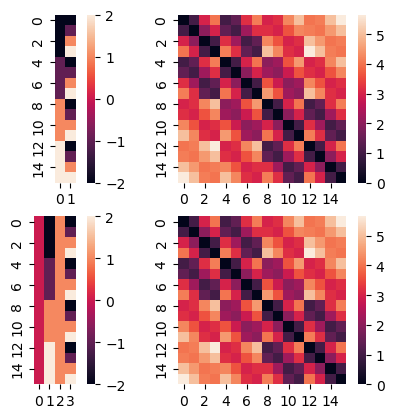

In [9]:
tadfs = [tadf for ta,tadf in plt_df.groupby("training_axset")]
ts_x = np.array([[0,0,0,0],[-2,-1,1,2]]).T
ts_y = np.array([[1,1,1,1],[-2,-1,1,2]]).T
#ts_x = np.random.random((4,100))
#ts_y = np.random.random((4,100))
composed_test = np.array([np.concatenate([v1,v2]) for v1,v2 in itertools.product(ts_x,ts_y)])
#composed_test = np.array([v1+v2 for v1,v2 in itertools.product(ts_x,ts_y)])
ts_x = np.array([[0,0,0,0],[-2,-1,1,2]]).T
ts_y = np.array([[1,1,1,1],[-2,-1,1,2]]).T
test_locs = np.array([np.concatenate([v1,v2]) for v1,v2 in itertools.product(ts_x[:,[1]],ts_y[:,[1]])])
test_locs
fig,axes = plt.subplots(2,2)
sns.heatmap(test_locs,ax = axes[0,0],square=True)
sns.heatmap(compute_rdm(test_locs,"euclidean"),ax = axes[0,1],square=True)
sns.heatmap(composed_test,ax = axes[1,0],square=True)
sns.heatmap(compute_rdm(composed_test,"euclidean"),ax = axes[1,1],square=True)

In [68]:
len(generalizers)

20

In [192]:
def offdiagonalmat(squaremat):
    offdiagmat = np.full_like(squaremat,fill_value=np.nan)
    offdiagmat[lower_tri(offdiagmat)[1]] = lower_tri(squaremat)[0]
    return offdiagmat

def nandiagonalmat(squaremat):
    nandiagmat = deepcopy(squaremat)
    np.fill_diagonal(nandiagmat,np.nan)
    return nandiagmat
fname = "training_nocenter"
curr_filt = stimsubgroup_filters[fname]
new_order_df = navi_stimdf[curr_filt].copy().reset_index(drop=True).sort_values(["training_axset","training_axloc"])
new_order = new_order_df.index
pltmnames = ["PTA_ax","PTA_locEuc","PTA_locNomial","euclidean"]
cols      = ["training_axset",["training_axloc"],"training_axloc",["stim_x","stim_y"]]
funcs     = [compute_rdm_identity,lambda x: compute_rdm(x,"euclidean"),compute_rdm_identity,lambda x: compute_rdm(x,"euclidean")]
ticklabels = ["%s%d" % ("x" if ax==0 else "y", axloc) for ax, axloc in new_order_df[["training_axset","training_axloc"]].to_numpy()]

fig,axes = plt.subplots(3,len(pltmnames),figsize=(4*(len(pltmnames)),3.5*3))
for k, (mn,col,f) in enumerate(zip(pltmnames,cols,funcs)):
    sns.heatmap(nandiagonalmat(f(new_order_df[col].to_numpy())),square=True,ax=axes[0,k])
    axes[0,k].set_title(mn)

# PTA_high = funcs[0](new_order_df[cols[0]].to_numpy()) + funcs[2](new_order_df[cols[2]].to_numpy())
# sns.heatmap(nandiagonalmat(PTA_high),square=True,ax=axes[0,2])
# axes[0,2].set_title("PTA-high") 
# PTA_high = funcs[0](new_order_df[cols[0]].to_numpy()) + funcs[1](new_order_df[cols[1]].to_numpy())
# sns.heatmap(nandiagonalmat(PTA_high),square=True,ax=axes[0,1])
# axes[0,1].set_title("PTA-low") 

for k,roi in enumerate(rois):
    broi = base_rois[k]
    Grdm_scaled_mean = np.mean([minmax_scale(compute_rdm(X[new_order,:],"correlation"),0,1) for X,subid in zip(sub_patterns[fname][roi],subid_list) if subid in generalizers],axis=0)
    NGrdm_scaled_mean = np.mean([minmax_scale(compute_rdm(X[new_order,:],"correlation"),0,1) for X,subid in zip(sub_patterns[fname][roi],subid_list) if subid not in generalizers],axis=0)

    sns.heatmap(nandiagonalmat(Grdm_scaled_mean),square=True,ax=axes[1,k])
    axes[1,k].set_title(f"Generalizer\n{broi}")
    sns.heatmap(nandiagonalmat(NGrdm_scaled_mean),square=True,ax=axes[2,k])
    axes[2,k].set_title(f"nonGeneralizer\n{broi}")

for ax in axes.flatten():
    ax.set_xticks(np.arange(len(ticklabels))+0.5,labels=ticklabels,rotation=90)
    ax.set_yticks(np.arange(len(ticklabels))+0.5,labels=ticklabels,rotation=0)

fig.tight_layout()



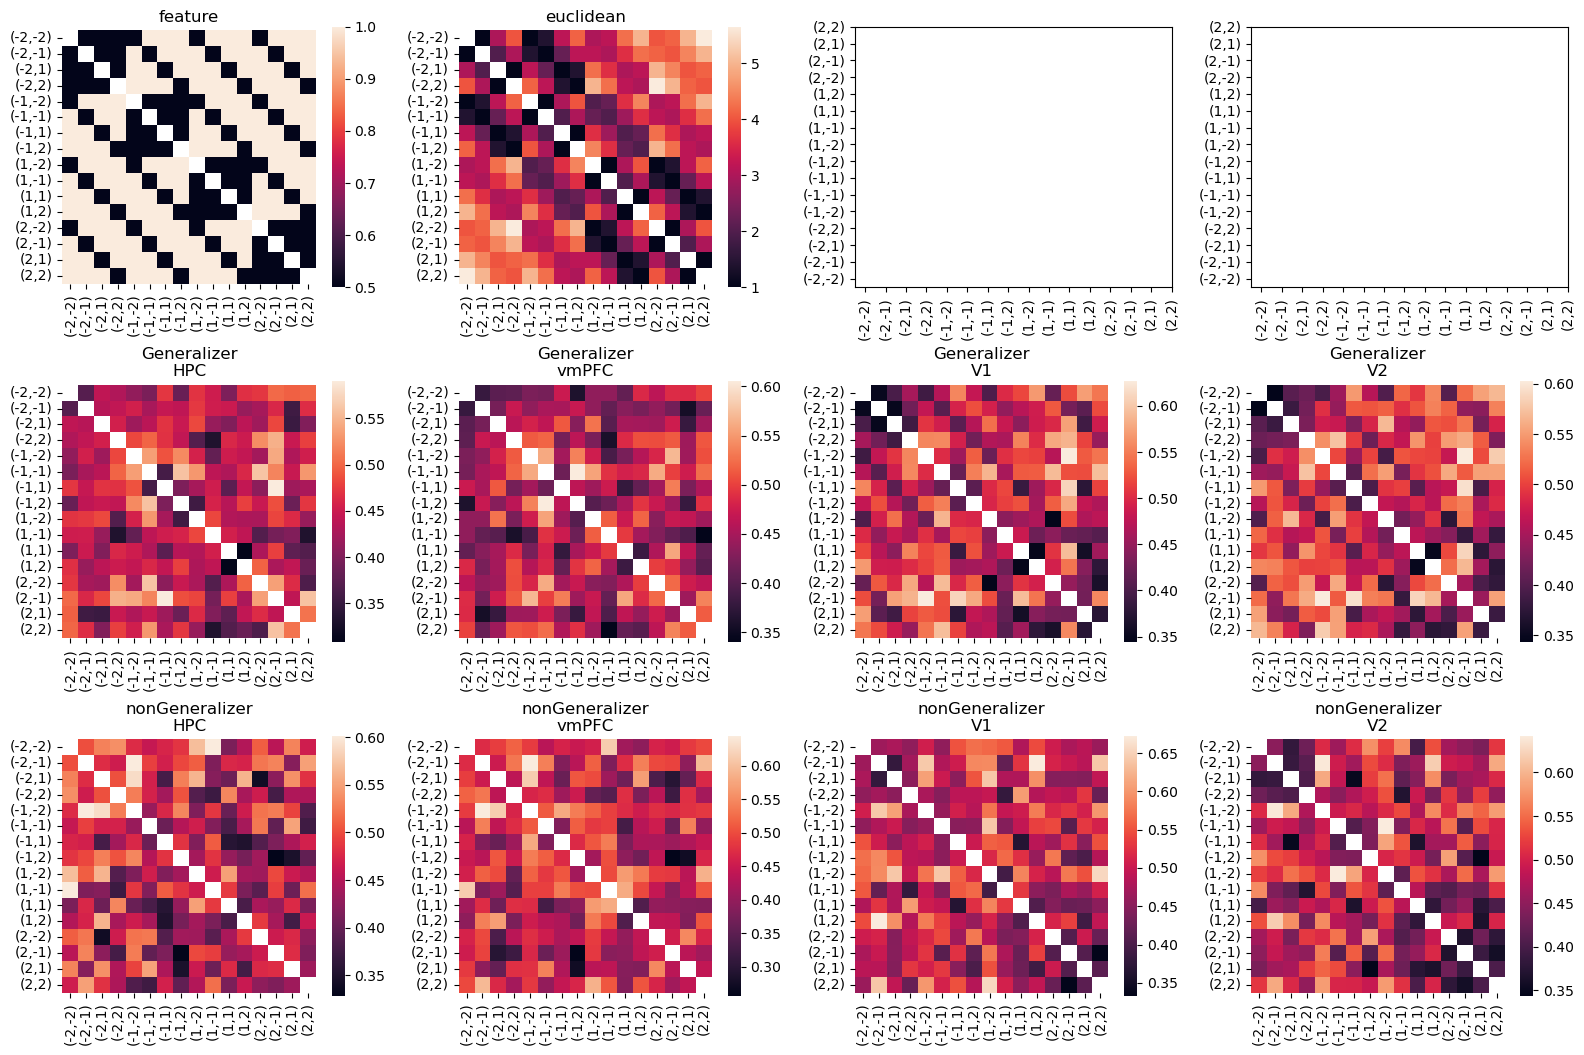

In [187]:
fname = "test"
curr_filt = stimsubgroup_filters[fname]
new_order_df = navi_stimdf[curr_filt].copy().reset_index(drop=True).sort_values(["stim_x","stim_y"])
new_order = new_order_df.index
pltmnames = ["feature","euclidean"]
cols      = [["stim_x","stim_y"],["stim_x","stim_y"]]
funcs     = [compute_rdm_nomial,lambda x: compute_rdm(x,"euclidean")]
ticklabels = ["(%d,%d)" % (x,y) for x,y in new_order_df[["stim_x","stim_y"]].to_numpy()]

fig,axes = plt.subplots(3,4,figsize=(4*4,3.5*3))
for k, (mn,col,f) in enumerate(zip(pltmnames,cols,funcs)):
    sns.heatmap(nandiagonalmat(f(new_order_df[col].to_numpy())),square=True,ax=axes[0,k])
    axes[0,k].set_title(mn)

for k,roi in enumerate(rois):
    broi = base_rois[k]
    Grdm_scaled_mean = np.mean([minmax_scale(compute_rdm(X[new_order,:],"correlation"),0,1) for X,subid in zip(sub_patterns[fname][roi],subid_list) if subid in generalizers],axis=0)
    NGrdm_scaled_mean = np.mean([minmax_scale(compute_rdm(X[new_order,:],"correlation"),0,1) for X,subid in zip(sub_patterns[fname][roi],subid_list) if subid not in generalizers],axis=0)

    sns.heatmap(nandiagonalmat(Grdm_scaled_mean),square=True,ax=axes[1,k])
    axes[1,k].set_title(f"Generalizer\n{broi}")
    sns.heatmap(nandiagonalmat(NGrdm_scaled_mean),square=True,ax=axes[2,k])
    axes[2,k].set_title(f"nonGeneralizer\n{broi}")

for ax in axes.flatten():
    ax.set_xticks(np.arange(len(ticklabels))+0.5,labels=ticklabels,rotation=90)
    ax.set_yticks(np.arange(len(ticklabels))+0.5,labels=ticklabels,rotation=0)

fig.tight_layout()


## PCA Dimensionality

In [11]:
sub_patterns.keys()

dict_keys(['training_nocenter', 'training_all', 'test', 'all_nocenter', 'all'])

In [76]:
PCA_results = []
ev_results = []
for roi in rois:
    for X,subid in zip(sub_patterns['training_nocenter'][roi],subid_list):
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        print(f"{roi} - {subid}",end="\r",flush=True)  
        pca_res = PCA().fit(scale_feature(X,2))
        ev = pca_res.explained_variance_ratio_
        cev = ev.cumsum()
        pca_resd = pd.DataFrame({
            "dim_99":PCA(0.99).fit_transform(X).shape[1],
            "dim_95":PCA(0.95).fit_transform(X).shape[1],
            "dim_90":PCA(0.9).fit_transform(X).shape[1]
        },index=[0]).assign(
            subid=subid,subgroup=subgroup,roi=roi
        )
        ev_res = pd.DataFrame(np.vstack([ev,cev,np.arange(ev.size)+1]).T,columns=["ev","cev","pc"]).assign(
            subid=subid,subgroup=subgroup,roi=roi
        )
        ev_results.append(ev_res)
        PCA_results.append(pca_resd)
        

In [77]:
PCA_resultdf = pd.concat(PCA_results).reset_index(drop=True)
PCA_resultdf[["region","side"]] = PCA_resultdf.roi.str.split("_",expand=True)
PCA_resultdf["region"] = pd.Categorical(PCA_resultdf.region,
                                        categories = base_rois,#base_rois,
                                        ordered=True)
print(f"Regions: {np.unique(PCA_resultdf.region)}")
PCA_resultdf.head(5)

ev_resultdf = pd.concat(ev_results).reset_index(drop=True)
ev_resultdf[["region","side"]] = ev_resultdf.roi.str.split("_",expand=True)
ev_resultdf["region"] = pd.Categorical(ev_resultdf.region,
                                        categories = base_rois,#base_rois,
                                        ordered=True)

Regions: ['EVC' 'HPC' 'vmPFC']


In [78]:
sns.catplot(PCA_resultdf,
            x="region",y="dim_90",hue="subgroup",
            kind="strip",dodge=True)

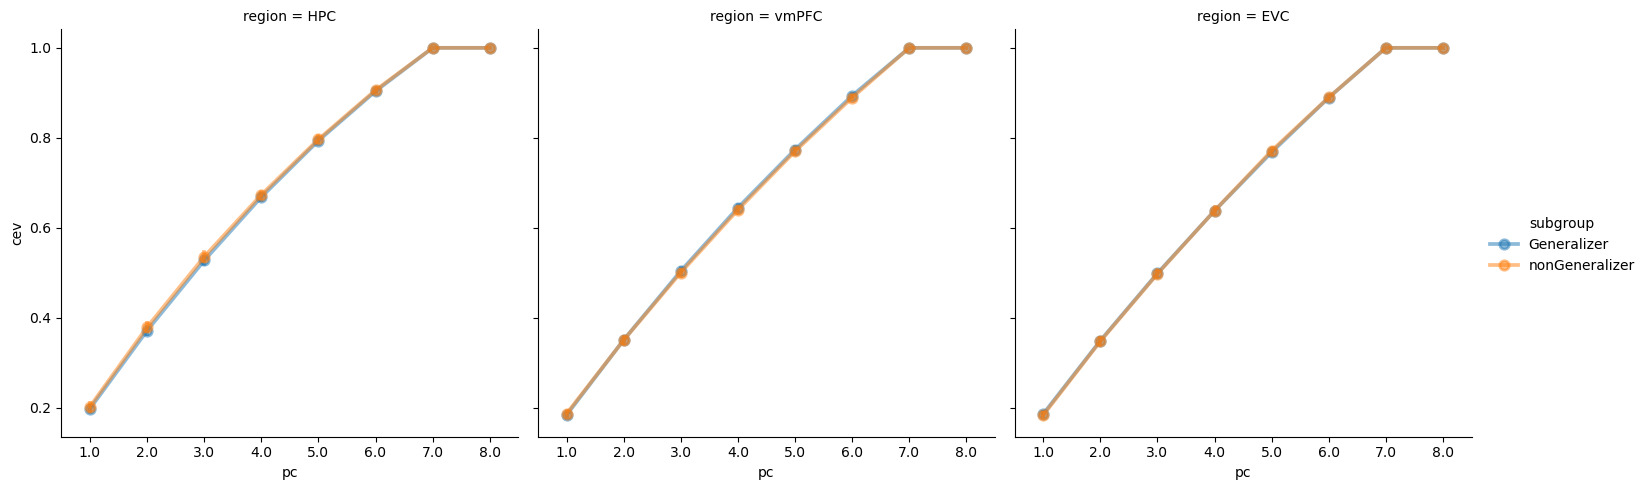

In [79]:
sns.catplot(ev_resultdf,
            x="pc",y="cev",hue="subgroup",
            col="region",
            kind="point",
            alpha=0.5)

## MDS plots

In [117]:
## plotly interactive 3D plots
for roi in rois:

    Grdm_scaled_mean = np.mean([minmax_scale(m,newmax=1,newmin=0) for m,subid in zip(sub_rdms[fname][roi],subid_list) if subid in generalizers],axis=0)
    NGrdm_scaled_mean = np.mean([minmax_scale(m,newmax=1,newmin=0) for m,subid in zip(sub_rdms[fname][roi],subid_list) if subid not in generalizers],axis=0)
    
    Grdm_scaled_mean = np.mean([m for m,subid in zip(sub_rdms[fname][roi],subid_list) if subid in generalizers],axis=0)
    NGrdm_scaled_mean = np.mean([m for m,subid in zip(sub_rdms[fname][roi],subid_list) if subid not in generalizers],axis=0)

    for subgroup, sgrdm in zip(["Generalizers","nonGeneralizers"],[Grdm_scaled_mean,NGrdm_scaled_mean]):
        outputdir = os.path.join(ROIRSAdir,"MDS",fname)
        checkdir(outputdir)
        fig, axes, X_df = plot_rdm_mds(sgrdm,ncompo=3,stimdf=navi_stimdf[curr_filt].copy().reset_index(drop=True),
                                       gcol="training_axsetstr",
                                       huecol="training_axsetstr",stylecol="training_axloc",stim_namer=lambda h,s: '%s%d' % (h,s),
                                       plot_3d=True)
        fig.suptitle(f"{roi} - {subgroup}")
        fig.savefig(os.path.join(outputdir,f"{roi}_{subgroup}.jpg"))
        #for loc1,loc2,tl in X_df[['MDS ax1', 'MDS ax2', "stim_name"]].to_numpy():
        #    axes[1].text(loc1,loc2, tl,size='small')
        plt.close()
        cpal = dict(zip(np.unique(X_df["training_axsetstr"]), 
                        sns.color_palette(None, np.unique(X_df["training_axsetstr"]).size).as_hex()))
        pxfig = px.line_3d(X_df,x="MDS ax1",y="MDS ax2",z="MDS ax3",
                           text="stim_name",
                           #symbol= "training_axloc",
                           line_group="training_axsetstr",
                           color_discrete_sequence=["black"],
                           line_dash_sequence=["dash"],
                           )
        pxfig.update_traces(
            line=dict(
                width=3
            )
        )
        for k,(ta,tadf) in enumerate(X_df.groupby("training_axsetstr")):
            trace_arr = tadf[["MDS ax1","MDS ax2","MDS ax3"]].to_numpy()
            pxfig.add_trace(
                go.Scatter3d(
                    x=trace_arr[:,0], y=trace_arr[:,1],z=trace_arr[:,2], 
                    mode='markers',
                    marker=dict(
                        color=cpal[ta]#[cpal[ta]] * trace_arr.shape[0]
                    ),
                    name=f"Training stimuli on {ta} axis",

                )
            )

        axlocs = np.unique(X_df.training_axloc)
        MDSX = X_df[["MDS ax1","MDS ax2","MDS ax3"]].to_numpy()
        assert all([np.sum(X_df.stim_x == j)==1 for j in axlocs])
        assert all([np.sum(X_df.stim_y == j)==1 for j in axlocs])
        xstims = np.array([MDSX[X_df.stim_x == j,:][0] for j in axlocs])
        ystims = np.array([MDSX[X_df.stim_y == j,:][0] for j in axlocs])
        
        pxfig.update_layout(#
            title_text=f"{roi.replace('_bilateral','')} {subgroup}",
            title_subtitle_text='Parallelism Score = %.3f' % (np.nanmean(parallel_axes_cosine_sim(xstims,ystims))),
                    title_x=0.3,title_y=0.9,
                    title_font_weight="bold",title_font_size=20,
                    title_subtitle_font_size=20)
        outputdir = os.path.join(ROIRSAdir,"MDS",fname)
        checkdir(outputdir)
        pxfig.write_html(os.path.join(outputdir,f"{roi}_{subgroup}.html"))
                

## Decoding

In [23]:
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut
from sklearn.model_selection import GridSearchCV
from zpyhelper.MVPA.preprocessors import extract_pc,average_flexi_session
def classifier_cv(X,targets,split_groups,baseclf=LinearSVC,baseclf_kwargs={},return_splits=False,
                  return_decoder=False):
    logo = LeaveOneGroupOut()
    fit_acc,pred_acc = [],[]
    decoders = []
    for i, (fit_idx, eval_idx) in enumerate(logo.split(X,targets,groups=split_groups)):
        if np.ndim(targets)>1:
            
            clf = MultiOutputClassifier(baseclf(**baseclf_kwargs))
            clf.fit(X[fit_idx,:],targets[fit_idx,:])
            fit_acc.append(clf.score(X[fit_idx,:],targets[fit_idx,:]))
            pred_acc.append(clf.score(X[eval_idx,:],targets[eval_idx,:]))
        else:
            
            clf = baseclf(**baseclf_kwargs)
            clf.fit(X[fit_idx,:],targets[fit_idx])
            
            fit_acc.append(clf.score(X[fit_idx,:],targets[fit_idx]))
            pred_acc.append(clf.score(X[eval_idx,:],targets[eval_idx]))
        decoders.append(clf)
        
    if return_splits:
        if return_decoder:
            return fit_acc,pred_acc,decoders
        else:
            return fit_acc,pred_acc
    else:
        if return_decoder:
            return np.mean(fit_acc),np.mean(pred_acc),decoders
        else:
            return np.mean(fit_acc),np.mean(pred_acc)

def classifier_gridsearchcv_cv(X,targets,split_groups,
                               gridsearcg_paramgrid,gridsearch_groups,
                               baseclf=LinearSVC,baseclf_kwargs={},return_splits=False,
                               return_decoder=False):
    logo = LeaveOneGroupOut()
    fit_acc,pred_acc = [],[]
    decoders = []
    for i, (fit_idx, eval_idx) in enumerate(logo.split(X,targets,groups=split_groups)):
        
        clf = GridSearchCV(baseclf(**baseclf_kwargs),
                            param_grid=gridsearcg_paramgrid,
                            cv=LeaveOneGroupOut())
        clf.fit(X[fit_idx,:],targets[fit_idx],groups=gridsearch_groups[fit_idx])

        fit_acc.append(clf.score(X[fit_idx,:],targets[fit_idx]))
        pred_acc.append(clf.score(X[eval_idx,:],targets[eval_idx]))
        decoders.append(clf)
        
    if return_splits:
        if return_decoder:
            return fit_acc,pred_acc,decoders
        else:
            return fit_acc,pred_acc
    else:
        if return_decoder:
            return np.mean(fit_acc),np.mean(pred_acc),decoders
        else:
            return np.mean(fit_acc),np.mean(pred_acc)

In [ ]:
from zpyhelper.MVPA.preprocessors import extract_pc,average_flexi_session

analyses = [
    ## parallel training axis
    {"name":"predict training axis cross-validate by axis location",
     "target_col":"training_axis",
     "splitby_col":"axis_location",
     "chancelvl":0.5
     },

    {"name":"predict axis location cross-validate by training axis",
     "target_col":"axis_location",
     "splitby_col":"training_axis",
     "chancelvl":0.25
     },

     ## visual receptive field (hierarchical local)
     {"name":"predict centrality cross-validate by sign",
     "target_col":"stim_centrality",
     "splitby_col":"stim_sign",
     "chancelvl":0.5
     }

     ]
trainingCCGP_results = []
for roi in rois:
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)            
        for a_config in analyses:
            a_name,target_col,split_by_col = a_config["name"],a_config["target_col"],a_config["splitby_col"]
            subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
            preprocedX = deepcopy(subdata["preprocX"])#deepcopy(subdata["preprocX"])
            stimdf = subdata["stimdf"]
            non_center_filter = [not all([x==0, y==0]) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]
            navi_filter = np.all(np.vstack([
                stimdf.taskname.to_numpy() == "navigation",
                stimdf.stim_group.to_numpy() == 1, # `train` only
                non_center_filter
            ]),axis=0)

            
            currdf = stimdf[navi_filter].copy().reset_index(drop=True)
            currdf = currdf[currdf.stim_session<=1].copy().reset_index(drop=True)
            currdf["training_axis"] = ["x" if y==0 else "y" for x,y in currdf[["stim_x","stim_y"]].to_numpy()]
            currdf["axis_location"] = [f"{int(x*2)}" if y==0 else f"{int(y*2)}" for x,y in currdf[["stim_x","stim_y"]].to_numpy()]
            currdf["stim_centrality"] = [f"{int(x*2)}" if y==0 else f"{int(y*2)}" for x,y in currdf[["stim_xdist","stim_ydist"]].to_numpy()]
            currdf["stim_sign"] = [f"{int(x)}" if y==0 else f"{int(y)}" for x,y in currdf[["stim_xsign","stim_ysign"]].to_numpy()]
            
            X = preprocedX[navi_filter,:]
            X = average_flexi_session(preprocedX[navi_filter,:], stimdf[navi_filter].copy().stim_session.to_numpy(),[[0,2],[1,3]])
            X = scale_feature(X,s_dir=1) # zscore each column #PCA(0.95).fit_transform(X)#
            targets = currdf[target_col].to_numpy()
            split_groups = currdf[split_by_col].to_numpy()
            # baseclf_kwargs = {"penalty":None,'max_iter':10000,'tol':1e-10}
            # fit_acc,eval_acc = classifier_cv(X,targets,split_groups,
            #                                 baseclf=LogisticRegression,baseclf_kwargs=baseclf_kwargs,return_splits=False)
            

            gridsearch_groups = currdf["stim_session"].to_numpy() 
            gridsearcg_paramgrid={'tol':np.logspace(-10,-3,num=10),'C':np.logspace(-5,1,num=10)}
            fit_acc,eval_acc = classifier_gridsearchcv_cv(X,targets,split_groups,
                               gridsearcg_paramgrid,gridsearch_groups,
                               baseclf=LogisticRegression,baseclf_kwargs={'max_iter':1000000},
                               return_splits=False,return_decoder=False)

            trainingCCGP_res = {"accuracy":[fit_acc,eval_acc],"stage":["fit","eval"]}
            trainingCCGP_results.append(
                pd.DataFrame(trainingCCGP_res).assign(roi=roi,subid=subid,subgroup=subgroup,analysis=a_name)
                )


Regions: Index(['HPC', 'vmPFC', 'V1', 'V2'], dtype='object')


c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


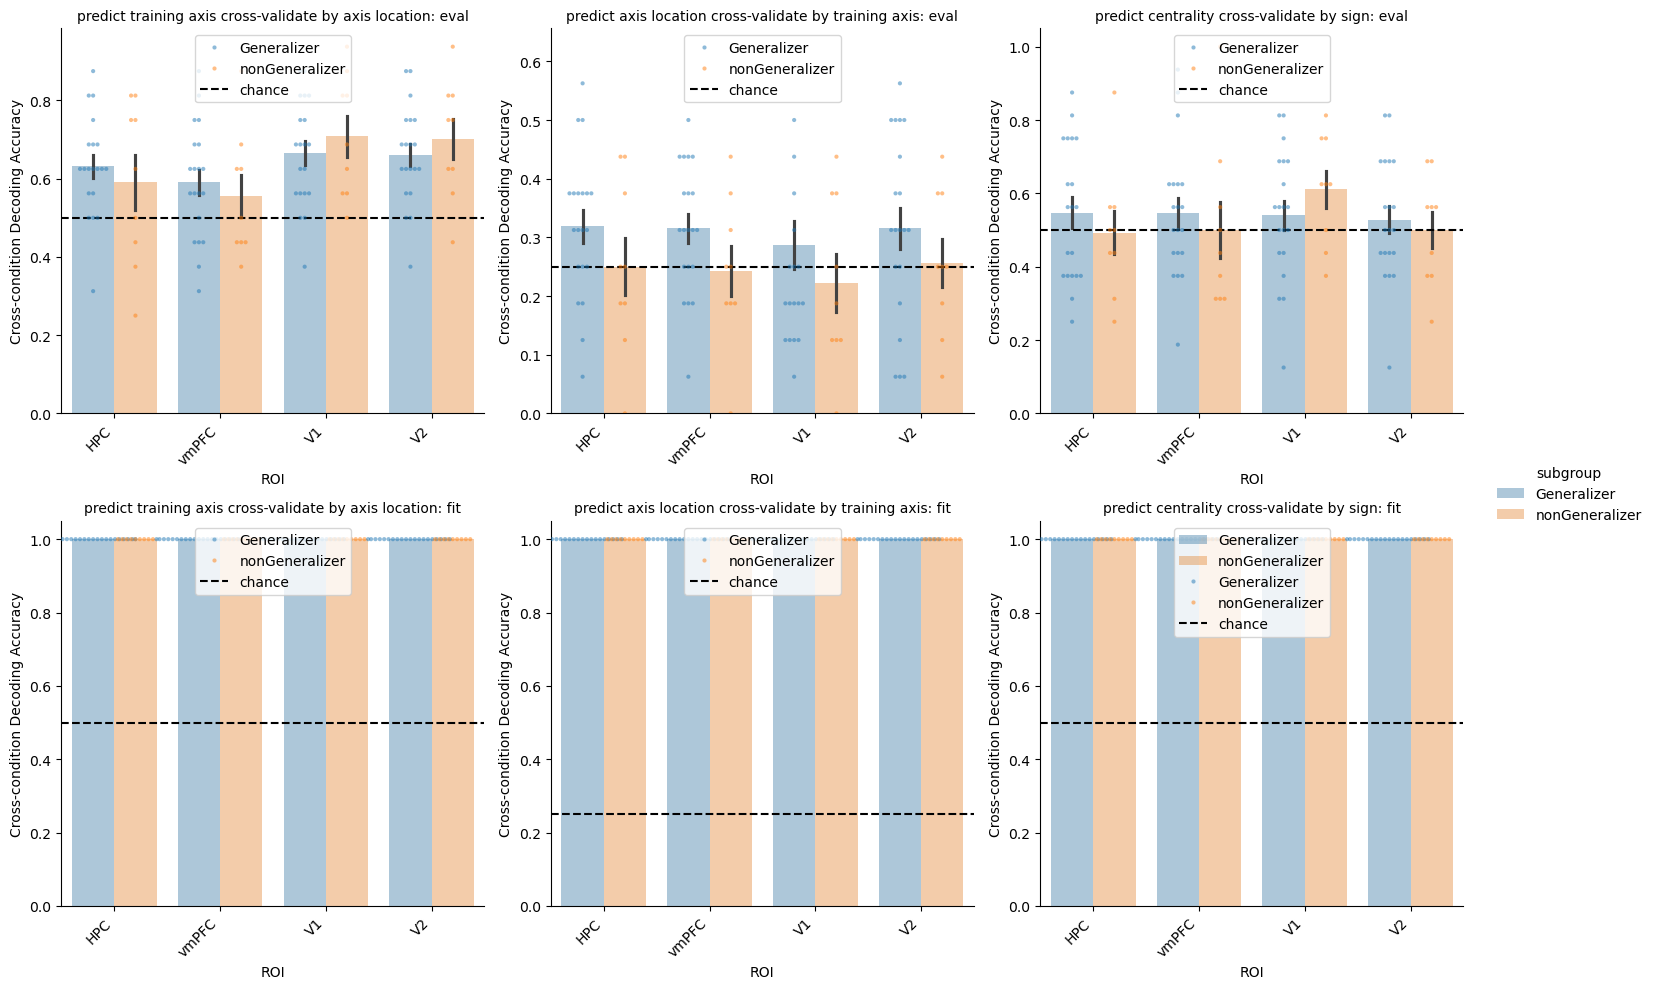

In [54]:
trainingCCGP_results_df = pd.concat(trainingCCGP_results).reset_index(drop=True)
trainingCCGP_results_df.head(5)
trainingCCGP_results_df[["region","side"]] = trainingCCGP_results_df.roi.str.split("_",expand=True)
trainingCCGP_results_df["accuracy_above_chance"] = [acc - 0.5 if "predict training axis" in ana else acc - 0.25 for acc,ana in trainingCCGP_results_df[["accuracy","analysis"]].to_numpy()] 
trainingCCGP_results_df["region"] = pd.Categorical(trainingCCGP_results_df.region,
                                                   categories = base_rois,#base_rois,
                                                   ordered=True)
trainingCCGP_results_df["stage"] = pd.Categorical(trainingCCGP_results_df.stage,
                                                   categories = ['eval', 'fit'],
                                                   ordered=True)
trainingCCGP_results_df["analysis"] = pd.Categorical(trainingCCGP_results_df.analysis,
                                                    categories = ["predict training axis cross-validate by axis location",
                                                                  "predict axis location cross-validate by training axis",
                                                                  "predict centrality cross-validate by sign"],
                                                   ordered=True)
trainingCCGP_results_df.to_csv(os.path.join(ROIRSAdir,"trainingstimuliCCGP.csv"))
print(f"Regions: {trainingCCGP_results_df.region.cat.categories}")

fg_trainingCCGP = sns.catplot(trainingCCGP_results_df,
            hue="subgroup",y="accuracy",
            row="stage",
            x="region",col="analysis",
            kind="bar",errorbar="se",
            sharey=False,alpha=0.4)
fg_trainingCCGP.set_titles(template="{col_name}: {row_name}")
fg_trainingCCGP.map(sns.swarmplot, 'region', "accuracy", "subgroup", dodge=True, 
                     size=3,alpha=0.5,
                     hue_order=['Generalizer', 'nonGeneralizer'],palette=sns.color_palette()[:2],
                     order = base_rois)
for ax in fg_trainingCCGP.axes.flatten():
    if "predict axis location" in ax.title.get_text():
        ax.axhline(0.25,label="chance",color="k",ls='--')
    else:
        ax.axhline(0.5,label="chance",color="k",ls='--')
    ax.set_xlabel("ROI",visible=True)
    ax.set_ylabel("Cross-condition Decoding Accuracy",visible=True)
    ax.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha="right")
    old_labels = ax.get_xticklabels()
    #ax.set_xticklabels([x.get_text().replace("cluster_","").replace("_","\n") for x in old_labels])
    #ax.set_aspect(3)
    ax.legend()
    sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5,1))

fg_trainingCCGP.tight_layout()


C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\3572881438.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  assert prows*pcols>=len(list(enumerate(datadf.groupby(facet_vars))))
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\3572881438.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ifacet,(facet_val,facet_df) in enumerate(datadf.groupby(facet_vars)):
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\3572881438.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

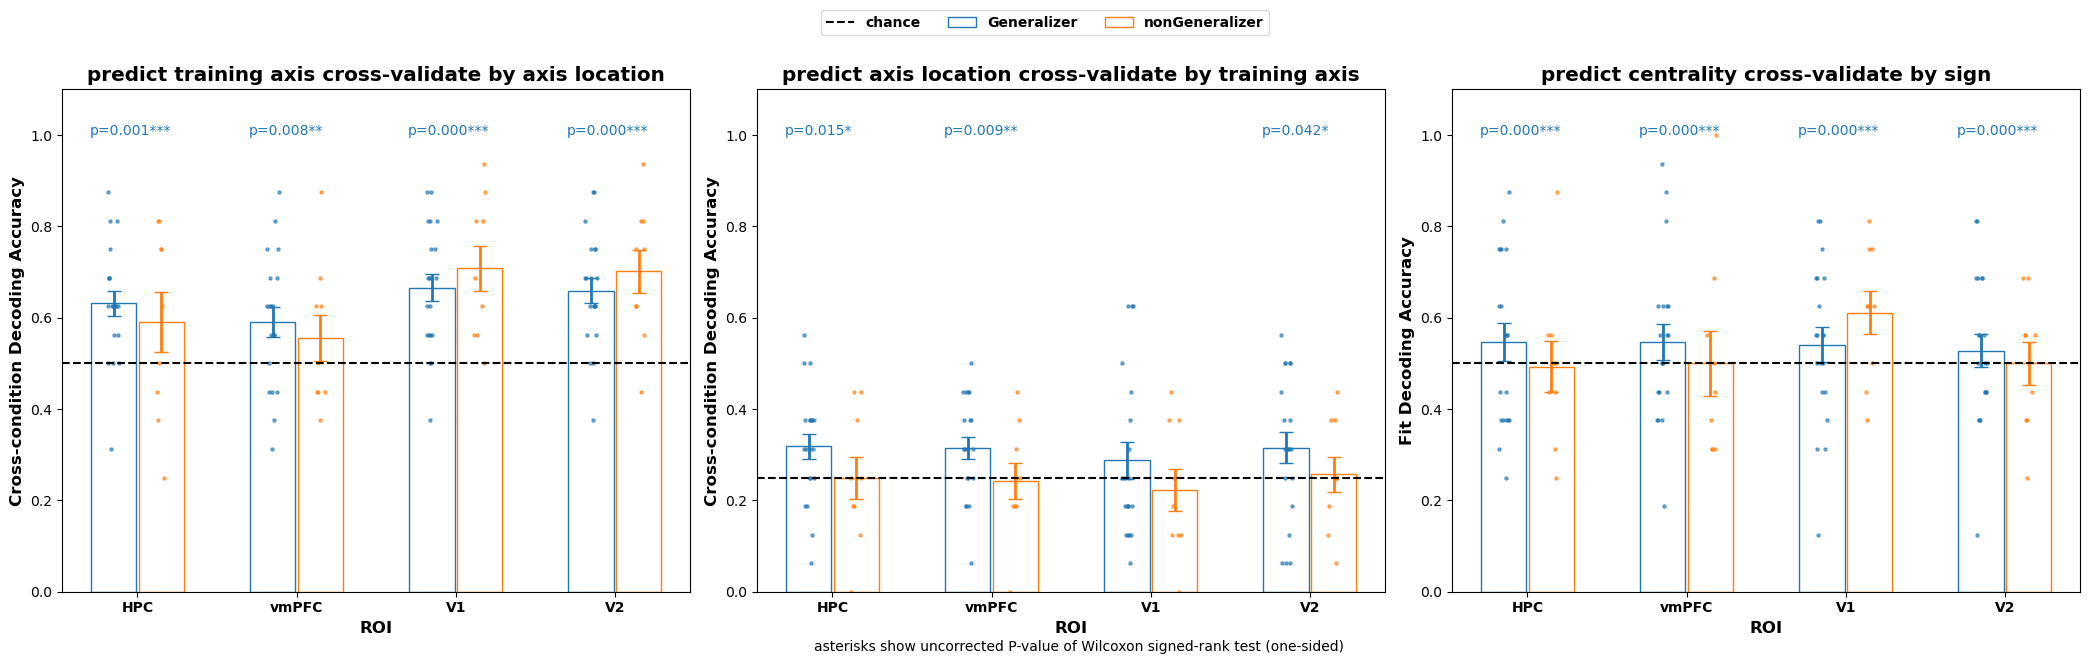

In [154]:
xvar, gvar, yvar, yvartest = "region",  "subgroup", "accuracy","accuracy_above_chance"
fig,axes = grouped_barscatter_withstats(trainingCCGP_results_df[trainingCCGP_results_df.stage=="eval"],
                             facet_vars = "analysis", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                             prows=1,pcols=3,
                             statfunc=lambda yt: 1. if np.size(yt)<10 else scipy.stats.wilcoxon(yt,alternative='greater').pvalue)
for ifacet, _ in enumerate(axes.flatten()):
    if ifacet<2:
        axes.flatten()[ifacet].set_ylabel("Cross-condition Decoding Accuracy",fontweight="bold",fontsize="large")

    else:
        axes.flatten()[ifacet].set_ylabel("Fit Decoding Accuracy",fontweight="bold",fontsize="large")
    
    axes.flatten()[ifacet].set_xlabel("ROI",fontweight="bold",fontsize="large")
    if "predict axis location" in axes.flatten()[ifacet].title.get_text():
        axes.flatten()[ifacet].axhline(0.25,label="chance",color="k",ls='--')
    else:
        axes.flatten()[ifacet].axhline(0.5,label="chance",color="k",ls='--')
    
hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
fig.legend([hs[0],hs[1],hs[-1]],[ls[0],ls[1],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
           prop = dict(weight="bold"))
fig.text(x=0.39, y=0, s='asterisks show uncorrected P-value of Wilcoxon signed-rank test (one-sided)')
fig.tight_layout()

## RSA regression

In [8]:
from scipy.spatial.distance import pdist, squareform

In [144]:
res_df_list = []
for roi in rois:
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        preprocedX = deepcopy(subdata["preprocX"])#deepcopy(subdata["rawX"])#
        stimdf = subdata["stimdf"]
        
        navi_filter = stimdf.taskname.to_numpy() == "navigation"
        non_center_filter = [not all([x==0, y==0]) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]

        final_filter = np.all([navi_filter,non_center_filter],axis=0)
        #average across sessions
        navi_X = np.mean(split_data(X      = preprocedX[final_filter,:],
                                    groups = stimdf[final_filter].copy().stim_session.to_numpy()),
                        axis=0)
        
        stim_dict = stimdf[final_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True).to_dict('list')
        submodelrdm = ModelRDM(
            stimid    = stim_dict["stim_id"],
            stimgtloc = np.vstack([stim_dict["stim_x"],stim_dict["stim_y"]]).T,
            stimfeature = np.vstack([stim_dict["stim_color"],stim_dict["stim_shape"]]).T,
            stimgroup = stim_dict["stim_group"],
            sessions = stim_dict["stim_session"],
            nan_identity = False,
            splitgroup  = True
        )

        prim_reg_names = ["gtlocEuclidean","feature"]
        
        analyses = [
            {"name": "train stim withinxy",
            "reg_names": ["withinxy_trainstimpairs_PTA_locEuc","withinxy_trainstimpairs_hierachical_wrtcentre"],
            "short_names": ["PTA_locEuc within axis","VisualField within axis"]
            },
            
            {"name": "train stim withinxy - Euc",
            "reg_names": ["withinxy_trainstimpairs_PTA_locEuc"],
            "short_names": ["PTA_locEuc within axis"]
            },
            {"name": "train stim withinxy - VisualField",
            "reg_names": ["withinxy_trainstimpairs_hierachical_wrtcentre"],
            "short_names": ["VisualField within axis"]
            },

            {"name": "train stim betweenxy Cartesian", 
            "reg_names": ["betweenxy_trainstimpairs_gtlocEuclidean"],
            "short_names": ["gtlocEuclidean"]
            },
            {"name": "train stim betweenxy PTA low",
            "reg_names": ["betweenxy_trainstimpairs_PTA_locEuc"],
            "short_names": ["PTA_locEuc"]
            },
            {"name": "train stim betweenxy PTA high",
            "reg_names": ["betweenxy_trainstimpairs_PTA_locNomial"],
            "short_names": ["PTA_locNomial"]
            },
            {"name": "train stim betweenxy Compete PTA Cartesian",
            "reg_names": ["betweenxy_trainstimpairs_gtlocEuclidean","betweenxy_trainstimpairs_PTA_locEuc","betweenxy_trainstimpairs_PTA_locNomial"],
#                          "betweenxy_trainstimpairs_PTA_locRevEuc","betweenxy_trainstimpairs_PTA_locRevNomial"],
            "short_names": ["gtlocEuclidean","PTA_locNomial","PTA_locEuc"],#,"PTA_locRevEuc","PTA_locRevNomial"]
            },


            {"name": "train stim Cartesian", 
            "reg_names": ["trainstimpairs_feature","trainstimpairs_gtlocEuclidean"],
            "short_names": ["feature","gtlocEuclidean"]
            },
            {"name": "train stim PTA low",
            "reg_names":  [ "trainstimpairs_PTA_ax", "trainstimpairs_PTA_locEuc", "trainstimpairs_gtlocEuclidean"],
            "short_names":  ["PTA_ax","PTA_locEuc","gtlocEuclidean"]
            },
            {"name": "train stim PTA high",
            "reg_names": ["trainstimpairs_PTA_ax", "trainstimpairs_PTA_locNomial", "trainstimpairs_gtlocEuclidean"],
            "short_names":  ["PTA_ax","PTA_locNomial","gtlocEuclidean"]
            },
            {"name": "train stim Compete PTA Cartesian",
            "reg_names": [f"trainstimpairs_{x}" for x in prim_reg_names[:1]] + ["trainstimpairs_PTA_ax", "trainstimpairs_PTA_locEuc", "trainstimpairs_PTA_locNomial"],#, "trainstimpairs_PTA_locRevEuc", "trainstimpairs_PTA_locRevNomial"],
            "short_names":  prim_reg_names[:1] + ["PTA_ax","PTA_locEuc","PTA_locNomial"]#,"PTA_locRevEuc","PTA_locRevNomial"]
            },
            {"name": "test stim Compete Feature Cartesian",
            "reg_names": [f"teststimpairs_{x}" for x in prim_reg_names],
            "short_names":  prim_reg_names
            },
            {"name": "test stim Compete Feature CartesianCB",
            "reg_names": [f"teststimpairs_{x}" for x in ["gtlocCityBlock","feature"]],
            "short_names":  ["gtlocCityBlock","feature"]
            }
            
        ]
        
        for analysis_dict in analyses:
            reg_names, short_names = analysis_dict["reg_names"], analysis_dict["short_names"]
            reg_vals  = [submodelrdm.models[k] for k in reg_names]
            reg_estimator  = MultipleRDMRegression(navi_X,
                                                   modelrdms=reg_vals,
                                                   modelnames=short_names,
                                                   rdm_metric="correlation")
            reg_estimator.fit()
            res_df = pd.DataFrame(
                {"modelrdm":   reg_estimator.modelnames,
                "coefficient": reg_estimator.result}
            ).assign(
            roi = roi,
            subid=subid,
            subgroup=subgroup,
            analysis = analysis_dict["name"],
            adjR2 = reg_estimator.adjR2,
            R2    = reg_estimator.R2,
            )
            res_df_list.append(res_df)



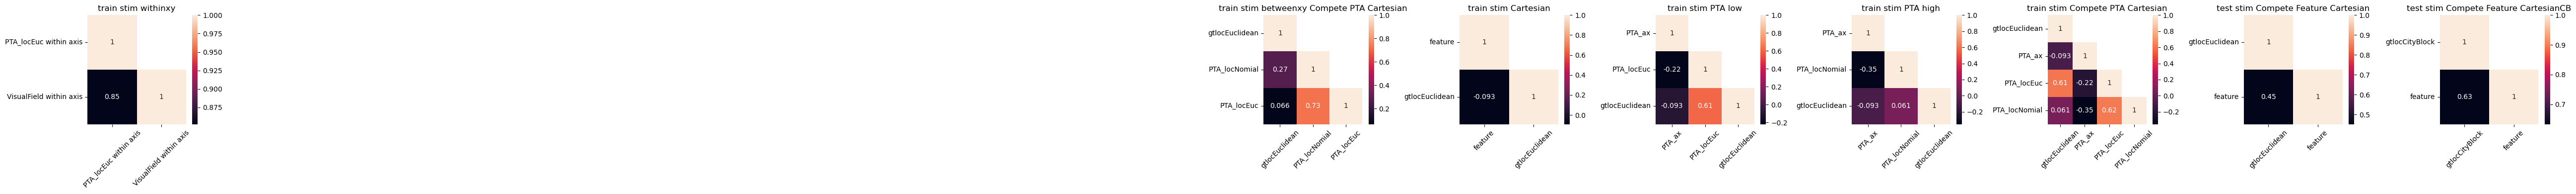

In [9]:
fig_regcorr, axes_regcorr = plt.subplots(1,len(analyses),figsize=(4*len(analyses),4))
for j,analysis_dict in enumerate(analyses):
    reg_names, short_names = analysis_dict["reg_names"], analysis_dict["short_names"]
    if len(reg_names)>1:
        reg_vals  = [submodelrdm.models[k] for k in reg_names]
        reg_estimator  = MultipleRDMRegression(navi_X,
                                            modelrdms=reg_vals,
                                            modelnames=short_names,
                                            rdm_metric="correlation")
        reg_estimator.fit()

        regressor_corrs = 1 - compute_rdm(reg_estimator.X[reg_estimator.na_filters].T,"correlation")
        regressor_corrs[upper_tri(regressor_corrs)[1]] = np.nan
        sns.heatmap(regressor_corrs,ax = axes_regcorr.flatten()[j],annot=True)
        axes_regcorr.flatten()[j].set_xticklabels(short_names,rotation=45)
        axes_regcorr.flatten()[j].set_yticklabels(short_names,rotation=0)
        axes_regcorr.flatten()[j].set_title(analysis_dict["name"])
    else:
        axes_regcorr.flatten()[j].remove()
fig_regcorr.tight_layout()

In [149]:
res_df = pd.concat(res_df_list,axis=0).reset_index(drop=True)
res_df[["region","side"]] = res_df.roi.str.split("_",expand=True)
res_df.region = pd.Categorical(res_df.region,categories=base_rois,ordered=True)
print(res_df.shape)
print(f"unique analysis names: {np.unique(res_df.analysis)}")
print(f"unique modelrdm names: {np.unique(res_df.modelrdm)}")
res_df.head(5)


(3016, 10)
unique analysis names: ['test stim Compete Feature Cartesian'
 'test stim Compete Feature CartesianCB' 'train stim Cartesian'
 'train stim Compete PTA Cartesian' 'train stim PTA high'
 'train stim PTA low' 'train stim betweenxy Cartesian'
 'train stim betweenxy Compete PTA Cartesian'
 'train stim betweenxy PTA high' 'train stim betweenxy PTA low'
 'train stim withinxy' 'train stim withinxy - Euc'
 'train stim withinxy - VisualField']
unique modelrdm names: ['PTA_ax' 'PTA_locEuc' 'PTA_locEuc within axis' 'PTA_locNomial'
 'VisualField within axis' 'feature' 'gtlocCityBlock' 'gtlocEuclidean']


modelrdm  coefficient            roi   subid     subgroup  \
0   PTA_locEuc within axis    -0.966218  HPC_bilateral  sub001  Generalizer   
1  VisualField within axis     0.732143  HPC_bilateral  sub001  Generalizer   
2   PTA_locEuc within axis    -0.342223  HPC_bilateral  sub001  Generalizer   
3  VisualField within axis    -0.091352  HPC_bilateral  sub001  Generalizer   
4           gtlocEuclidean    -0.025853  HPC_bilateral  sub001  Generalizer   

                            analysis     adjR2        R2 region       side  
0                train stim withinxy  0.190158  0.263780    HPC  bilateral  
1                train stim withinxy  0.190158  0.263780    HPC  bilateral  
2          train stim withinxy - Euc  0.117117  0.117117    HPC  bilateral  
3  train stim withinxy - VisualField  0.008345  0.008345    HPC  bilateral  
4     train stim betweenxy Cartesian  0.000668  0.000668    HPC  bilateral

In [ ]:
R2_df = res_df.groupby(["subgroup","subid","analysis","side","region","roi"])[["adjR2","R2"]].mean().reset_index()
R2_df["region"] = pd.Categorical(R2_df.region,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
comparedregressions = ["train stim betweenxy Cartesian","train stim betweenxy PTA high"]
comparedregressions = ["train stim Feature","train stim Cartesian","train stim PTA high"]
comparedregressions = ["train stim withinxy - Euc","train stim withinxy - VisualField"]

compare_r2_df = R2_df[R2_df.analysis.isin(comparedregressions)].copy().reset_index(drop=True)
pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
xvar, gvar, yvar = "subgroup",  "analysis", "adjR2"
hue_dict = dict(zip(np.unique(compare_r2_df[gvar]),sns.color_palette(None,6)[2:]))
fig,axes = plt.subplots(prows,pcols,figsize=(8*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(compare_r2_df.groupby("region")):
    y_lim = np.array([np.min(roi_df[yvar]),np.max(roi_df[yvar])])*1.1
    dodge_group = 0.15
    xdev = [ -dodge_group/2,dodge_group/2]
    x_centers=np.arange(np.unique(R2_df[xvar]).size)
    for kg,(gname,g_df) in enumerate(roi_df.groupby(gvar)):
        x_locs = dict(zip(np.unique(R2_df[xvar]),x_centers+xdev[kg]))
        for xname,xloc in x_locs.items():   
            y = g_df[g_df[xvar]==xname][yvar].to_numpy()
            jitt_x = np.random.random(y.shape)*.25*dodge_group - .25*dodge_group/2
            pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
            axes.flatten()[iroi].text(x=xloc, y=y_lim[1]/1.1,s=gen_pval_annot(pval*8),fontweight="bold")
            axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
            axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*0.5,label=gname,
                                color='None',edgecolor=hue_dict[gname])
            axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                barsabove=True,
                                ecolor=hue_dict[gname],alpha=1,linewidth=2)
    axes.flatten()[iroi].set_xticks(ticks=np.arange(np.unique(R2_df[xvar]).size),
                                    labels=np.unique(R2_df[xvar]),
                                    fontweight="bold")
    axes.flatten()[iroi].set_ylim(y_lim)
    axes.flatten()[iroi].set_title(f"{roi}",fontweight="bold",fontsize="x-large")
    axes.flatten()[iroi].legend()

In [167]:
axes.flatten()[ifacet].figure.get_figwidth()

28.0

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\418968527.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  assert prows*pcols>=len(list(enumerate(datadf.groupby(facet_vars))))
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\418968527.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ifacet,(facet_val,facet_df) in enumerate(datadf.groupby(facet_vars)):
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\418968527.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

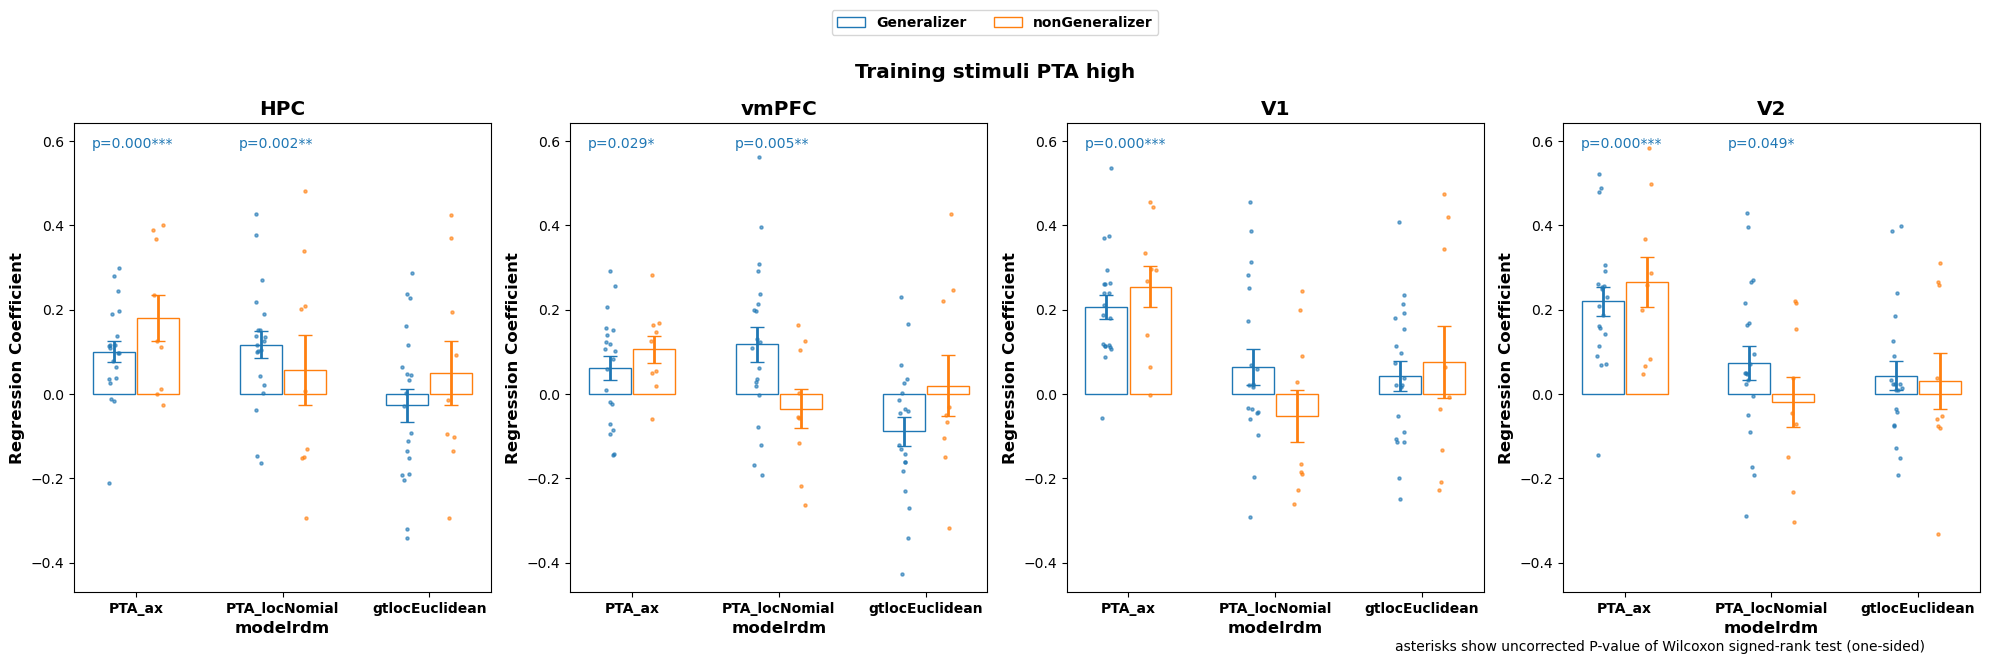

In [180]:
xvar, gvar, yvar, yvartest = "modelrdm",  "subgroup", "coefficient", "coefficient"

plt_ana = dict(zip(["train stim withinxy - Euc","train stim PTA high","test stim Compete Feature Cartesian"],
                   ["Trianing Stimuli within Each Axis", "Training stimuli PTA high", "Test Stimuli"]))
aprs    = dict(zip(["train stim withinxy - Euc","train stim PTA high","test stim Compete Feature Cartesian"],
                   [1.5,1.2,1]))


for a, atitle in plt_ana.items():
    curr_pdf = res_df[(res_df.analysis==a)].copy().reset_index(drop=True)
    curr_pdf.modelrdm = pd.Categorical(curr_pdf.modelrdm)
    fig,axes = grouped_barscatter_withstats(curr_pdf,
                                facet_vars = "region", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                                prows=1,pcols=4,hrow=6,wcol=6/aprs[a],
                                statfunc=lambda yt: 1. if np.size(yt)<10 else scipy.stats.wilcoxon(yt,alternative='greater').pvalue)
    for ifacet, _ in enumerate(axes.flatten()):
        axes.flatten()[ifacet].set_ylabel("Regression Coefficient",fontweight="bold",fontsize="large")
        axes.flatten()[ifacet].set_xlabel("modelrdm",fontweight="bold",fontsize="large")
        #axes.flatten()[ifacet].set_aspect(aprs[a])
    
        
    hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
    fig.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
            prop = dict(weight="bold"))
    fig.suptitle(atitle,fontweight="bold",fontsize="x-large")
    fig.text(x=0.7, y=0, s='asterisks show uncorrected P-value of Wilcoxon signed-rank test (one-sided)')
    #fig.set_figheight(axes.flatten()[ifacet].figure.get_figheight())
    #fig.set_figwidth(axes.flatten()[ifacet].figure.get_figwidth())
    fig.tight_layout()


In [29]:
pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
hue_dict = dict(zip(np.unique(res_df["subgroup"]),sns.color_palette(None,2)))
intersted_rdms=["withinxy_gtlocEuclidean","gtlocEuclidean","gtlocCityBlock","feature",
                "stimuligroup",
                "PTA","PTA_locNomial","PTA_locEuc","PTA_ax","PTA_locRevNomial","PTA_locRevEuc"]
plt_df = res_df[res_df.modelrdm.isin(intersted_rdms)].copy()
plt_df["region"] = pd.Categorical(plt_df.region,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
fig,axes = plt.subplots(prows,pcols,figsize=(8*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(plt_df.groupby("region")):
    roi_df = roi_df[roi_df.analysis=='test stim Compete Feature Cartesian'].copy().reset_index(drop=True)
    for jana,(aname,ana_df) in enumerate(roi_df.groupby("analysis")):
        y_lim = np.array([np.min(ana_df.coefficient),np.max(ana_df.coefficient)])*1.1
        dodge_group = 0.15
        xdev = [-dodge_group,dodge_group]
        modelrdm_names = np.unique(ana_df["modelrdm"])
        n_modelrdms = modelrdm_names.size
        x_centers=np.arange(n_modelrdms)
        for kg,(gname,g_df) in enumerate(ana_df.groupby("subgroup")):
            x_locs = dict(zip(modelrdm_names,x_centers+xdev[kg]))
            for mname,xloc in x_locs.items():   
                y = g_df[g_df.modelrdm==mname]["coefficient"].to_numpy()
                jitt_x = np.random.random(y.shape)*.5*dodge_group - .5*dodge_group/2
                sres = scipy.stats.wilcoxon(np.arctanh(y),alternative="greater")
                tval = sres.statistic
                pval = sres.pvalue                
                axes.flatten()[iroi].text(x=xloc, y=y_lim[1]/1.1,s=gen_pval_annot(pval),fontweight="bold")
                axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
                axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*1.9,label=gname,
                                    color='None',edgecolor=hue_dict[gname])
                axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                    barsabove=True,
                                    ecolor=hue_dict[gname],alpha=1,linewidth=2)
        axes.flatten()[iroi].set_xticks(ticks=np.arange(n_modelrdms),
                                        labels=modelrdm_names,
                                        fontweight="bold")
        axes.flatten()[iroi].set_ylim(y_lim)
        axes.flatten()[iroi].set_title(f"{roi}",fontweight="bold",fontsize="x-large")
        axes.flatten()[iroi].legend().remove()

fig.suptitle("Test Stimuli Representation in navigation task", fontweight="bold",fontsize="xx-large")
fig.tight_layout()

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_16868\3152133540.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for iroi,(roi,roi_df) in enumerate(plt_df.groupby("region")):


C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_40036\808907776.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_40036\808907776.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



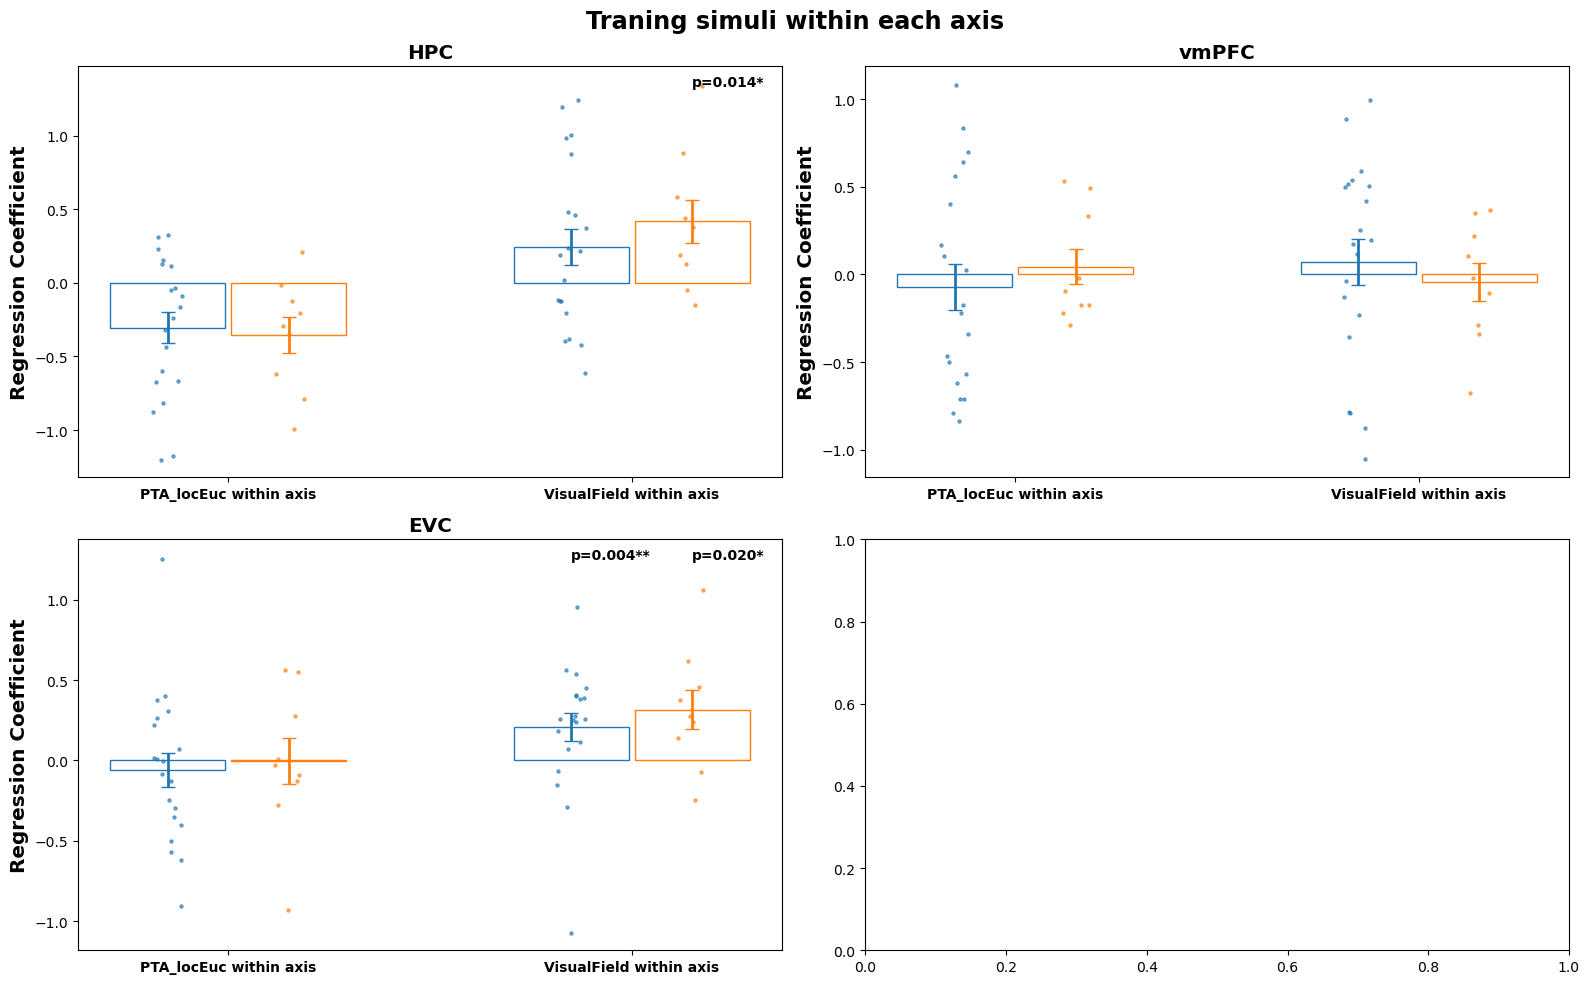

In [160]:
pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
hue_dict = dict(zip(np.unique(res_df["subgroup"]),sns.color_palette(None,2)))
intersted_rdms=["PTA_locEuc within axis","VisualField within axis"]
plt_df = res_df[res_df.modelrdm.isin(intersted_rdms)]
plt_df["region"] = pd.Categorical(plt_df.region,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
fig,axes = plt.subplots(prows,pcols,figsize=(8*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(plt_df.groupby("region")):
    roi_df = roi_df[roi_df.analysis=='train stim withinxy'].copy().reset_index(drop=True)
    for jana,(aname,ana_df) in enumerate(roi_df.groupby("analysis")):
        y_lim = np.array([np.min(ana_df.coefficient),np.max(ana_df.coefficient)])*1.1
        dodge_group = 0.15
        xdev = [-dodge_group,dodge_group]
        modelrdm_names = np.unique(ana_df["modelrdm"])
        n_modelrdms = modelrdm_names.size
        x_centers=np.arange(n_modelrdms)
        for kg,(gname,g_df) in enumerate(ana_df.groupby("subgroup")):
            x_locs = dict(zip(modelrdm_names,x_centers+xdev[kg]))
            for mname,xloc in x_locs.items():   
                y = g_df[g_df.modelrdm==mname]["coefficient"].to_numpy()
                jitt_x = np.random.random(y.shape)*.5*dodge_group - .5*dodge_group/2
                pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
                axes.flatten()[iroi].text(x=xloc, y=y_lim[1]/1.1,s=gen_pval_annot(pval),fontweight="bold")
                axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
                axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*1.9,label=gname,
                                    color='None',edgecolor=hue_dict[gname])
                axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                    barsabove=True,
                                    ecolor=hue_dict[gname],alpha=1,linewidth=2)
        axes.flatten()[iroi].set_xticks(ticks=np.arange(n_modelrdms),
                                        labels=modelrdm_names,
                                        fontweight="bold")
        axes.flatten()[iroi].set_ylim(y_lim)
        axes.flatten()[iroi].set_title(f"{roi}",fontweight="bold",fontsize="x-large")
        axes.flatten()[iroi].legend().remove()
        axes.flatten()[iroi].set_ylabel("Regression Coefficient", fontweight="bold",fontsize="x-large")
        

fig.suptitle("Traning simuli within each axis", fontweight="bold",fontsize="xx-large")
fig.tight_layout()

In [490]:
np.min(plt_df.coefficient)

-2.6776156567080553

In [ ]:
pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
hue_dict = dict(zip(np.unique(res_df["subgroup"]),sns.color_palette(None,2)))
intersted_rdms=["withinxy_gtlocEuclidean","gtlocEuclidean","feature","stimuligroup","PTA","PTA_locNomial","PTA_locEuc","PTA_ax","PTA_locRevNomial","PTA_locRevEuc"]
plt_df = res_df[res_df.modelrdm.isin(intersted_rdms)]
plt_df = plt_df[plt_df.side=="bilateral"]
plt_df["region"] = pd.Categorical(plt_df.region,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
fig,axes = plt.subplots(prows,pcols,figsize=(8*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(plt_df.groupby("region")):
    roi_df = roi_df[roi_df.analysis=='train stim Compete PTA Cartesian'].copy().reset_index(drop=True)
    for jana,(aname,ana_df) in enumerate(roi_df.groupby("analysis")):
        y_lim = np.array([np.min(ana_df.coefficient),np.max(ana_df.coefficient)])*1.1
        dodge_group = 0.15
        xdev = [-dodge_group,dodge_group]
        modelrdm_names = np.unique(ana_df["modelrdm"])
        n_modelrdms = modelrdm_names.size
        x_centers=np.arange(n_modelrdms)
        for kg,(gname,g_df) in enumerate(ana_df.groupby("subgroup")):
            x_locs = dict(zip(modelrdm_names,x_centers+xdev[kg]))
            for mname,xloc in x_locs.items():   
                y = g_df[g_df.modelrdm==mname]["coefficient"].to_numpy()
                jitt_x = np.random.random(y.shape)*.5*dodge_group - .5*dodge_group/2
                pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
                axes.flatten()[iroi].text(x=xloc-dodge_group, y=y_lim[1]/(1+0.1*(kg+1)),s=gen_pval_annot(pval),fontweight="bold")
                axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
                axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*1.9,label=gname,
                                    color='None',edgecolor=hue_dict[gname])
                axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                    barsabove=True,
                                    ecolor=hue_dict[gname],alpha=1,linewidth=2)
        axes.flatten()[iroi].set_xticks(ticks=np.arange(n_modelrdms),
                                        labels=modelrdm_names,
                                        fontweight="bold")
        axes.flatten()[iroi].set_ylim(y_lim)
        axes.flatten()[iroi].set_title(f"{roi} \n train stim Compete PTA Cartesian",fontweight="bold",fontsize="x-large")
        axes.flatten()[iroi].legend().remove()

fig.suptitle("Training Stimuli Representation in navigation task", fontweight="bold",fontsize="xx-large")
fig.text(x=0.8, y=-.01, s='asterisks show bonferroni corrected P-value')
fig.tight_layout()


In [295]:
np.unique(res_df.analysis)

array(['test stim Compete Feature Cartesian', 'train stim Cartesian',
       'train stim Compete PTA Cartesian', 'train stim Feature',
       'train stim PTA high', 'train stim PTA low',
       'train stim betweenxy Cartesian',
       'train stim betweenxy Compete PTA Cartesian',
       'train stim betweenxy PTA high', 'train stim betweenxy PTA low',
       'train stim withinxy'], dtype=object)

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_40036\4103957995.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_40036\4103957995.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



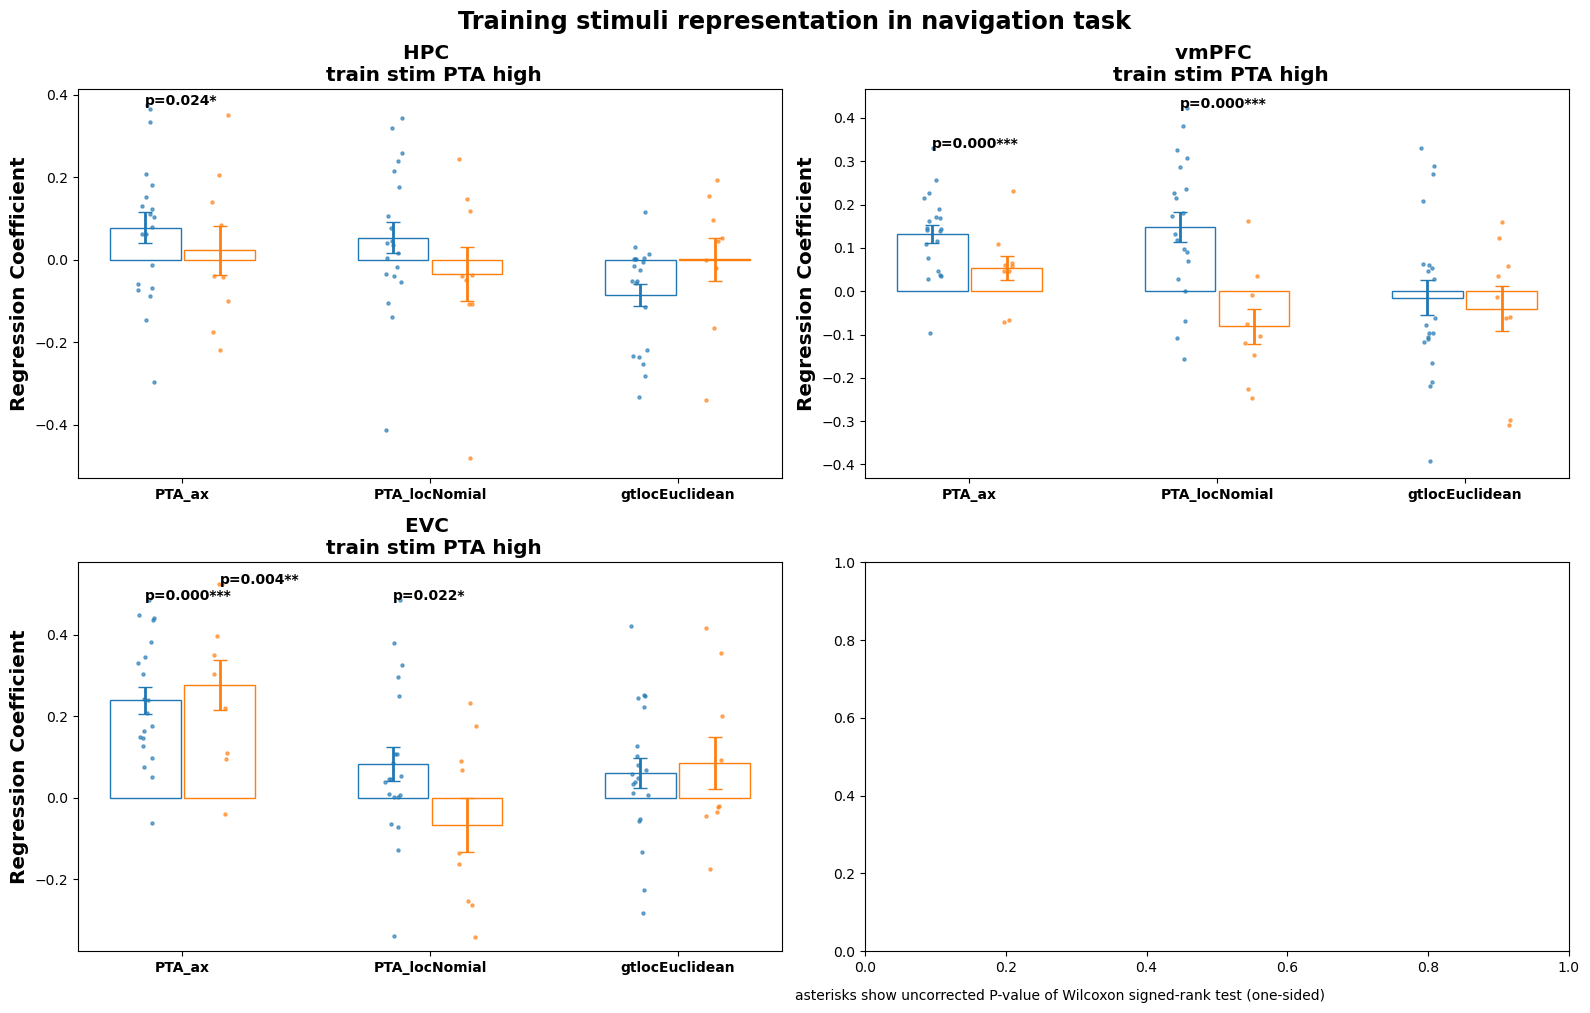

In [161]:
pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
hue_dict = dict(zip(np.unique(res_df["subgroup"]),sns.color_palette(None,2)))
intersted_rdms=["gtlocEuclidean","feature","stimuligroup","PTA","PTA_locNomial","PTA_locEuc","PTA_ax","PTA_locRevNomial","PTA_locRevEuc"]
plt_df = res_df[res_df.modelrdm.isin(intersted_rdms)]
plt_df["region"] = pd.Categorical(plt_df.region,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
fig,axes = plt.subplots(prows,pcols,figsize=(8*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(plt_df.groupby("region")):
    roi_df = roi_df[roi_df.analysis=='train stim PTA high'].copy().reset_index(drop=True)
    for jana,(aname,ana_df) in enumerate(roi_df.groupby("analysis")):
        y_lim = np.array([np.min(ana_df.coefficient),np.max(ana_df.coefficient)])*1.1
        dodge_group = 0.15
        xdev = [-dodge_group,dodge_group]
        modelrdm_names = np.unique(ana_df["modelrdm"])
        n_modelrdms = modelrdm_names.size
        x_centers=np.arange(n_modelrdms)
        for kg,(gname,g_df) in enumerate(ana_df.groupby("subgroup")):
            x_locs = dict(zip(modelrdm_names,x_centers+xdev[kg]))
            for mname,xloc in x_locs.items():   
                y = g_df[g_df.modelrdm==mname]["coefficient"].to_numpy()
                jitt_x = np.random.random(y.shape)*.5*dodge_group - .5*dodge_group/2
                pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
                axes.flatten()[iroi].text(x=xloc, y=np.max(y),s=gen_pval_annot(pval),fontweight="bold")
                axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
                axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*1.9,label=gname,
                                    color='None',edgecolor=hue_dict[gname])
                axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                    barsabove=True,
                                    ecolor=hue_dict[gname],alpha=1,linewidth=2)
        axes.flatten()[iroi].set_xticks(ticks=np.arange(n_modelrdms),
                                        labels=modelrdm_names,
                                        fontweight="bold")
        axes.flatten()[iroi].set_ylim(y_lim)
        axes.flatten()[iroi].set_ylabel("Regression Coefficient", fontweight="bold",fontsize="x-large")
        axes.flatten()[iroi].set_title(f"{roi} \n train stim PTA high",fontweight="bold",fontsize="x-large")
        axes.flatten()[iroi].legend().remove()
fig.suptitle("Training stimuli representation in navigation task", fontweight="bold",fontsize="xx-large")
fig.text(x=0.5, y=-.01, s='asterisks show uncorrected P-value of Wilcoxon signed-rank test (one-sided)')
fig.tight_layout()

In [ ]:
pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
hue_dict = dict(zip(np.unique(res_df["subgroup"]),sns.color_palette(None,2)))
intersted_rdms=["gtlocEuclidean","feature","stimuligroup","PTA","PTA_locNomial","PTA_locEuc","PTA_ax","PTA_locRevNomial","PTA_locRevEuc"]
plt_df = res_df[res_df.modelrdm.isin(intersted_rdms)]
plt_df = plt_df[plt_df.side=="bilateral"]
plt_df["region"] = pd.Categorical(plt_df.region,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
fig,axes = plt.subplots(prows,pcols,figsize=(8*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(plt_df.groupby("region")):
    roi_df = roi_df[roi_df.analysis==f'train stim PTA low'].copy().reset_index(drop=True)
    for jana,(aname,ana_df) in enumerate(roi_df.groupby("analysis")):
        y_lim = np.array([np.min(ana_df.coefficient),np.max(ana_df.coefficient)])*1.1
        dodge_group = 0.15
        xdev = [-dodge_group,dodge_group]
        modelrdm_names = np.unique(ana_df["modelrdm"])
        n_modelrdms = modelrdm_names.size
        x_centers=np.arange(n_modelrdms)
        for kg,(gname,g_df) in enumerate(ana_df.groupby("subgroup")):
            x_locs = dict(zip(modelrdm_names,x_centers+xdev[kg]))
            for mname,xloc in x_locs.items():   
                y = g_df[g_df.modelrdm==mname]["coefficient"].to_numpy()
                jitt_x = np.random.random(y.shape)*.5*dodge_group - .5*dodge_group/2
                pval = scipy.stats.ttest_1samp(y,0,alternative="greater").pvalue                
                axes.flatten()[iroi].text(x=xloc, y=np.max(y),s=gen_pval_annot(pval*4),fontweight="bold")
                axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
                axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*1.9,label=gname,
                                    color='None',edgecolor=hue_dict[gname])
                axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                    barsabove=True,
                                    ecolor=hue_dict[gname],alpha=1,linewidth=2)
        axes.flatten()[iroi].set_xticks(ticks=np.arange(n_modelrdms),
                                        labels=modelrdm_names,
                                        fontweight="bold")
        axes.flatten()[iroi].set_ylim(y_lim)
        axes.flatten()[iroi].set_title(f"{roi} \n train stim PTA low",fontweight="bold",fontsize="x-large")
        axes.flatten()[iroi].legend().remove()
fig.tight_layout()

#### compare to pure location representation

In [610]:
res_df_list = []
for roi in rois:
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        preprocedX = deepcopy(subdata["preprocX"])#deepcopy(subdata["rawX"])#
        stimdf = subdata["stimdf"]
        
        lzer_filter = np.all(
            np.vstack([stimdf.taskname.to_numpy() == "localizer",
                       [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]),
                       axis=0
        )

        lzer_X = preprocedX[lzer_filter,:]
        
        stim_dict = stimdf[lzer_filter].copy().reset_index(drop=True).to_dict('list')
        submodelrdm = ModelRDM(
            stimid    = stim_dict["stim_id"],
            stimgtloc = np.vstack([stim_dict["stim_x"],stim_dict["stim_y"]]).T,
            stimfeature = np.vstack([stim_dict["stim_color"],stim_dict["stim_shape"]]).T,
            stimgroup = stim_dict["stim_group"],
            sessions = stim_dict["stim_session"],
            nan_identity = False,
            splitgroup  = True
        )

        prim_reg_names = ["gtlocEuclidean","feature"]
        
        analyses = [
            {"name": "PTA low D Compete",
            "reg_names": ["PTA_ax", "PTA_locEuc", "gtlocEuclidean"],
            "short_names":  ["PTA_ax","PTA_locEuc", "gtlocEuclidean"]
            },
            {"name": "PTA high D Compete",
            "reg_names": ["PTA_ax","PTA_locNomial", "gtlocEuclidean"],
            "short_names":  ["PTA_ax","PTA_locNomial", "gtlocEuclidean"]
            }
        ]
        
        for analysis_dict in analyses:
            reg_names, short_names = analysis_dict["reg_names"], analysis_dict["short_names"]
            reg_vals  = [submodelrdm.models[k] for k in reg_names]
            reg_estimator  = MultipleRDMRegression(lzer_X,
                                                   modelrdms=reg_vals,
                                                   modelnames=short_names,
                                                   rdm_metric="correlation")
            reg_estimator.fit()
            res_df = pd.DataFrame(
                {"modelrdm":   reg_estimator.modelnames,
                "coefficient": reg_estimator.result}
            ).assign(
            roi = roi,
            subid=subid,
            subgroup=subgroup,
            analysis = analysis_dict["name"]
            )
            res_df_list.append(res_df)


In [443]:
pd.DataFrame(stim_dict)

stim_id  stim_group  stim_session  stim_x  stim_y  stim_color  stim_shape  \
0        2           1           4.0    -1.0     0.0           3           2   
1        7           1           4.0    -0.5     0.0           3           1   
2       10           1           4.0     0.0    -1.0           1           0   
3       11           1           4.0     0.0    -0.5           2           0   
4       13           1           4.0     0.0     0.5           0           0   
5       14           1           4.0     0.0     1.0           4           0   
6       17           1           4.0     0.5     0.0           3           3   
7       22           1           4.0     1.0     0.0           3           4   

   stim_xsign  stim_ysign  stim_xdist  ...    resp_x    resp_y  resp_xsign  \
0        -1.0         0.0         1.0  ... -1.377184 -0.086314        -1.0   
1        -1.0         0.0         0.5  ... -0.765755 -0.031439        -1.0   
2         0.0        -1.0         0.0  ... -0.046346 -1.312464        -1.0   
3         0.0        -1.0         0.0  ... -0.106669 -0.578103        -1.0   
4         0.0         1.0         0.0  ... -0.018514  0.724966        -1.0   
5         0.0         1.0         0.0  ...  0.019823  1.263044         1.0   
6         1.0         0.0         0.5  ...  0.518671 -0.018295         1.0   
7         1.0         0.0         1.0  ...  1.209048 -0.125382         1.0   

   resp_ysign  resp_xdist  resp_ydist  training_axset  training_axloc  \
0        -1.0    1.377184    0.086314             0.0            -1.0   
1        -1.0    0.765755    0.031439             0.0            -0.5   
2        -1.0    0.046346    1.312464             1.0            -1.0   
3        -1.0    0.106669    0.578103             1.0            -0.5   
4         1.0    0.018514    0.724966             1.0             0.5   
5         1.0    0.019823    1.263044             1.0             1.0   
6        -1.0    0.518671    0.018295             0.0             0.5   
7        -1.0    1.209048    0.125382             0.0             1.0   

   training_axlocRev   taskname  
0               -1.0  localizer  
1               -0.5  localizer  
2                1.0  localizer  
3                0.5  localizer  
4               -0.5  localizer  
5               -1.0  localizer  
6                0.5  localizer  
7                1.0  localizer  

[8 rows x 23 columns]

In [611]:
res_df = pd.concat(res_df_list,axis=0).reset_index(drop=True)
res_df[["region","side"]] = res_df.roi.str.split("_",expand=True)
print(res_df.shape)
print(f"unique analysis names: {np.unique(res_df.analysis)}")
print(f"unique modelrdm names: {np.unique(res_df.modelrdm)}")
res_df.head(5)


(696, 8)
unique analysis names: ['PTA high D Compete' 'PTA low D Compete']
unique modelrdm names: ['PTA_ax' 'PTA_locEuc' 'PTA_locNomial' 'gtlocEuclidean']


modelrdm  coefficient            roi   subid     subgroup  \
0          PTA_ax    -0.095967  HPC_bilateral  sub001  Generalizer   
1      PTA_locEuc    -0.232279  HPC_bilateral  sub001  Generalizer   
2  gtlocEuclidean     0.104902  HPC_bilateral  sub001  Generalizer   
3          PTA_ax    -0.098006  HPC_bilateral  sub001  Generalizer   
4   PTA_locNomial    -0.115135  HPC_bilateral  sub001  Generalizer   

             analysis region       side  
0   PTA low D Compete    HPC  bilateral  
1   PTA low D Compete    HPC  bilateral  
2   PTA low D Compete    HPC  bilateral  
3  PTA high D Compete    HPC  bilateral  
4  PTA high D Compete    HPC  bilateral

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_30600\336371475.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



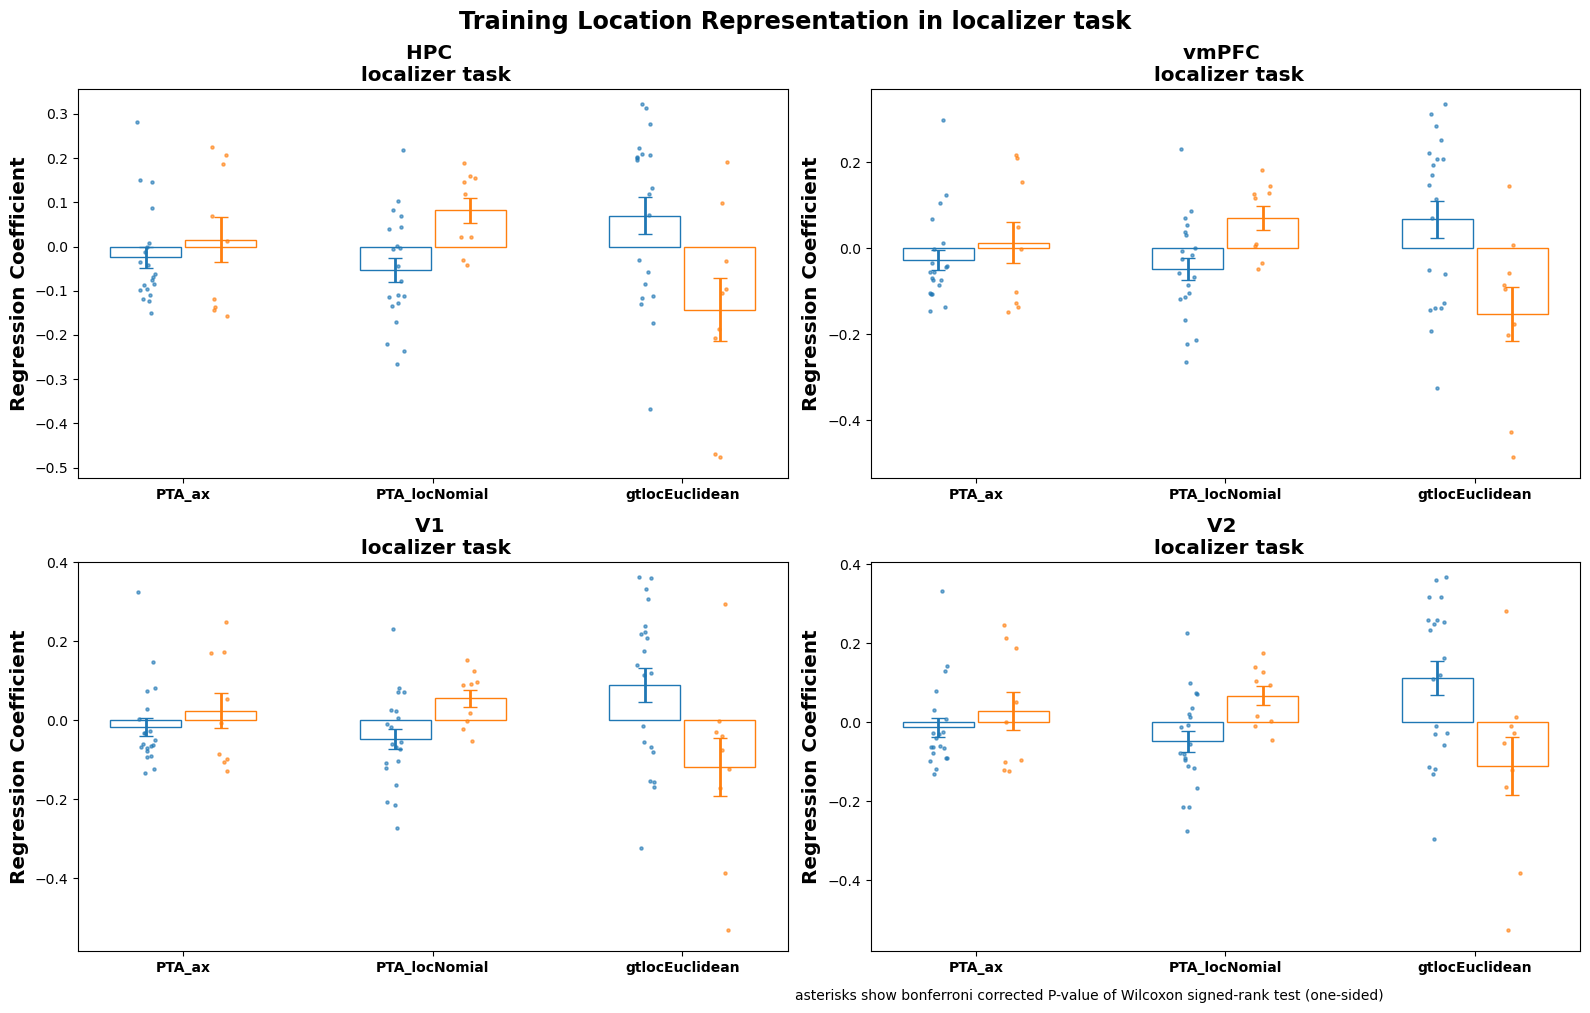

In [612]:
pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
hue_dict = dict(zip(np.unique(res_df["subgroup"]),sns.color_palette(None,2)))
intersted_rdms=["gtlocEuclidean","feature","stimuligroup","PTA","PTA_locNomial","PTA_locEuc","PTA_ax","PTA_locRevNomial","PTA_locRevEuc"]
plt_df = res_df[res_df.modelrdm.isin(intersted_rdms)]
plt_df = plt_df[plt_df["side"] == "bilateral"].copy().reset_index(drop=True)
plt_df["region"] = pd.Categorical(plt_df.region,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
fig,axes = plt.subplots(prows,pcols,figsize=(8*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(plt_df.groupby("region")):
    roi_df = roi_df[roi_df.analysis=='PTA high D Compete'].copy().reset_index(drop=True)
    for jana,(aname,ana_df) in enumerate(roi_df.groupby("analysis")):
        y_lim = np.array([np.min(ana_df.coefficient),np.max(ana_df.coefficient)])*1.1
        dodge_group = 0.15
        xdev = [-dodge_group,dodge_group]
        modelrdm_names = np.unique(ana_df["modelrdm"])
        n_modelrdms = modelrdm_names.size
        x_centers=np.arange(n_modelrdms)
        for kg,(gname,g_df) in enumerate(ana_df.groupby("subgroup")):
            x_locs = dict(zip(modelrdm_names,x_centers+xdev[kg]))
            for mname,xloc in x_locs.items():   
                y = g_df[g_df.modelrdm==mname]["coefficient"].to_numpy()
                jitt_x = np.random.random(y.shape)*.5*dodge_group - .5*dodge_group/2
                pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
                axes.flatten()[iroi].text(x=xloc, y=np.max(y),s=gen_pval_annot(pval*8),fontweight="bold")
                axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
                axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*1.9,label=gname,
                                    color='None',edgecolor=hue_dict[gname])
                axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                    barsabove=True,
                                    ecolor=hue_dict[gname],alpha=1,linewidth=2)
        axes.flatten()[iroi].set_xticks(ticks=np.arange(n_modelrdms),
                                        labels=modelrdm_names,
                                        fontweight="bold")
        axes.flatten()[iroi].set_ylim(y_lim)
        axes.flatten()[iroi].set_title(f"{roi} \n localizer task",fontweight="bold",fontsize="x-large")
        axes.flatten()[iroi].legend().remove()
        axes.flatten()[iroi].set_ylabel("Regression Coefficient",fontweight="bold",fontsize="x-large")
        

fig.suptitle("Training Location Representation in localizer task", fontweight="bold",fontsize="xx-large")
fig.text(x=0.5, y=-.01, s='asterisks show bonferroni corrected P-value of Wilcoxon signed-rank test (one-sided)')
fig.tight_layout()

## PS score

In [323]:
def parallel_axes_cosine_sim(xstims,ystims):
    assert xstims.shape[0] == ystims.shape[0]
    nloc = xstims.shape[0]
    x_coding_dirs = np.full((nloc,nloc,xstims.shape[1]),fill_value=np.nan)
    y_coding_dirs = np.full((nloc,nloc,xstims.shape[1]),fill_value=np.nan)
    xycosinesim   = np.full((nloc,nloc),fill_value=np.nan)
    for idx1 in range(nloc):
        for idx2 in range(nloc):
            if idx1 < idx2:
                x_coding_dirs[idx1,idx2] = xstims[idx1] - xstims[idx2]
                y_coding_dirs[idx1,idx2] = ystims[idx1] - ystims[idx2]
                xycosinesim[idx1,idx2] = 1-scipy.spatial.distance.cosine(x_coding_dirs[idx1,idx2],y_coding_dirs[idx1,idx2])
    return xycosinesim

def parallel_axes_regcoefcorr(axlocs,xstims,ystims):
    assert xstims.shape[0] == ystims.shape[0]
    assert xstims.shape[0] == axlocs.size
    
    uniloc = np.unique(axlocs)
    axlocsstr = np.array(['%d' % (l*2) for l in axlocs])
    nloc = uniloc.shape[0]
    # xyregcoefcorr   = np.full((nloc,nloc),fill_value=np.nan)
    # for idx1 in range(nloc):
    #     for idx2 in range(nloc):
    #         if idx1 < idx2:
    #             row_ids = np.any(np.vstack([axlocs == uniloc[idx1],
    #                                         axlocs == uniloc[idx2]]),axis=0)
    #             xreg = LogisticRegression(penalty=None,tol=1e-10).fit(xstims[row_ids],axlocsstr[row_ids])
    #             yreg = LogisticRegression(penalty=None,tol=1e-10).fit(ystims[row_ids],axlocsstr[row_ids])
    #             xyregcoefcorr[idx1,idx2] =  scipy.stats.pearsonr(xreg.coef_.flatten(),yreg.coef_.flatten()).statistic
    
    xreg = LogisticRegression(penalty=None).fit(xstims,axlocsstr)
    yreg = LogisticRegression(penalty=None).fit(ystims,axlocsstr)
    xyregcoefcorr =  scipy.stats.pearsonr(xreg.coef_.flatten(),yreg.coef_.flatten()).statistic
    return xyregcoefcorr


#### with decoding on raw activity pattern

In [324]:
fname = 'training_nocenter'
sub_daxps_perms = {}
sub_daxps_obs = {}
for roi in rois:
    rng = np.random.default_rng()                
    #if "bilateral" in roi:
    sub_daxps_perms[roi] = []
    sub_daxps_obs[roi] = []
    for subX,subdf,subid in zip(sub_patterns[fname][roi],sub_stimdfs[fname][roi],subid_list):
        subX_preproced = scale_feature(subX,1,standardize=False)
        print(f"{roi} - {subid}",end="\r",flush=True)
        axlocs = np.unique(subdf.training_axloc)

        assert all([np.sum(subdf.stim_x == j)==1 for j in axlocs])
        assert all([np.sum(subdf.stim_y == j)==1 for j in axlocs])
        # pick x stims and ordered them by -2, -1,  1, 2
        xstims = np.array([subX_preproced[subdf.stim_x == j,:][0] for j in axlocs])
        ystims = np.array([subX_preproced[subdf.stim_y == j,:][0] for j in axlocs])
        
        obs = np.nanmean(parallel_axes_regcoefcorr(axlocs,xstims,ystims))
        permutations = []
        n_perm  = 1000
        for p in range(n_perm):
            p_idx = np.hstack([rng.permutation(axlocs.size),np.arange(axlocs.size)+axlocs.size])
            permX = subX_preproced[p_idx,:]
            permX = subX_preproced[rng.permutation(permX.shape[0]),:]
            
            perm_xstims = np.array([permX[subdf.stim_x == j,:][0] for j in axlocs])
            perm_ystims = np.array([permX[subdf.stim_y == j,:][0] for j in axlocs])

            permutations.append(np.nanmean(parallel_axes_cosine_sim(perm_xstims,perm_ystims)))
        sub_daxps_perms[roi].append(permutations)
        sub_daxps_obs[roi].append(obs)


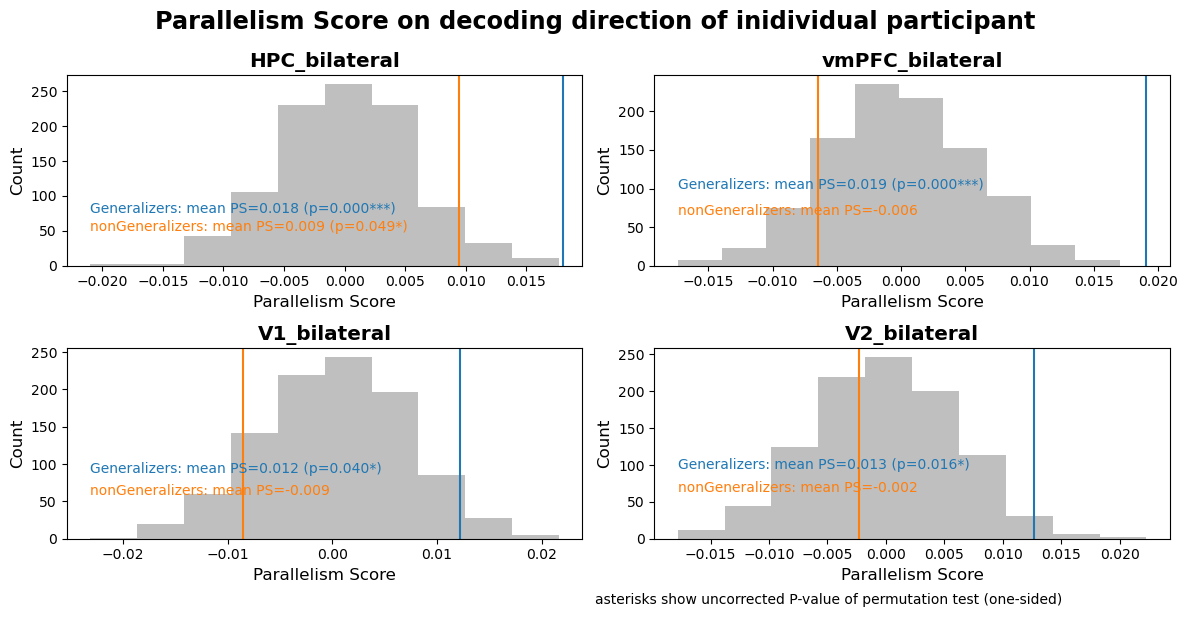

In [326]:
fig_cs,axes_cs = plt.subplots(2,2,figsize=(12,6))
GnG_colors = sns.color_palette(None,2)
        
for j,roi in enumerate(rois):
        cs_null = np.array(sub_daxps_perms[roi]).mean(axis=0)
        cs_null_G = np.array([csn for csn,subid in zip(sub_daxps_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
        cs_null_NG = np.array([csn for csn,subid in zip(sub_daxps_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)
        

        hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null,color="grey",label="null",alpha=0.5)
        #hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null_G,color="lightsteelblue",label="Gnull",alpha=0.5)
        #hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null_NG,color="bisque",label="NGnull",alpha=0.5)
        G_csmu = np.mean([cs for cs,subid in zip(sub_daxps_obs[roi],subid_list) if subid in generalizers])
        axes_cs.flatten()[j].axvline(x=G_csmu,color=GnG_colors[0],label="Generalizers")
        NG_csmu = np.mean([cs for cs,subid in zip(sub_daxps_obs[roi],subid_list) if subid in nongeneralizers])
        axes_cs.flatten()[j].axvline(x=NG_csmu,color=GnG_colors[1], label="nonGeneralizers")
        Gp = (1 - np.mean([G_csmu>csn for csn in cs_null]))
        NGp = (1 - np.mean([NG_csmu>csn for csn in cs_null]))
        if Gp<0.05:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*1.2,f"Generalizers: mean PS={'%.3f' % G_csmu} ({gen_pval_annot(Gp)})",color=GnG_colors[0])
        else:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*1.2,f"Generalizers: mean PS={'%.3f' % G_csmu}",color=GnG_colors[0])
        if NGp<0.05:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*0.8,f"nonGeneralizers: mean PS={'%.3f' % NG_csmu} ({gen_pval_annot(NGp)})",color=GnG_colors[1])
        else:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*0.8,f"nonGeneralizers: mean PS={'%.3f' % NG_csmu}",color=GnG_colors[1]) 
        axes_cs.flatten()[j].set_title(roi,fontweight="bold",fontsize="x-large")
        axes_cs.flatten()[j].set_xlabel("Parallelism Score",fontsize="large")
        axes_cs.flatten()[j].set_ylabel("Count",fontsize="large")

fig_cs.text(x=0.5, y=-.01, s='asterisks show uncorrected P-value of permutation test (one-sided)')
fig_cs.suptitle("Parallelism Score on decoding direction of inidividual participant",fontweight="bold",fontsize="xx-large")
fig_cs.tight_layout()

#### On raw activity pattern

In [50]:
fname = 'training_nocenter'
sub_cs_perms = {}
sub_cs_obs = {}
for roi in rois:
    rng = np.random.default_rng()                
    #if "bilateral" in roi:
    sub_cs_perms[roi] = []
    sub_cs_obs[roi] = []
    for subX,subdf,subid in zip(sub_patterns[fname][roi],sub_stimdfs[fname][roi],subid_list):
        subX_preproced = scale_feature(subX,2,standardize=False)
        print(f"{roi} - {subid}",end="\r",flush=True)
        axlocs = np.unique(subdf.training_axloc)

        assert all([np.sum(subdf.stim_x == j)==1 for j in axlocs])
        assert all([np.sum(subdf.stim_y == j)==1 for j in axlocs])
        # pick x stims and ordered them by -2, -1,  1, 2
        xstims = np.array([subX_preproced[subdf.stim_x == j,:][0] for j in axlocs])
        ystims = np.array([subX_preproced[subdf.stim_y == j,:][0] for j in axlocs])
        
        obs = np.nanmean(parallel_axes_cosine_sim(xstims,ystims))
        permutations = []
        n_perm  = 1000
        for p in range(n_perm):
            p_idx = np.hstack([rng.permutation(axlocs.size),np.arange(axlocs.size)+axlocs.size])
            permX = subX_preproced[p_idx,:]
            permX = subX_preproced[rng.permutation(permX.shape[0]),:]
            
            perm_xstims = np.array([permX[subdf.stim_x == j,:][0] for j in axlocs])
            perm_ystims = np.array([permX[subdf.stim_y == j,:][0] for j in axlocs])

            permutations.append(np.nanmean(parallel_axes_cosine_sim(perm_xstims,perm_ystims)))
        sub_cs_perms[roi].append(permutations)
        sub_cs_obs[roi].append(obs)


In [907]:
np.rad2deg(np.arccos(0.19))

79.04721580110888

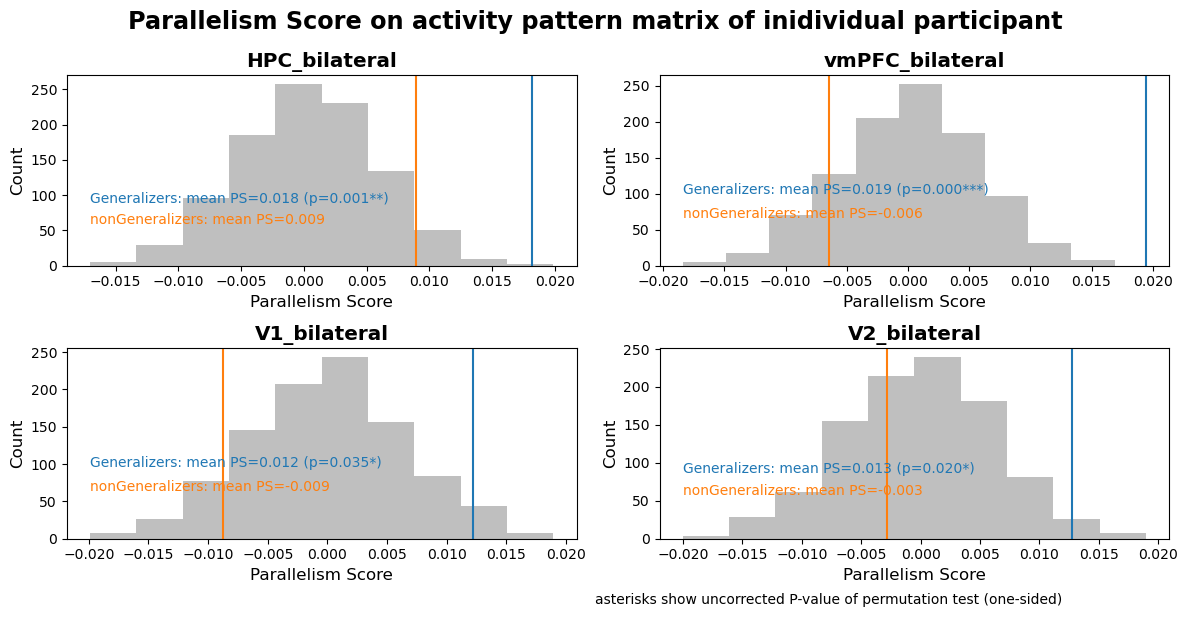

In [73]:
fig_cs,axes_cs = plt.subplots(2,2,figsize=(12,6))
GnG_colors = sns.color_palette(None,2)
#for j,broi in enumerate(base_rois):
#    for s in ["bilateral"]:#,"left","right"]:
#    roi = f"{broi}_{s}"
        
for j,roi in enumerate(rois):
        cs_null = np.array(sub_cs_perms[roi]).mean(axis=0)
        cs_null_G = np.array([csn for csn,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
        cs_null_NG = np.array([csn for csn,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)
        

        hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null,color="grey",label="null",alpha=0.5)
        #hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null_G,color="lightsteelblue",label="Gnull",alpha=0.5)
        #hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null_NG,color="bisque",label="NGnull",alpha=0.5)
        G_csmu = np.mean([cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers])
        axes_cs.flatten()[j].axvline(x=G_csmu,color=GnG_colors[0],label="Generalizers")
        NG_csmu = np.mean([cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers])
        axes_cs.flatten()[j].axvline(x=NG_csmu,color=GnG_colors[1], label="nonGeneralizers")
        Gp = (1 - np.mean([G_csmu>csn for csn in cs_null]))
        NGp = (1 - np.mean([NG_csmu>csn for csn in cs_null]))
        if Gp<0.05:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*1.2,f"Generalizers: mean PS={'%.3f' % G_csmu} ({gen_pval_annot(Gp)})",color=GnG_colors[0])
        else:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*1.2,f"Generalizers: mean PS={'%.3f' % G_csmu}",color=GnG_colors[0])
        if NGp<0.05:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*0.8,f"nonGeneralizers: mean PS={'%.3f' % NG_csmu} ({gen_pval_annot(NGp)})",color=GnG_colors[1])
        else:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*0.8,f"nonGeneralizers: mean PS={'%.3f' % NG_csmu}",color=GnG_colors[1]) 
        axes_cs.flatten()[j].set_title(roi,fontweight="bold",fontsize="x-large")
        axes_cs.flatten()[j].set_xlabel("Parallelism Score",fontsize="large")
        axes_cs.flatten()[j].set_ylabel("Count",fontsize="large")

fig_cs.text(x=0.5, y=-.01, s='asterisks show uncorrected P-value of permutation test (one-sided)')
fig_cs.suptitle("Parallelism Score on activity pattern matrix of inidividual participant",fontweight="bold",fontsize="xx-large")
fig_cs.tight_layout()


In [75]:
sub_csrev_perms = {}
sub_csrev_obs = {}
for roi in rois:
    rng = np.random.default_rng()                
    if "bilateral" in roi:
        sub_csrev_perms[roi] = []
        sub_csrev_obs[roi] = []
        for subX,subdf,subid in zip(sub_patterns[fname][roi],sub_stimdfs[fname][roi],subid_list):
            subX_preproced = PCA().fit_transform(subX)
            print(f"{roi} - {subid}",end="\r",flush=True)
            axlocs = np.unique(subdf.training_axloc)

            assert all([np.sum(subdf.stim_x == j)==1 for j in axlocs])
            assert all([np.sum(subdf.stim_y == j)==1 for j in axlocs])
            # pick x stims and ordered them by -2, -1,  1, 2
            xstims = np.array([subX_preproced[subdf.stim_x == j,:][0] for j in axlocs])
            ystims = np.array([subX_preproced[subdf.stim_y == j,:][0] for j in list(reversed(axlocs))])
            
            obs = np.nanmean(parallel_axes_cosine_sim(xstims,ystims))
            permutations = []
            n_perm  = 1000
            for p in range(n_perm):
                p_idx = np.hstack([rng.permutation(axlocs.size),np.arange(axlocs.size)+axlocs.size])
                permX = subX_preproced[p_idx,:]
                #permX = subX_preproced[rng.permutation(permX.shape[0]),:]
                
                perm_xstims = np.array([permX[subdf.stim_x == j,:][0] for j in axlocs])
                perm_ystims = np.array([permX[subdf.stim_y == j,:][0] for j in list(reversed(axlocs))])

                permutations.append(np.nanmean(parallel_axes_cosine_sim(perm_xstims,perm_ystims)))
            sub_csrev_perms[roi].append(permutations)
            sub_csrev_obs[roi].append(obs)

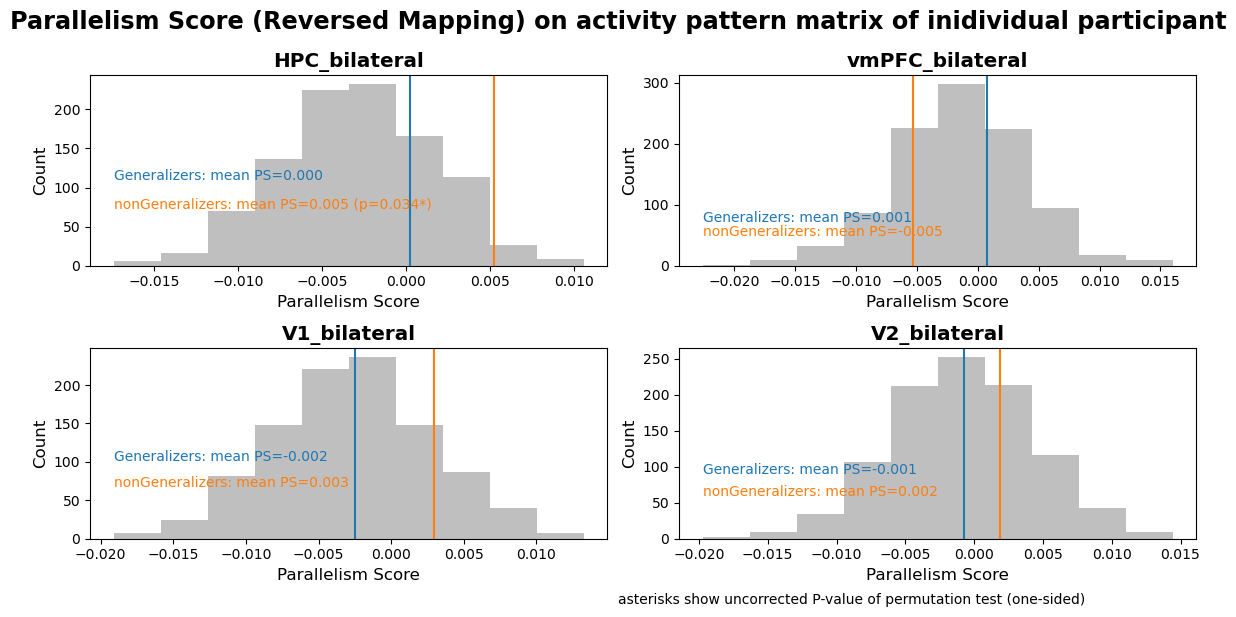

In [76]:
fig_cs,axes_cs = plt.subplots(2,2,figsize=(12,6))
GnG_colors = sns.color_palette(None,2)
#for j,broi in enumerate(base_rois):
#    for s in ["bilateral"]:#,"left","right"]:
#    roi = f"{broi}_{s}"
        
for j,roi in enumerate(rois):
        cs_null = np.array(sub_csrev_perms[roi]).mean(axis=0)
        cs_null_G = np.array([csn for csn,subid in zip(sub_csrev_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
        cs_null_NG = np.array([csn for csn,subid in zip(sub_csrev_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)
        

        hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null,color="grey",label="null",alpha=0.5)
        #hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null_G,color="lightsteelblue",label="Gnull",alpha=0.5)
        #hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null_NG,color="bisque",label="NGnull",alpha=0.5)
        G_csmu = np.mean([cs for cs,subid in zip(sub_csrev_obs[roi],subid_list) if subid in generalizers])
        axes_cs.flatten()[j].axvline(x=G_csmu,color=GnG_colors[0],label="Generalizers")
        NG_csmu = np.mean([cs for cs,subid in zip(sub_csrev_obs[roi],subid_list) if subid in nongeneralizers])
        axes_cs.flatten()[j].axvline(x=NG_csmu,color=GnG_colors[1], label="nonGeneralizers")
        Gp = (1 - np.mean([G_csmu>csn for csn in cs_null]))
        NGp = (1 - np.mean([NG_csmu>csn for csn in cs_null]))
        if Gp<0.05:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*1.2,f"Generalizers: mean PS={'%.3f' % G_csmu} ({gen_pval_annot(Gp)})",color=GnG_colors[0])
        else:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*1.2,f"Generalizers: mean PS={'%.3f' % G_csmu}",color=GnG_colors[0])
        if NGp<0.05:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*0.8,f"nonGeneralizers: mean PS={'%.3f' % NG_csmu} ({gen_pval_annot(NGp)})",color=GnG_colors[1])
        else:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*0.8,f"nonGeneralizers: mean PS={'%.3f' % NG_csmu}",color=GnG_colors[1]) 
        axes_cs.flatten()[j].set_title(roi,fontweight="bold",fontsize="x-large")
        axes_cs.flatten()[j].set_xlabel("Parallelism Score",fontsize="large")
        axes_cs.flatten()[j].set_ylabel("Count",fontsize="large")

fig_cs.text(x=0.5, y=-.01, s='asterisks show uncorrected P-value of permutation test (one-sided)')
fig_cs.suptitle("Parallelism Score (Reversed Mapping) on activity pattern matrix of inidividual participant",fontweight="bold",fontsize="xx-large")
fig_cs.tight_layout()


#### On participant MDS

In [55]:
fname = 'training_nocenter'
subMDS_cs_perms = {}
subMDS_cs_obs = {}
eng = matlab.engine.start_matlab()
for roi in rois:
    rng = np.random.default_rng()                
    #if "bilateral" in roi:
    subMDS_cs_perms[roi] = []
    subMDS_cs_obs[roi] = []
    reordered_subrdms = []
    for subX,sdf,subid in zip(sub_patterns[fname][roi],sub_stimdfs[fname][roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subdf = sdf.sort_values(by=['training_axset', 'training_axloc'])
        new_order = subdf.index
        
        subX_preproced = np.array(eng.cmdscale(compute_rdm(subX[new_order,:],"correlation"),3))
        
    
        #subX_preproced = PCA().fit_transform(subX)[:,:3]
        axlocs = np.unique(subdf.training_axloc)

        assert all([np.sum(subdf.stim_x == j)==1 for j in axlocs])
        assert all([np.sum(subdf.stim_y == j)==1 for j in axlocs])
        # pick x stims and ordered them by -2, -1,  1, 2
        xstims = np.array([subX_preproced[subdf.stim_x == j,:][0] for j in axlocs])
        ystims = np.array([subX_preproced[subdf.stim_y == j,:][0] for j in axlocs])
        
        obs = np.nanmean(parallel_axes_cosine_sim(xstims,ystims))
        permutations = []
        n_perm  = 1000
        for p in range(n_perm):
            p_idx = np.hstack([rng.permutation(axlocs.size),np.arange(axlocs.size)+axlocs.size])
            permX = subX_preproced[p_idx,:]
            permX = subX_preproced[rng.permutation(permX.shape[0]),:]
            
            perm_xstims = np.array([permX[subdf.stim_x == j,:][0] for j in axlocs])
            perm_ystims = np.array([permX[subdf.stim_y == j,:][0] for j in axlocs])

            permutations.append(np.nanmean(parallel_axes_cosine_sim(perm_xstims,perm_ystims)))
        subMDS_cs_perms[roi].append(permutations)
        subMDS_cs_obs[roi].append(obs)
eng.quit()

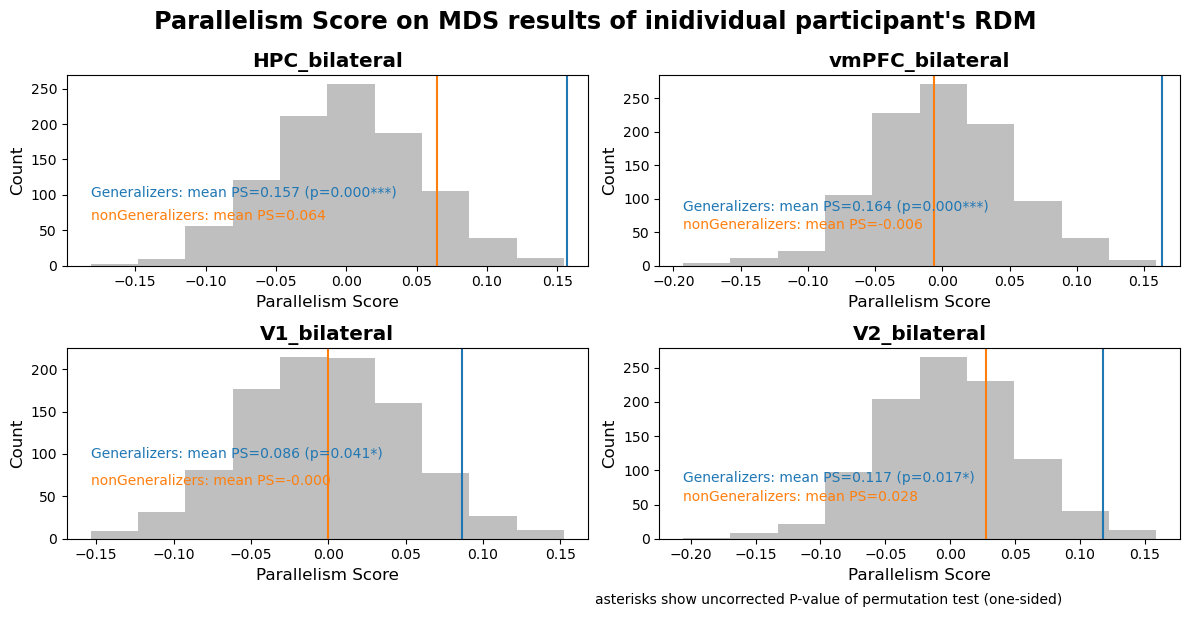

In [74]:
fig_cs,axes_cs = plt.subplots(2,2,figsize=(12,6))
GnG_colors = sns.color_palette(None,2)
#for j,broi in enumerate(base_rois):
#    for s in ["bilateral"]:#,"left","right"]:
#    roi = f"{broi}_{s}"
        
for j,roi in enumerate(rois):
        cs_null = np.array(subMDS_cs_perms[roi]).mean(axis=0)
        cs_null_G = np.array([csn for csn,subid in zip(subMDS_cs_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
        cs_null_NG = np.array([csn for csn,subid in zip(subMDS_cs_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)
        

        hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null,color="grey",label="null",alpha=0.5)
        #hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null_G,color="lightsteelblue",label="Gnull",alpha=0.5)
        #hist_n,hist_bins,_ = axes_cs.flatten()[j].hist(cs_null_NG,color="bisque",label="NGnull",alpha=0.5)
        G_csmu = np.mean([cs for cs,subid in zip(subMDS_cs_obs[roi],subid_list) if subid in generalizers])
        axes_cs.flatten()[j].axvline(x=G_csmu,color=GnG_colors[0],label="Generalizers")
        NG_csmu = np.mean([cs for cs,subid in zip(subMDS_cs_obs[roi],subid_list) if subid in nongeneralizers])
        axes_cs.flatten()[j].axvline(x=NG_csmu,color=GnG_colors[1], label="nonGeneralizers")
        Gp = (1 - np.mean([G_csmu>csn for csn in cs_null]))
        NGp = (1 - np.mean([NG_csmu>csn for csn in cs_null]))
        if Gp<0.05:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*1.2,f"Generalizers: mean PS={'%.3f' % G_csmu} ({gen_pval_annot(Gp)})",color=GnG_colors[0])
        else:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*1.2,f"Generalizers: mean PS={'%.3f' % G_csmu}",color=GnG_colors[0])
        if NGp<0.05:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*0.8,f"nonGeneralizers: mean PS={'%.3f' % NG_csmu} ({gen_pval_annot(NGp)})",color=GnG_colors[1])
        else:
                axes_cs.flatten()[j].text(np.min(hist_bins),np.median(hist_n)*0.8,f"nonGeneralizers: mean PS={'%.3f' % NG_csmu}",color=GnG_colors[1]) 
        axes_cs.flatten()[j].set_title(roi,fontweight="bold",fontsize="x-large")
        axes_cs.flatten()[j].set_xlabel("Parallelism Score",fontsize="large")
        axes_cs.flatten()[j].set_ylabel("Count",fontsize="large")

fig_cs.text(x=0.5, y=-.01, s='asterisks show uncorrected P-value of permutation test (one-sided)')
fig_cs.suptitle("Parallelism Score on MDS results of inidividual participant's RDM",fontweight="bold",fontsize="xx-large")
fig_cs.tight_layout()


### Parameterized model rdm

In [ ]:

def create_unitary_fixedfirst(v):
    """create a unitary matrix with a given first column vector using Householder transformation
    
    Formula:
    https://math.stackexchange.com/a/4160071
    Implementation:
    https://math.stackexchange.com/q/4160055

    Parameters
    ----------
    v : 1d numpy array
        one d numpy array which will be the first column vector

    Returns
    -------
    _type_
        _description_
    """
    if np.ndim(v)==1:
        v = np.atleast_2d(v).T
    elif np.ndim(v)==2:
        v = np.array(v)
    else:
        v = np.atleast_2d(np.array(v).flatten).T
   
    dim = v.size
    # Return identity if v is a multiple of e = (1,0,0,0,0).T
    if v[0,0] and not np.any(v[1:,0]): #v[0,0]: first element is 1; not np.any(v[1:,0]): 2nd to last element are not all zeros
        return np.identity(dim)
    elif not np.any(v):
        return np.zeros((dim,dim))
    e1 = np.zeros((dim,1))
    e1[0] = 1
    w = v/np.linalg.norm(v) - e1
    return np.identity(dim) - 2*((np.dot(w, w.T))/(np.dot(w.T, w)))

def compute_projection_matrix_singlefeature(v,betas,var_ratio):
    var = np.linalg.norm(v)*var_ratio
    one_d_proj   = np.atleast_2d(v).T
    # generate a unitary matrix to perform location-preserving rigid transformation 
    # with p as the first basis, in this way, the original representation will be transformed into 
    # a new coordinate system where the first axis will be the one relevant for readout
    U = create_unitary_fixedfirst(one_d_proj)
    # non-uniform scaling of axis controlled by the compression parameter
    #S = np.array([betas[0],betas[1],betas[2],1-np.sum(betas)])*var
    S = np.array([betas,(1-betas)/3,(1-betas)/3,(1-betas)/3])*var
    # compute the projection matrix
    projection_mat = U*S
    return projection_mat


def compute_compression_matrix_twofeature(beta_x,beta_y,var_ratio,theta,offset):
    """_summary_

    Parameters
    ----------
    beta_x : float
       compression of x
    beta_y : float
       compression of y
    var_ratio: float
        x variance ratio, `var_ratio = var_x/(var_x+var_y)`
    alpha: float
        angle between x and y axis
    nval : int
        number of values in x/y

    Returns
    -------
    numpy.ndarray
        projection matrix
    """
    v = np.array([-2,-1,1,2])
    block_proj_color = compute_projection_matrix_singlefeature(v,beta_x,var_ratio)
    block_proj_shape = compute_projection_matrix_singlefeature(v,beta_y,1-var_ratio)
    proj_xy = np.block([
                [block_proj_color,                                             np.zeros((block_proj_color.shape[0], block_proj_shape.shape[1]))],
                [np.zeros((block_proj_shape.shape[0], block_proj_color.shape[1])), block_proj_shape,                                           ]
                ])
    return proj_xy


def compute_parameterized_rdm_train(
                              vx1,vx2,vx3,
                              vy1,vy2,vy3,
                              var_ratio,theta,
                              feature_twohot,
                              **kwarg):
    # # compr_(train/test)(x/y)
    # compression of x and y axis in train and test

    # # degree of compression and degree of maintaining highD feature representation
    # beta_compr = 0

    proj_xy_train       = compute_compression_matrix_twofeature([vx1,vx2,vx3],[vy1,vy2,vy3],var_ratio)

    stim_mat = feature_twohot@proj_xy_train

    rdm_unscaled = compute_rdm(stim_mat,"euclidean")
    scaledrdm = minmax_scale(rdm_unscaled,newmin=0,newmax=1)
    return stim_mat,scaledrdm

# Relationship between and Test

## Cross train and test stimuli Decoding

In [41]:
analyses = [

    {"name":"predict stim xy cross-validate by train-test split",
     "target_col":["stim_x","stim_y"],
     "splitby_col":"stim_group",
     "chancelvl":0.25
     },

     ]
traintestCCGP_results = []
decoder_weight_corrs = []
for roi in rois:
    if "bilateral" in roi:
        for subdata,subid in zip(roi_data[roi],subid_list):
            print(f"{roi} - {subid}",end="\r",flush=True)            
            for a_config in analyses:
                a_name,target_col,split_by_col = a_config["name"],a_config["target_col"],a_config["splitby_col"]
                subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
                preprocedX = deepcopy(subdata["preprocX"])
                stimdf = subdata["stimdf"]
                non_center_filter = [not all([x==0, y==0]) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]
                
                xydecoders = []
                for j,tcol in enumerate(target_col):
                    navi_filter = np.all(np.vstack([
                                stimdf.taskname.to_numpy() == "navigation",
                                stimdf[tcol]!=0
                                ]),axis=0)

                    
                    currdf = stimdf[navi_filter].copy().reset_index(drop=True)
                    currdf = currdf[currdf.stim_session<=1].copy().reset_index(drop=True)
                    
                    X = preprocedX[navi_filter,:]
                    X = average_flexi_session(preprocedX[navi_filter,:], stimdf[navi_filter].copy().stim_session.to_numpy(),[[0,2],[1,3]])
                    X = scale_feature(X,s_dir=1)
                    
                    targets = np.array([str(int(x*2)) for x in currdf[tcol].to_numpy()]) 
                    split_groups = currdf[split_by_col].to_numpy()
                    gridsearch_groups = currdf["stim_session"].to_numpy()
                    baseclf_kwargs = {'max_iter':1000000}
                    gridsearcg_paramgrid={'tol':np.logspace(-10,-3,num=10),'C':np.logspace(-5,1,num=10)}
                    fit_acc,eval_acc = classifier_gridsearchcv_cv(X,targets,split_groups,
                                    gridsearcg_paramgrid,gridsearch_groups,
                                    baseclf=LogisticRegression,baseclf_kwargs=baseclf_kwargs,
                                    return_splits=False,return_decoder=False)

                    trainingCCGP_res = {"accuracy":[fit_acc,eval_acc],"stage":["fit","eval"]}
                    traintestCCGP_results.append(
                        pd.DataFrame(trainingCCGP_res).assign(roi=roi,subid=subid,subgroup=subgroup,analysis=a_name,predcol = tcol)
                        )
                dcoder_wcorrdf = pd.DataFrame()
                #dcoder_wcorrdf["correlation"] = [scipy.stats.pearsonr(xydecoders[0].coef_.flatten(),xydecoders[1].coef_.flatten()).statistic]
                #[np.mean([scipy.stats.pearsonr(decoders[0].coef_[j,:],decoders[1].coef_[j,:]).statistic for j in range(4)])]
                decoder_weight_corrs.append(
                    dcoder_wcorrdf.assign(roi=roi,subid=subid,subgroup=subgroup,analysis=a_name)
                )
                    
            

In [102]:
traintestCCGP_results_df = pd.concat(traintestCCGP_results).reset_index(drop=True)
traintestCCGP_results_df[["region","side"]] = traintestCCGP_results_df.roi.str.split("_",expand=True)
traintestCCGP_results_df = traintestCCGP_results_df[traintestCCGP_results_df.region!="OFC"].copy().reset_index(drop=True)
traintestCCGP_results_df.region = pd.Categorical(traintestCCGP_results_df.region,
                                                 categories=base_rois,ordered=True)
traintestCCGP_results_df["stage"] = pd.Categorical(traintestCCGP_results_df["stage"],categories=["eval","fit"],ordered=True)


traintestCCGP_results_df["accuracy_above_chance"] = [acc - 0.5 if "predict training axis" in ana else acc - 0.25 for acc,ana in traintestCCGP_results_df[["accuracy","analysis"]].to_numpy()] 
traintestCCGP_results_df["predcol"] = pd.Categorical(traintestCCGP_results_df.predcol,
                                                    categories = ["stim_x","stim_y"],
                                                   ordered=True)
traintestCCGP_results_df.to_csv(os.path.join(ROIRSAdir,"trainingtestCCGP.csv"))


traintestCCGP_results_df

accuracy stage            roi   subid        subgroup  \
0    1.000000   fit  HPC_bilateral  sub001     Generalizer   
1    0.140625  eval  HPC_bilateral  sub001     Generalizer   
2    1.000000   fit  HPC_bilateral  sub001     Generalizer   
3    0.234375  eval  HPC_bilateral  sub001     Generalizer   
4    1.000000   fit  HPC_bilateral  sub002  nonGeneralizer   
..        ...   ...            ...     ...             ...   
459  0.656250  eval   V2_bilateral  sub029     Generalizer   
460  1.000000   fit   V2_bilateral  sub030     Generalizer   
461  0.593750  eval   V2_bilateral  sub030     Generalizer   
462  1.000000   fit   V2_bilateral  sub030     Generalizer   
463  0.468750  eval   V2_bilateral  sub030     Generalizer   

                                              analysis predcol region  \
0    predict stim xy cross-validate by train-test s...  stim_x    HPC   
1    predict stim xy cross-validate by train-test s...  stim_x    HPC   
2    predict stim xy cross-validate by train-test s...  stim_y    HPC   
3    predict stim xy cross-validate by train-test s...  stim_y    HPC   
4    predict stim xy cross-validate by train-test s...  stim_x    HPC   
..                                                 ...     ...    ...   
459  predict stim xy cross-validate by train-test s...  stim_y     V2   
460  predict stim xy cross-validate by train-test s...  stim_x     V2   
461  predict stim xy cross-validate by train-test s...  stim_x     V2   
462  predict stim xy cross-validate by train-test s...  stim_y     V2   
463  predict stim xy cross-validate by train-test s...  stim_y     V2   

          side  accuracy_above_chance  
0    bilateral               0.750000  
1    bilateral              -0.109375  
2    bilateral               0.750000  
3    bilateral              -0.015625  
4    bilateral               0.750000  
..         ...                    ...  
459  bilateral               0.406250  
460  bilateral               0.750000  
461  bilateral               0.343750  
462  bilateral               0.750000  
463  bilateral               0.218750  

[464 rows x 10 columns]

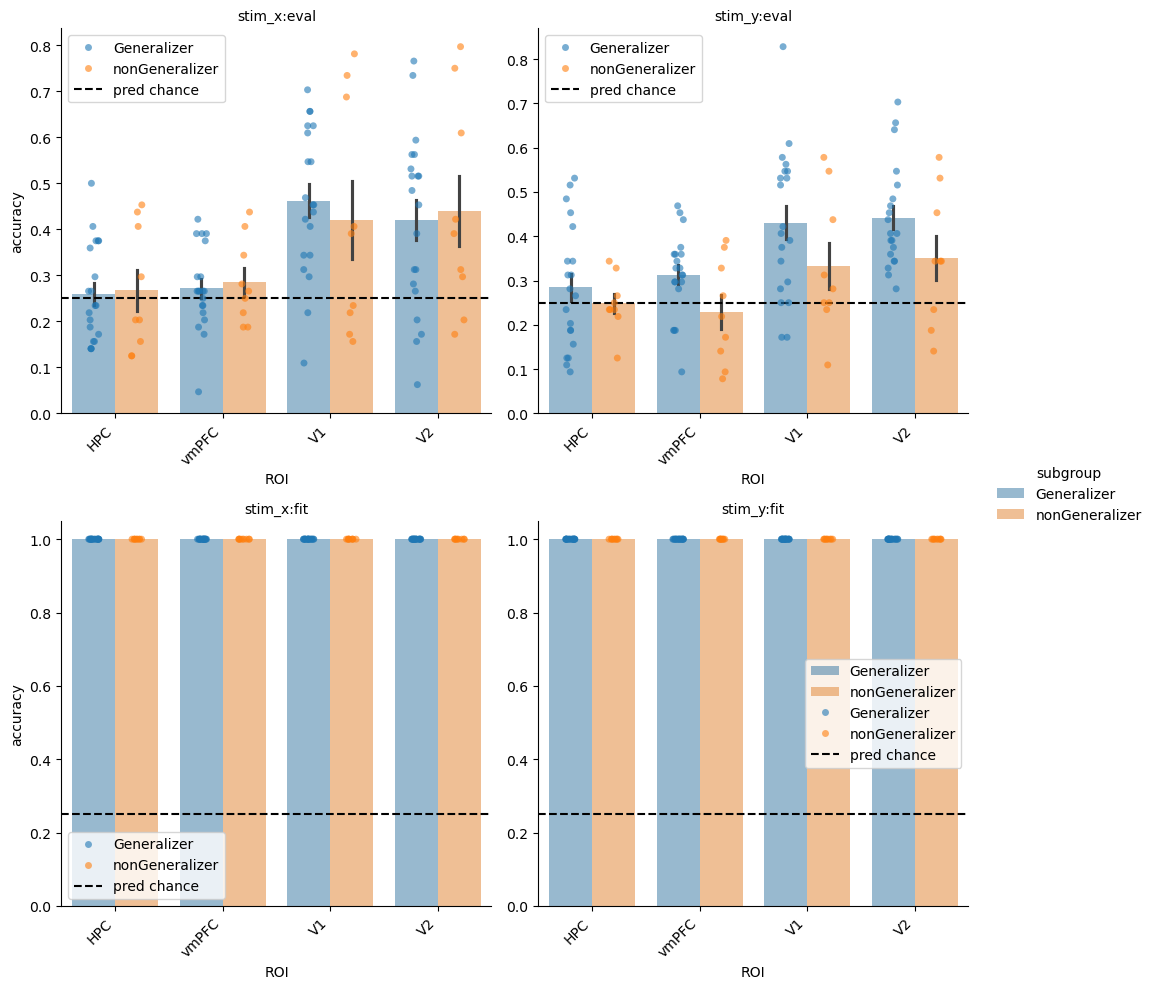

In [104]:
fg_traintestCCGP = sns.catplot(traintestCCGP_results_df[traintestCCGP_results_df.side=="bilateral"],
            x="region",y="accuracy",hue="subgroup",
            hue_order=['Generalizer', 'nonGeneralizer'],palette=sns.color_palette()[:2],
            row="stage", col="predcol",
            kind="bar",errorbar="se",
            alpha=0.5,
            sharey=False)
fg_traintestCCGP.set_titles(template="{col_name}:{row_name}")
fg_traintestCCGP.map(sns.stripplot, 'region', "accuracy", "subgroup", dodge=True, 
                     jitter=0.1,size=5,alpha=0.6,
                     hue_order=['Generalizer', 'nonGeneralizer'],palette=sns.color_palette()[:2],
                     order = base_rois)
for ax in fg_traintestCCGP.axes.flatten():
    ax.axhline(1/4,label="pred chance",color="k",ls='--')
    ax.set_xlabel("ROI",visible=True)
    ax.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha="right")
    #ax.set_aspect(3)
    ax.legend()

fg_traintestCCGP.tight_layout()


In [109]:
xvar, gvar, yvar, yvartest = "region",  "subgroup", "accuracy","accuracy_above_chance"
fig,axes = grouped_barscatter_withstats(traintestCCGP_results_df[traintestCCGP_results_df.stage=="eval"],
                             facet_vars = "predcol", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                             prows=1,pcols=2,
                             statfunc=lambda yt: 1. if np.size(yt)<10 else scipy.stats.wilcoxon(yt,alternative='greater').pvalue)
for ifacet, _ in enumerate(axes.flatten()):
    axes.flatten()[ifacet].set_ylabel("Cross-condition Decoding Accuracy",fontweight="bold",fontsize="large")
    axes.flatten()[ifacet].set_xlabel("ROI",fontweight="bold",fontsize="large")
    axes.flatten()[ifacet].axhline(0.25,label="chance",color="k",ls='--')
    
hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
fig.legend([hs[0],hs[1],hs[-1]],[ls[0],ls[1],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
           prop = dict(weight="bold"))
fig.text(x=0.5, y=0, s='asterisks show uncorrected P-value of Wilcoxon signed-rank test (one-sided)')
fig.tight_layout()

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\1299055837.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  assert prows*pcols>=len(list(enumerate(datadf.groupby(facet_vars))))
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\1299055837.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadf[gvar] = pd.Categorical(datadf[gvar],categories=np.unique(datadf[gvar]))
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\1299055837.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version

In [35]:
from zpyhelper.MVPA.preprocessors import extract_pc,average_flexi_session

analyses = [
    ## train to test
     {"name":"predict stimx cross-validate by trainortest",
     "target_col":"stim_x",
     "splitby_col":"stim_group",
     },
     {"name":"predict stimy cross-validate by trainortest",
     "target_col":"stim_y",
     "splitby_col":"stim_group",
     }

     ]
traintestCCGPnogs_results = []
for roi in rois:
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)            
        for a_config in analyses:
            a_name,target_col,split_by_col = a_config["name"],a_config["target_col"],a_config["splitby_col"]
            subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
            preprocedX = deepcopy(subdata["preprocX"])#deepcopy(subdata["preprocX"])
            stimdf = subdata["stimdf"]
            non_center_filter = [not all([x==0, y==0]) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]
            navi_filter = np.all(np.vstack([
                stimdf.taskname.to_numpy() == "navigation",
                non_center_filter,
                stimdf[target_col] != 0
            ]),axis=0)

            
            currdf = stimdf[navi_filter].copy().reset_index(drop=True)
            currdf = currdf[currdf.stim_session<=1].copy().reset_index(drop=True)
            currdf["stim_x"] = ['%d' % (x*2) for x in currdf.stim_x]
            currdf["stim_y"] = ['%d' % (y*2) for y in currdf.stim_y]
 
            X = preprocedX[navi_filter,:]
            X = average_flexi_session(preprocedX[navi_filter,:], stimdf[navi_filter].copy().stim_session.to_numpy(),[[0,2],[1,3]])
            X = scale_feature(X,s_dir=1) # zscore each column #PCA(0.95).fit_transform(X)#
            targets = currdf[target_col].to_numpy()
            split_groups = currdf[split_by_col].to_numpy()
            baseclf_kwargs = {"penalty":None,'max_iter':10000,'tol':1e-10}
            fit_acc,eval_acc = classifier_cv(X,targets,split_groups,
                                            baseclf=LogisticRegression,baseclf_kwargs=baseclf_kwargs,return_splits=False)
            

            # gridsearch_groups = currdf["stim_session"].to_numpy() 
            # gridsearcg_paramgrid={'tol':np.logspace(-10,-3,num=10),'C':np.logspace(-5,1,num=10)}
            # fit_acc,eval_acc = classifier_gridsearchcv_cv(X,targets,split_groups,
            #                    gridsearcg_paramgrid,gridsearch_groups,
            #                    baseclf=LogisticRegression,baseclf_kwargs={'max_iter':1000000},
            #                    return_splits=False,return_decoder=False)

            trainingCCGP_res = {"accuracy":[fit_acc,eval_acc],"stage":["fit","eval"]}
            traintestCCGPnogs_results.append(
                pd.DataFrame(trainingCCGP_res).assign(roi=roi,subid=subid,subgroup=subgroup,analysis=a_name)
                )


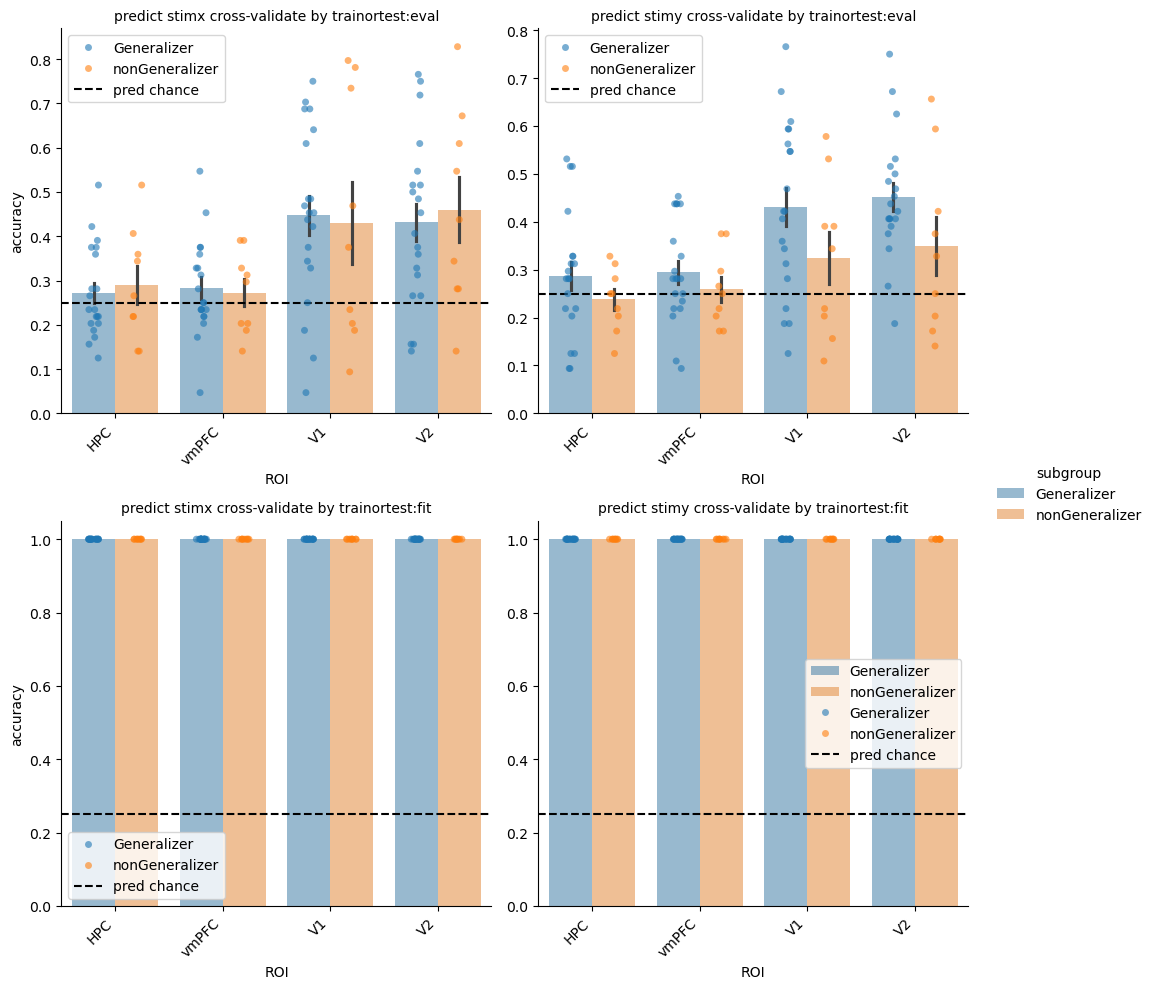

In [37]:
traintestCCGP_results_df = pd.concat(traintestCCGPnogs_results).reset_index(drop=True)
traintestCCGP_results_df[["region","side"]] = traintestCCGP_results_df.roi.str.split("_",expand=True)
traintestCCGP_results_df.region = pd.Categorical(traintestCCGP_results_df.region,
                                                 categories=base_rois,ordered=True)
traintestCCGP_results_df["stage"] = pd.Categorical(traintestCCGP_results_df["stage"],categories=["eval","fit"],ordered=True)
traintestCCGP_results_df
fg_traintestCCGP = sns.catplot(traintestCCGP_results_df,
            x="region",y="accuracy",hue="subgroup",
            hue_order=['Generalizer', 'nonGeneralizer'],palette=sns.color_palette()[:2],
            row="stage", col="analysis",
            kind="bar",errorbar="se",
            alpha=0.5,
            sharey=False)
fg_traintestCCGP.set_titles(template="{col_name}:{row_name}")
fg_traintestCCGP.map(sns.stripplot, 'region', "accuracy", "subgroup", dodge=True, 
                     jitter=0.1,size=5,alpha=0.6,
                     hue_order=['Generalizer', 'nonGeneralizer'],palette=sns.color_palette()[:2],
                     order = base_rois)
for ax in fg_traintestCCGP.axes.flatten():
    ax.axhline(1/4,label="pred chance",color="k",ls='--')
    ax.set_xlabel("ROI",visible=True)
    ax.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha="right")
    #ax.set_aspect(3)
    ax.legend()

fg_traintestCCGP.tight_layout()


## Cross task decoding

In [294]:
analyses = [

    {"name":"predict stim x cross-validate by task",
     "target_col":["stim_x","stim_y"],
     "splitby_col":"taskname",
     "chancelvl":0.25
     },

    # {"name":"predict stim xy cross-validate by task",
    #     "target_col":["stim_x","stim_y"],
    #     "splitby_col":"taskname",
    #     "chancelvl":0.25
    #     },

     ]
crosstaskCCGP_results = []
for roi in rois:
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)            
        for a_config in analyses:
            a_name,target_col,split_by_col = a_config["name"],a_config["target_col"],a_config["splitby_col"]
            subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
            preprocedX = deepcopy(subdata["preprocX"])
            stimdf = subdata["stimdf"]
            non_center_filter = [not all([x==0, y==0]) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]
            
            xydecoders = []
            for j,tcol in enumerate(target_col):
                navi_filter = np.all(np.vstack([
                            stimdf.taskname.to_numpy() == "navigation",
                            stimdf.stim_group.to_numpy() == 0,
                            stimdf[tcol]!=0
                            ]),axis=0)
                lzer_filter = np.all(np.vstack([
                            stimdf.taskname.to_numpy() == "localizer",
                            stimdf[tcol]!=0
                            ]),axis=0)

                
                currdf = pd.concat([stimdf[navi_filter].copy().reset_index(drop=True),
                                    stimdf[lzer_filter].copy().reset_index(drop=True)]).reset_index(drop=True)
                sessions_all = currdf.stim_session.to_numpy()
                currdf = currdf[currdf.stim_session>=3].copy().reset_index(drop=True)
                
                X = np.vstack([preprocedX[navi_filter,:],preprocedX[lzer_filter,:]])
                X = average_flexi_session(X, sessions_all,[[0,1,2,3],[4]])
                X = np.vstack([scale_feature(d,s_dir=2) for d in split_data(X,currdf["taskname"].to_numpy())])
                X = PCA().fit_transform(X)
                #X = scale_feature(X,s_dir=1)
                
                targets = np.array([str(int(x*2)) for x in currdf[tcol].to_numpy()]) 
                split_groups = currdf[split_by_col].to_numpy()
                baseclf_kwargs = {'max_iter':1000000,'tol':1e-20, 'penalty':1}                
                #fit_filter, eval_filter = split_groups=="navigation", split_groups=="localizer"
                #clf = LogisticRegression(**baseclf_kwargs)
                #clf.fit(X[fit_filter,:], targets[fit_filter])
                #fit_acc,eval_acc = clf.score(X[fit_filter,:], targets[fit_filter]), clf.score(X[eval_filter,:], targets[eval_filter])
                
                #fit_acc,eval_acc = classifier_cv(X,targets,split_groups,
                #                             baseclf=LinearSVC,baseclf_kwargs=baseclf_kwargs,return_splits=False)

                gridsearch_groups = currdf[target_col[int(1-j)]].to_numpy()
                baseclf_kwargs = {'max_iter':1000000}
                gridsearcg_paramgrid={'tol':np.logspace(-10,-5,num=5),'C':np.logspace(-10,3,num=5)}

                fit_filter, eval_filter = split_groups=="navigation", split_groups=="localizer"
                clf = GridSearchCV(LogisticRegression(**baseclf_kwargs),
                                   param_grid=gridsearcg_paramgrid,
                                   cv=LeaveOneGroupOut())
                clf.fit(X[fit_filter,:],targets[fit_filter],groups=gridsearch_groups[fit_filter])

                fit_acc = clf.score(X[fit_filter,:],targets[fit_filter])
                eval_acc = clf.score(X[eval_filter,:],targets[eval_filter])
                
                # fit_acc,eval_acc = classifier_gridsearchcv_cv(X,targets,split_groups,
                #                 gridsearcg_paramgrid,gridsearch_groups,
                #                 baseclf=LogisticRegression,baseclf_kwargs=baseclf_kwargs,
                #                 return_splits=False,return_decoder=False)

                crosstaskCCGP_res = {"accuracy":[fit_acc,eval_acc],"stage":["fit","eval"]}
                crosstaskCCGP_results.append(
                    pd.DataFrame(crosstaskCCGP_res).assign(roi=roi,subid=subid,subgroup=subgroup,analysis=a_name,predcol = tcol)
                    )
                    

Regions: Index(['HPC', 'vmPFC', 'V1', 'V2'], dtype='object')


c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


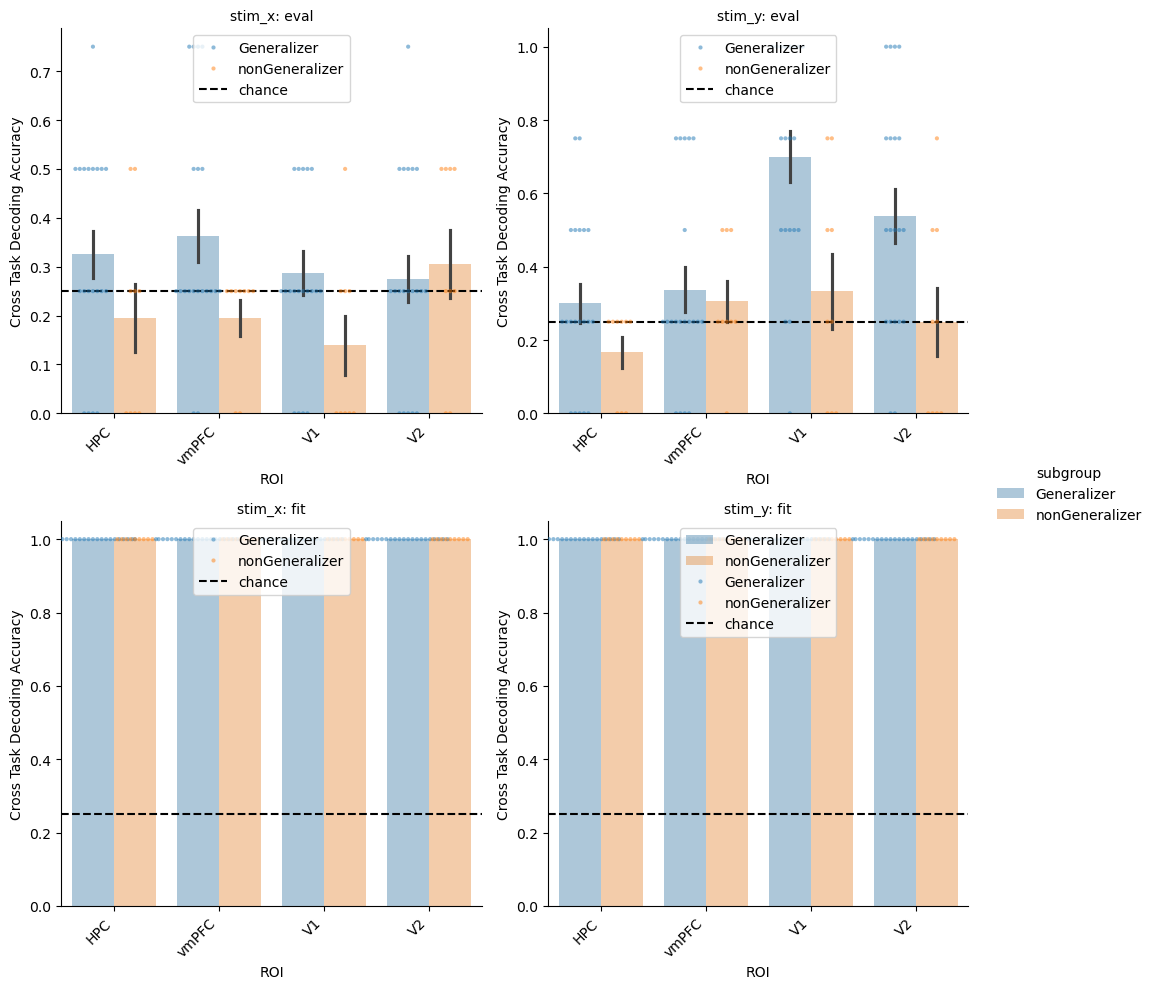

In [295]:
crosstaskCCGP_results_df = pd.concat(crosstaskCCGP_results).reset_index(drop=True)
crosstaskCCGP_results_df.head(5)
crosstaskCCGP_results_df[["region","side"]] = crosstaskCCGP_results_df.roi.str.split("_",expand=True)
crosstaskCCGP_results_df["accuracy_above_chance"] = crosstaskCCGP_results_df["accuracy"]-0.25
crosstaskCCGP_results_df["region"] = pd.Categorical(crosstaskCCGP_results_df.region,
                                                   categories = base_rois,#base_rois,
                                                   ordered=True)
crosstaskCCGP_results_df["stage"] = pd.Categorical(crosstaskCCGP_results_df.stage,
                                                   categories = ['eval', 'fit'],
                                                   ordered=True)
crosstaskCCGP_results_df["analysis"] = pd.Categorical(crosstaskCCGP_results_df.analysis)
crosstaskCCGP_results_df.to_csv(os.path.join(ROIRSAdir,"crosstaskdecoding.csv"))
print(f"Regions: {crosstaskCCGP_results_df.region.cat.categories}")

fg_trainingCCGP = sns.catplot(crosstaskCCGP_results_df,
            hue="subgroup",y="accuracy",
            row="stage",
            x="region",col="predcol",
            kind="bar",errorbar="se",
            sharey=False,alpha=0.4)
fg_trainingCCGP.set_titles(template="{col_name}: {row_name}")
fg_trainingCCGP.map(sns.swarmplot, 'region', "accuracy", "subgroup", dodge=True, 
                     size=3,alpha=0.5,
                     hue_order=['Generalizer', 'nonGeneralizer'],palette=sns.color_palette()[:2],
                     order = base_rois)
for ax in fg_trainingCCGP.axes.flatten():
    ax.axhline(0.25,label="chance",color="k",ls='--')
    ax.set_xlabel("ROI",visible=True)
    ax.set_ylabel("Cross Task Decoding Accuracy",visible=True)
    ax.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha="right")
    old_labels = ax.get_xticklabels()
    #ax.set_xticklabels([x.get_text().replace("cluster_","").replace("_","\n") for x in old_labels])
    #ax.set_aspect(3)
    ax.legend()
    sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5,1))

fg_trainingCCGP.tight_layout()


C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\418968527.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadf[gvar] = pd.Categorical(datadf[gvar],categories=np.unique(datadf[gvar]))
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\418968527.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for kg,(gname,g_df) in enumerate(facet_df.groupby(gvar)):
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\418968527.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

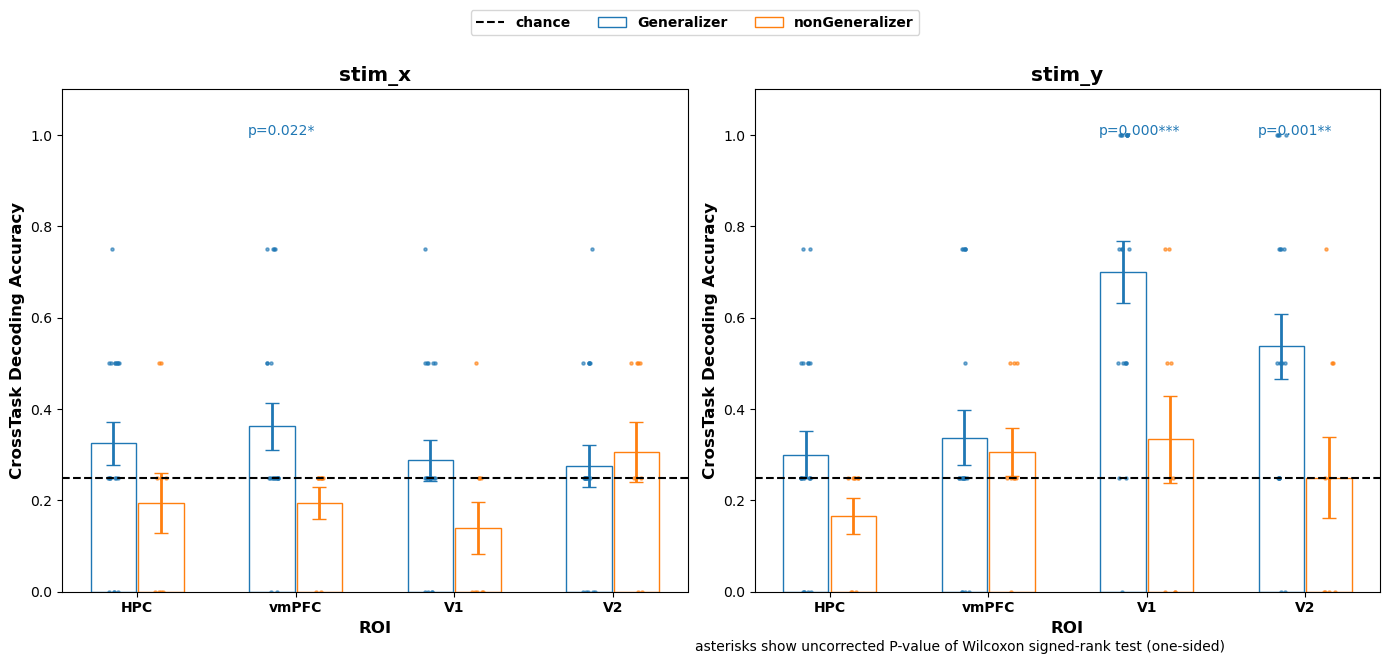

In [296]:
xvar, gvar, yvar, yvartest = "region",  "subgroup", "accuracy","accuracy_above_chance"
fig,axes = grouped_barscatter_withstats(crosstaskCCGP_results_df[crosstaskCCGP_results_df.stage=="eval"],
                             facet_vars = "predcol", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                             prows=1,pcols=2,
                             statfunc=lambda yt: 1. if np.size(yt)<10 else scipy.stats.wilcoxon(yt,alternative='greater').pvalue)
for ifacet, _ in enumerate(axes.flatten()):
    axes.flatten()[ifacet].set_ylabel("CrossTask Decoding Accuracy",fontweight="bold",fontsize="large")
    axes.flatten()[ifacet].set_xlabel("ROI",fontweight="bold",fontsize="large")
    axes.flatten()[ifacet].axhline(0.25,label="chance",color="k",ls='--')
    
hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
fig.legend([hs[0],hs[1],hs[-1]],[ls[0],ls[1],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
           prop = dict(weight="bold"))
fig.text(x=0.5, y=0, s='asterisks show uncorrected P-value of Wilcoxon signed-rank test (one-sided)')
fig.tight_layout()

## Test stimuli Representation composed from training

In [ ]:
from multivariate.MVPA_estimator import CompositionalRSARegression,CompositionalRSA
compositioncorrelation_results = []
for roi in rois:
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        preprocedX = deepcopy(subdata["preprocX"])
        stimdf = subdata["stimdf"]
        
        navi_filter = stimdf.taskname.to_numpy() == "navigation"
        
        #average across sessions
        navi_X = np.mean(split_data(X      = preprocedX[navi_filter,:],
                                    groups = stimdf[navi_filter].copy().stim_session.to_numpy()),
                        axis=0)

        assert navi_X.shape[0] == 25
        navi_df = stimdf[navi_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True)
        
        navicomp_estimator = CompositionalRSARegression(activitypattern = navi_X,
                         stim_df = navi_df,
                         source_ref_split_name= "stim_group",
                         compose_feature_names= ["stim_x","stim_y"],
                         control_feature_names= [])
        navicomp_estimator.fit()
        

        res_df = pd.DataFrame(
                {"analysis":   navicomp_estimator.resultnames,
                "coefficient": navicomp_estimator.result}
            ).assign(
            roi = roi,
            subid=subid,
            subgroup=subgroup
            )
        compositioncorrelation_results.append(res_df)



In [ ]:
navicomp_estimator.PCestimator

In [ ]:
compositioncorrelation_results_df = pd.concat(compositioncorrelation_results,axis=0)
compositioncorrelation_results_df.to_csv(os.path.join(ROIRSAdir,"within_task_composition_correlation.csv"))

In [ ]:
fg_corrres = sns.catplot(compositioncorrelation_results_df,
            x="analysis",y="coefficient",
            hue="subgroup",
            col="roi",
            kind="bar",errorbar="se",dodge=True)
for ax in fg_corrres.axes.flatten():
    ax.axhline(0,color="grey",linestyle="--")
    #ticklabels = np.unique(compositioncorrelation_results_df["roi"])
    #ax.set_xticks(ticks=np.arange(len(ticklabels)),labels=ticklabels,rotation=90)
    plt.setp(ax.get_xticklabels(), visible=True)
    ax.xaxis.set_tick_params(labelbottom=True)
    #ax.set_aspect(5)
sns.move_legend(fg_corrres,loc="upper center",bbox_to_anchor = (0.5,1.1))
fg_corrres.set_titles(template="{col_name}").figure.tight_layout()

## Test stimuli representation encoding models

In [124]:
from zpyhelper.MVPA.estimators import MetaEstimator, PatternCorrelation, MultipleRDMRegression
from zpyhelper.MVPA.rdm import compute_rdm,compute_rdm_identity,compute_rdm_residual, lower_tri
from zpyhelper.MVPA.preprocessors import split_data,scale_feature
import numpy
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import itertools
import sys
import os
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(os.path.join(project_path,'src'))
from multivariate.modelrdms import ModelRDM

from sklearn.linear_model import LinearRegression

def _compose_pattern_from_reference_single_source(source_feature:Union[numpy.ndarray,list],
                                                  R:numpy.ndarray,
                                                  M:numpy.ndarray,
                                                  source_controlfeature:Union[numpy.ndarray,list]=[],
                                                  M0:numpy.ndarray=[],
                                                  compose_method = "concat")->numpy.ndarray:
    """compose pattern for a single source from the reference matrix by matching reference features with the source's features. \n
    Let ``R`` be the reference pattern matrix that contains representation patterns of different feature combinations in the same or a different task.
    Let ``f(x,y)`` be a row vector in ``R`` that correspond to the representation pattern of feature combination represented by vector``(x,y)`` in the voxel space. \n
    We can compose the representation pattern of new feature combination ``(a,b)`` from ``R`` by:\n
      1) selecting rows in ``R`` that contains feature ``a``, same for ``b`` \n
      2) averaging the representation patterns of ``a``, same for ``b`` \n
      3) concatenating the average representation patterns of ``a`` and ``b`` \n
    In other words:    ``g(a,b) = [f(x,y|x=a),f(x,y|y=b)]``   \n
    where ``(a,b)`` is the source feature vector. the reference features matrix ``M`` stores all the information about the features of each rows of ``R``. \n

    In addition, pattern selection further constrained by control features:
    Given ``source_controlfeature``=(c,...), the search of patterns in ``R`` is further limited to make sure only rows where M0 == c is included in the construction of compositional patterns
    
    Parameters
    ----------
    source_feature : Union[numpy.ndarray,list]
        features of the source stimulus that are used to find the corresponding rows in the reference matrix to compose pattern. size =`n`
    R : numpy.ndarray
        the reference pattern matrix. a 2D numpy array that has ``m`` rows. Each row is the representation pattern of a reference stimuli with features specified in the corresponding row of ``M``
    M : numpy.ndarray
        the reference features matrix, a 2D numpy array of shape ``(m,n)`` Each row is the features of a reference stimuli 
    source_controlfeature : Union[numpy.ndarray,list], optional
        control features, by default []
    M0 : numpy.ndarray, optional
        the reference control features matrix specifying control features of the reference samples, by default []

    Returns
    -------
    numpy.ndarray
        composed feature matrix
    """

    source_feature = numpy.array(source_feature).flatten()
    source_controlfeature = numpy.array(source_controlfeature).flatten()
    R = numpy.array(R)
    M = numpy.array(M)
    M0 = numpy.array(M0)

    assert source_feature.size == M.shape[1]
    assert R.shape[0] == M.shape[0]
    if source_controlfeature.size>0:
        assert R.shape[0] == M0.shape[0]
        assert source_controlfeature.size == M0.shape[1]
        #the rows in the reference stimuli where the control feature matches the sample
        ctrl_f_filter = [numpy.array_equal(ref_ctrlfs, source_controlfeature) for ref_ctrlfs in M0]
    else:
         ctrl_f_filter = [True] * R.shape[0]
    
    
    f_filters = [
        [all([x==f,cf]) for x,cf in zip(M[:,j],ctrl_f_filter)] for j,f in enumerate(source_feature)
    ]

    vecs = [numpy.mean(R[f_filter,:],axis=0).flatten() for f_filter in f_filters]
    if compose_method == "concat":
        return numpy.concatenate(vecs)
    elif compose_method == "vec_add":
        return numpy.sum(vecs,axis=0)

def compose_pattern_from_reference(source_features:numpy.ndarray,
                                   reference_pattern:numpy.ndarray,reference_features:numpy.ndarray,
                                   source_controlfeatures:numpy.ndarray=[],reference_controlfeatures:numpy.ndarray=[],
                                   compose_method="concat"):
    """	compose pattern from the reference matrix by matching reference features with the sources' features. \n
    Parameters
    ----------
    source_features : Union[numpy.ndarray,list]
        features of k source stimuli that are used to find the corresponding rows in the reference matrix to compose pattern. a 2D numpy array of shape `(k,n)`
    reference_pattern : numpy.ndarray
        the reference pattern matrix. a 2D numpy array that has ``m`` rows. Each row is the representation pattern of a reference stimuli with features specified in the corresponding row of ``M``
    reference_features : numpy.ndarray
        the reference features matrix, a 2D numpy array of shape ``(m,n)`` Each row is the features of a reference stimuli 
    source_controlfeatures : Union[numpy.ndarray,list], optional
        control features,a 2D numpy array of shape `(k,p)`, by default []
    reference_controlfeatures : numpy.ndarray, optional
        the reference control features matrix specifying control features of the reference samples,a 2D numpy array of shape `(m,p)`, by default []

    Returns
    -------
    numpy.ndarray
        composed feature matrix

    """
    
    source_features        = numpy.atleast_2d(source_features)
    source_controlfeatures = numpy.atleast_2d(source_controlfeatures)
    if source_controlfeatures.size>0:
        assert source_controlfeatures.shape[0] == source_features.shape[0]
        return numpy.array([_compose_pattern_from_reference_single_source(sf,reference_pattern,reference_features,scf,reference_controlfeatures,compose_method=compose_method) for sf,scf in zip(source_features,source_controlfeatures)])
    else:
        return numpy.array([_compose_pattern_from_reference_single_source(sf,reference_pattern,reference_features,compose_method=compose_method) for sf in source_features])


class CompositionalRSA(MetaEstimator):
    def __init__(self,activitypattern:numpy.ndarray,
                 stim_df:pandas.DataFrame,
                 source_ref_split_name:str,
                 compose_feature_names:list=None,
                 control_feature_names:list=[]) -> None:
        """CompositionalRSA analysis, compare the RDM of data and the RDM generated using composed pattern from reference data

        Parameters
        ----------
        activitypattern : numpy.ndarray
            activity pattern matrix, a 2D numpy array of shape ``(nsample,nvoxel)``
        stim_df : pandas.DataFrame
            dataframe containing stimuli information
        source_ref_split_name : str
            column name in stimdf indicating whether each row of activity pattern is source (0) or split (1), a 1D numpy array of shape ``(nsample,)`, must contain [0,1]
        compose_feature_names : list, optional
            column names of compose features, by default None
        control_feature_names : list, optional
            column names of control features, by default None
        """
        
        activitypattern  = numpy.atleast_2d(activitypattern)
        check_cols = [source_ref_split_name]+compose_feature_names+control_feature_names+["stim_x","stim_y","stim_id","stim_color","stim_shape"]
        assert all([x in stim_df.columns for x in check_cols])
        compose_features,control_features,source_ref_split = stim_df[compose_feature_names].to_numpy(),stim_df[control_feature_names].to_numpy(),stim_df[source_ref_split_name].to_numpy()
        assert activitypattern.shape[0] == compose_features.shape[0]
        assert numpy.array_equal(numpy.unique(source_ref_split),[0,1])

        # split into source and ref
        source_mat, ref_mat = split_data(activitypattern,groups=source_ref_split,select_groups=[0,1])
        source_cmpsfs, ref_cmpsfs = split_data(compose_features,groups=source_ref_split,select_groups=[0,1])
        if control_features.size>0:
            assert activitypattern.shape[0] == control_features.shape[0]
            source_ctrlfs, ref_ctrlfs = split_data(control_features,groups=source_ref_split,select_groups=[0,1])
            self.n_control_features = source_ctrlfs.shape[1]
        else:
            source_ctrlfs, ref_ctrlfs = [],[]
            self.n_control_features = 0

        self.source    = {"activity_pattern":source_mat,
                          "compose_features":source_cmpsfs,
                          "control_features":source_ctrlfs}
        self.reference = {"activity_pattern":ref_mat,
                          "compose_features":ref_cmpsfs,
                          "control_features":ref_ctrlfs}

        self.n_sample = source_mat.shape[0]
        self.n_compose_features = source_cmpsfs.shape[1]        
        
        self.compose_feature_names = [f"{k}" for k in range(self.n_compose_features)] if compose_feature_names is None else compose_feature_names
        assert len(self.compose_feature_names) == self.n_compose_features
        self.control_feature_names = [f"{k}" for k in range(self.n_control_features)] if control_feature_names is None else control_feature_names
        assert len(self.control_feature_names) == self.n_control_features

        
        self.composed_apm = compose_pattern_from_reference(source_cmpsfs,ref_mat,ref_cmpsfs,source_ctrlfs,ref_ctrlfs,compose_method="vec_add")
        self.src_composed_apm = numpy.vstack([source_mat,self.composed_apm])
        self.src_composed_df  = pandas.concat(
            [stim_df[source_ref_split==0].copy().assign(dstype=0),
             stim_df[source_ref_split==0].copy().assign(dstype=1)],axis=0).reset_index(drop=True)

        submodelrdm = ModelRDM(
                    stimid    = self.src_composed_df["stim_id"].to_numpy(),
                    stimgtloc = self.src_composed_df[["stim_x","stim_y"]].to_numpy(),
                    stimfeature = self.src_composed_df[["stim_color","stim_shape"]].to_numpy(),
                    stimgroup = self.src_composed_df["stim_group"].to_numpy(),
                    sessions =  self.src_composed_df["dstype"].to_numpy(),
                    nan_identity = False,
                    splitgroup  = True
                )
        base_corr_config = {"euclidean":"gtlocEuclidean","feature":"feature2d","stimuli":"stimuli"}
        # then we split into predict test and predict train (if not navigation2navigation)
        correlation_config = {}
        for k,v in base_corr_config.items():
            if numpy.unique(self.src_composed_df["stim_group"]).size>1:
                correlation_config[f"compose2test_{k}"]  = f"between_teststimpairs_{v}"
                correlation_config[f"compose2train_{k}"] = f"between_trainstimpairs_{v}"            
                correlation_config[f"compose2all_{k}"]   = f"between_{v}"
            else:
                correlation_config[f"compose2test_{k}"]   = f"between_{v}"
        self.modelRDMs = dict(zip(correlation_config.keys(),[submodelrdm.models[m] for m in correlation_config.values()]))


        self.PCestimator = PatternCorrelation(
            activitypattern=self.src_composed_apm,
            modelnames=list(self.modelRDMs.keys()),
            modelrdms=list(self.modelRDMs.values()),
            rdm_metric="correlation",
            type="spearman",
            ztransform=False
        )

    def fit(self):
        self.result = self.PCestimator.fit().result
        self.resultnames = list(self.modelRDMs.keys())
        return self
    
    def visualize(self):
        fig = self.estimator.visualize()
        return fig
    
    def __str__(self) -> str:
        #if self.compose_separate:
        #    return f"CompositionalRSA based on separate features using {self.estimator.__str__()}"
        #else:
        return f"CompositionalRSA with {self.PCestimator.__str__()}"
    
    def get_details(self)->str:
        details = {
            "name": self.__str__(),
            "resultnames": list(self.resultnames),
            "estimator": self.PCestimator.get_details()
        }
        return details
    

class CompositionalRSARegression(MetaEstimator):
    def __init__(self,activitypattern:numpy.ndarray,
                 stim_df:pandas.DataFrame,
                 source_ref_split_name:str,
                 compose_feature_names:list=None,
                 control_feature_names:list=[]) -> None:
        """CompositionalRSA analysis, compare the RDM of data and the RDM generated using composed pattern from reference data

        Parameters
        ----------
        activitypattern : numpy.ndarray
            activity pattern matrix, a 2D numpy array of shape ``(nsample,nvoxel)``
        stim_df : pandas.DataFrame
            dataframe containing stimuli information
        source_ref_split_name : str
            column name in stimdf indicating whether each row of activity pattern is source (0) or split (1), a 1D numpy array of shape ``(nsample,)`, must contain [0,1]
        compose_feature_names : list, optional
            column names of compose features, by default None
        control_feature_names : list, optional
            column names of control features, by default None
        """
        
        activitypattern  = numpy.atleast_2d(activitypattern)
        check_cols = [source_ref_split_name]+compose_feature_names+control_feature_names+["stim_x","stim_y","stim_id","stim_color","stim_shape"]
        assert all([x in stim_df.columns for x in check_cols])
        compose_features,control_features,source_ref_split = stim_df[compose_feature_names].to_numpy(),stim_df[control_feature_names].to_numpy(),stim_df[source_ref_split_name].to_numpy()
        assert activitypattern.shape[0] == compose_features.shape[0]
        assert numpy.array_equal(numpy.unique(source_ref_split),[0,1])

        # split into source and ref
        source_mat, ref_mat = split_data(activitypattern,groups=source_ref_split,select_groups=[0,1])
        source_cmpsfs, ref_cmpsfs = split_data(compose_features,groups=source_ref_split,select_groups=[0,1])
        if control_features.size>0:
            assert activitypattern.shape[0] == control_features.shape[0]
            source_ctrlfs, ref_ctrlfs = split_data(control_features,groups=source_ref_split,select_groups=[0,1])
            self.n_control_features = source_ctrlfs.shape[1]
        else:
            source_ctrlfs, ref_ctrlfs = [],[]
            self.n_control_features = 0

        self.source    = {"activity_pattern":source_mat,
                          "compose_features":source_cmpsfs,
                          "control_features":source_ctrlfs}
        self.reference = {"activity_pattern":ref_mat,
                          "compose_features":ref_cmpsfs,
                          "control_features":ref_ctrlfs}

        self.n_sample = source_mat.shape[0]
        self.n_compose_features = source_cmpsfs.shape[1]        
        
        self.compose_feature_names = [f"{k}" for k in range(self.n_compose_features)] if compose_feature_names is None else compose_feature_names
        assert len(self.compose_feature_names) == self.n_compose_features
        self.control_feature_names = [f"{k}" for k in range(self.n_control_features)] if control_feature_names is None else control_feature_names
        assert len(self.control_feature_names) == self.n_control_features

        
        self.composed_apm = compose_pattern_from_reference(source_cmpsfs,ref_mat,ref_cmpsfs,source_ctrlfs,ref_ctrlfs,compose_method="vec_add")
        self.src_composed_apm = numpy.vstack([source_mat,self.composed_apm])
        self.src_composed_df  = pandas.concat(
            [stim_df[source_ref_split==0].copy().assign(dstype=0),
             stim_df[source_ref_split==0].copy().assign(dstype=1)],axis=0).reset_index(drop=True)

        submodelrdm = ModelRDM(
                    stimid    = self.src_composed_df["stim_id"].to_numpy(),
                    stimgtloc = self.src_composed_df[["stim_x","stim_y"]].to_numpy(),
                    stimfeature = self.src_composed_df[["stim_color","stim_shape"]].to_numpy(),
                    stimgroup = self.src_composed_df["stim_group"].to_numpy(),
                    sessions =  self.src_composed_df["dstype"].to_numpy(),
                    nan_identity = False,
                    splitgroup  = True
                )
        base_corr_config = {"euclidean":"gtlocEuclidean","feature":"feature2d","stimuli":"stimuli"}
        # then we split into predict test and predict train (if not navigation2navigation)
        correlation_config = {}
        for k,v in base_corr_config.items():
            correlation_config[f"compose2test_{k}"]   = f"between_{v}"
        self.modelRDMs = dict(zip(correlation_config.keys(),[submodelrdm.models[m] for m in correlation_config.values()]))


        self.PCestimator = MultipleRDMRegression(
            activitypattern=self.src_composed_apm,
            modelnames=list(self.modelRDMs.keys()),
            modelrdms=list(self.modelRDMs.values()),
            rdm_metric="correlation",
            standardize=True,
            runonresidual=False
        )

    def fit(self):
        self.result = self.PCestimator.fit().result
        self.resultnames = list(self.modelRDMs.keys())
        return self
    
    def visualize(self):
        fig = self.estimator.visualize()
        return fig
    
    def __str__(self) -> str:
        #if self.compose_separate:
        #    return f"CompositionalRSA based on separate features using {self.estimator.__str__()}"
        #else:
        return f"CompositionalRSA with {self.PCestimator.__str__()}"
    
    def get_details(self)->str:
        details = {
            "name": self.__str__(),
            "resultnames": list(self.resultnames),
            "estimator": self.PCestimator.get_details()
        }
        return details
    

class CompositionalRetrieval(MetaEstimator):
    def __init__(self,activitypattern:numpy.ndarray,
                 stim_df:pandas.DataFrame) -> None:
        activitypattern  = numpy.atleast_2d(activitypattern)
        check_cols = ["stim_x","stim_y","stim_id","stim_color","stim_shape", "stim_group","stim_task"]
        assert all([x in stim_df.columns for x in check_cols])
        assert activitypattern.shape[0] == stim_df.shape[0]
        
        noncenterfilter = [~numpy.logical_and(x==0,y==0) for x,y in stim_df[["stim_x","stim_y"]].to_numpy()]
        navitrain_filter = numpy.all(numpy.vstack([
            stim_df["stim_task"].to_numpy()==0,
            stim_df["stim_group"].to_numpy()==1,
            noncenterfilter
        ]),axis=0)
        navitest_filter = numpy.all(numpy.vstack([
            stim_df["stim_task"].to_numpy()==0,
            stim_df["stim_group"].to_numpy()==0
        ]),axis=0)
        lzer_filter = numpy.all(numpy.vstack([
            stim_df["stim_task"].to_numpy()==1,
            noncenterfilter
        ]),axis=0)
        
        navitrain_X, navitrain_df = activitypattern[navitrain_filter,:] , stim_df[navitrain_filter].copy().reset_index(drop=True)
        navitest_X,  navitest_df  = activitypattern[navitest_filter,:] ,  stim_df[navitest_filter].copy().reset_index(drop=True)
        lzer_X,      lzer_df       = activitypattern[lzer_filter,:] ,      stim_df[lzer_filter].copy().reset_index(drop=True)
        
        self.Xs = {
            "teststim":  navitrain_X,
            "trainstim": navitest_X,
            "locations": lzer_X
        }

        self.dfs = {
            "teststim":  navitrain_df,
            "trainstim": navitest_df,
            "locations": lzer_df
        }

        self.regression_configs = {
            "train2test": ["trainstim","teststim"], # in the order of independent var, dependent var
            "loc2test": ["locations","teststim"],
            "loc2train": ["locations","trainstim"]
        }

    def fit(self):
        result = []
        result_names = []
        regcoefmats = {}
        for regname, rcfg in self.regression_configs.items():
            component_X,  configural_X = self.Xs[rcfg[0]], self.Xs[rcfg[1]]
            component_df, configural_df = self.dfs[rcfg[0]], self.dfs[rcfg[1]]

            reg_coefs = LinearRegression().fit(component_X.T,configural_X.T).coef_
            true_reg_coefs = cdist(configural_df[["stim_x","stim_y"]].to_numpy(),
                                   component_df[["stim_x","stim_y"]].to_numpy(),
                                   lambda u,v: sum(u==v))
            dist_mod_reg_coefs = cdist(configural_df[["stim_x","stim_y"]].to_numpy(),
                                       component_df[["stim_x","stim_y"]].to_numpy(),
                                       lambda u,v: numpy.sum((2-numpy.abs(u-v))*(1*(v!=0))))
            regcoefmats[regname] = [reg_coefs,true_reg_coefs,dist_mod_reg_coefs]
            
            pdcoef = LinearRegression().fit(
                        X=scale_feature(numpy.array([dist_mod_reg_coefs.flatten(),true_reg_coefs.flatten()]).T,1),
                        y=scale_feature(reg_coefs.flatten(),2)
                    ).coef_
            corr_percept = spearmanr(reg_coefs.flatten(),true_reg_coefs.flatten()).statistic
            corr_dmod = spearmanr(reg_coefs.flatten(),dist_mod_reg_coefs.flatten()).statistic

            compo_stims = reg_coefs[true_reg_coefs==1]
            noncompo_stims = reg_coefs[true_reg_coefs==0]

            result = result + [pdcoef[0], pdcoef[1], numpy.arctanh(corr_dmod), numpy.arctanh(corr_percept), compo_stims.mean()-noncompo_stims.mean(), compo_stims.sum()-noncompo_stims.sum()]
            prim_names = ["reg_distmod","reg_percept","zcorr_distmod","zcorr_percept", "meanweightdiff", "sumweightdiff"]
            result_names = result_names + [f"{regname}-{x}" for x in prim_names]
            
        self.result = result
        self.resultnames = result_names
        self.regcoefmats = regcoefmats
        return self
    
    def visualize(self):
        fig = self.estimator.visualize()
        return fig
    
    def __str__(self) -> str:
        return f"CompositionalRetrieval"
    
    def get_details(self)->str:
        details = {
            "name": self.__str__(),
            "resultnames": list(self.resultnames)
        }
        return details
    

In [506]:
from sklearn.linear_model import LinearRegression

import scipy.spatial
import scipy.stats
def get_retrieval_weights(test_X,training_X,test_df,training_df):
    reg_coefs = LinearRegression().fit(training_X.T,test_X.T).coef_
    true_reg_coefs = scipy.spatial.distance.cdist(test_df[["stim_x","stim_y"]].to_numpy(),
                             training_df[["stim_x","stim_y"]].to_numpy(),
                             lambda u,v: sum(u==v))
    dist_mod_reg_coefs = scipy.spatial.distance.cdist(test_df[["stim_x","stim_y"]].to_numpy(),
                             training_df[["stim_x","stim_y"]].to_numpy(),
                             lambda u,v: np.sum((2-np.abs(u-v))*(1*(v!=0))))
    return reg_coefs, true_reg_coefs, dist_mod_reg_coefs

def get_retrieval_correlation(test_X,training_X,test_df,training_df):
    corr_coefs = []
    for j, testloc in enumerate(test_df[["stim_x","stim_y"]].to_numpy()):
        testpattern = test_X[j,:]
        corrs = [scipy.stats.pearsonr(testpattern,trainpattern).correlation for trainpattern in training_X]
        corr_coefs.append(corrs)
    
    true_corr_coefs = scipy.spatial.distance.cdist(test_df[["stim_x","stim_y"]].to_numpy(),
                             training_df[["stim_x","stim_y"]].to_numpy(),
                             lambda u,v: sum(u==v))
    dist_mod_corr_coefs = scipy.spatial.distance.cdist(test_df[["stim_x","stim_y"]].to_numpy(),
                             training_df[["stim_x","stim_y"]].to_numpy(),
                             lambda u,v: np.sum((2-np.abs(u-v))*(1*(v!=0))))
    
    return corr_coefs, true_corr_coefs, dist_mod_corr_coefs

In [125]:
reg_coefs,true_reg_coefs,dmod_reg_coefs = {}, {}, {}
compositionretrieval_results = []
retrievalweigtsmean_results = []
for roi in rois:
    reg_coefs[roi],true_reg_coefs[roi], dmod_reg_coefs[roi] = [], [], []
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        preprocedX = deepcopy(subdata["preprocX"])
        stimdf = subdata["stimdf"]
        
        navi_filter = np.vstack(
            [stimdf.taskname.to_numpy() == "navigation",
             [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]
        ).all(axis=0)
        
        #average across sessions
        navi_X = np.mean(split_data(X      = preprocedX[navi_filter,:],
                                    groups = stimdf[navi_filter].copy().stim_session.to_numpy()),
                        axis=0)
        #navi_X = scale_feature(navi_X,0) # 

        assert navi_X.shape[0] == 24
        navi_df = stimdf[navi_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True)

        training_filter = navi_df.stim_group==1
        test_filter = navi_df.stim_group==0

        trdf = navi_df[training_filter].copy().reset_index(drop=True)
        trX  = navi_X[training_filter]
        trdfneworder = trdf.sort_values(by=['training_axset','training_axloc'])
        new_order = trdfneworder.index
        training_df = trdfneworder.reset_index(drop=True).assign(stim_task=0)
        training_X = trX[new_order,:]
        
        
        test_X = navi_X[test_filter]
        test_df = navi_df[test_filter].copy().reset_index(drop=True).assign(stim_task=0)


        lzer_filter = np.vstack(
            [stimdf.taskname.to_numpy() == "localizer",
             [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]
        ).all(axis=0)
        lzerX  = preprocedX[lzer_filter,:]
        lzdfneworder = stimdf[lzer_filter].copy().reset_index(drop=True).sort_values(by=['training_axset','training_axloc'])
        new_order = lzdfneworder.index
        lzer_df = lzdfneworder.reset_index(drop=True).assign(stim_task=1)
        lzer_X = lzerX[new_order,:]

        CRestimator = CompositionalRetrieval(activitypattern=np.vstack([training_X,test_X,lzer_X]),
                               stim_df=pd.concat([training_df,test_df,lzer_df],axis=0).reset_index(drop=True))
        CRestimator.fit()

        subresdf = pd.DataFrame({"value":CRestimator.result,
                                 "metric":CRestimator.resultnames}
                                 ).assign(roi=roi,subid=subid,subgroup=subgroup)
        compositionretrieval_results.append(subresdf)
        


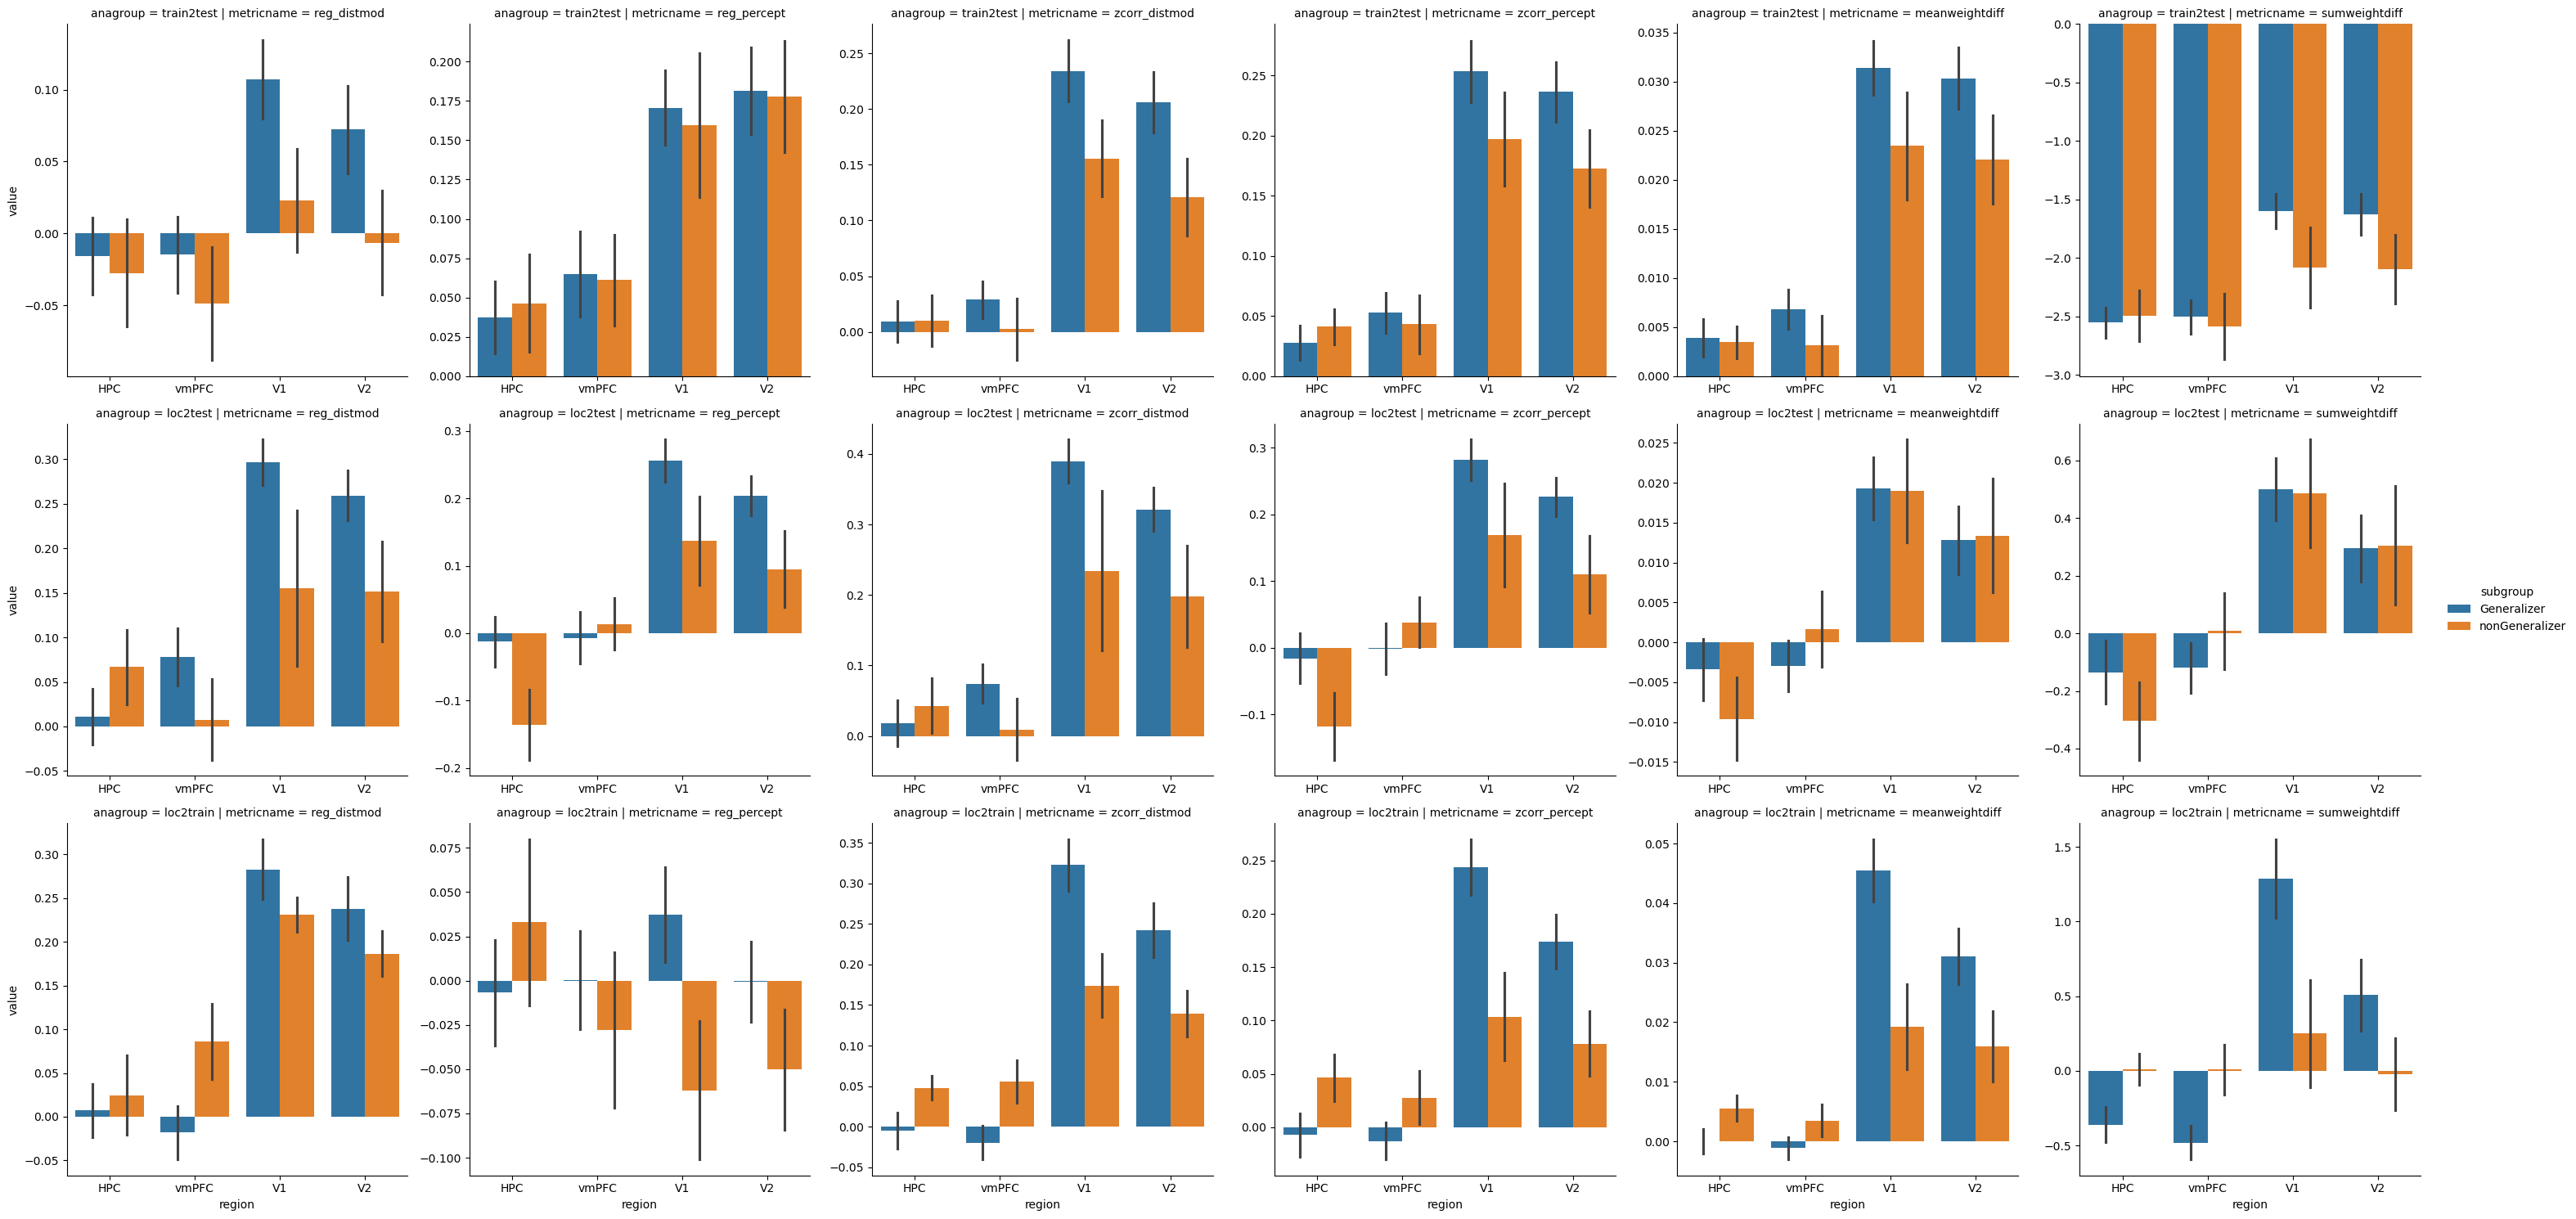

In [126]:
compositionretrieval_resdf = pd.concat(compositionretrieval_results,axis=0).reset_index(drop=True)
compositionretrieval_resdf[["anagroup","metricname"]] = compositionretrieval_resdf.metric.str.split("-",expand=True)
compositionretrieval_resdf[["region","side"]] = compositionretrieval_resdf.roi.str.split("_",expand=True)
compositionretrieval_resdf.region = pd.Categorical(compositionretrieval_resdf.region,
                                                   categories=base_rois,ordered=True)
compositionretrieval_resdf.head(5)
sns.catplot(compositionretrieval_resdf,
            x="region",y="value",hue="subgroup",
            row="anagroup",col="metricname",
            kind="bar",errorbar="se",sharey=False,sharex=False)


C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\2732331901.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_pdf.metricname = pd.Categorical(curr_pdf.metricname,categories=plt_mts,ordered=True)
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\1299055837.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  assert prows*pcols>=len(list(enumerate(datadf.groupby(facet_vars))))
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_25456\1299055837.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

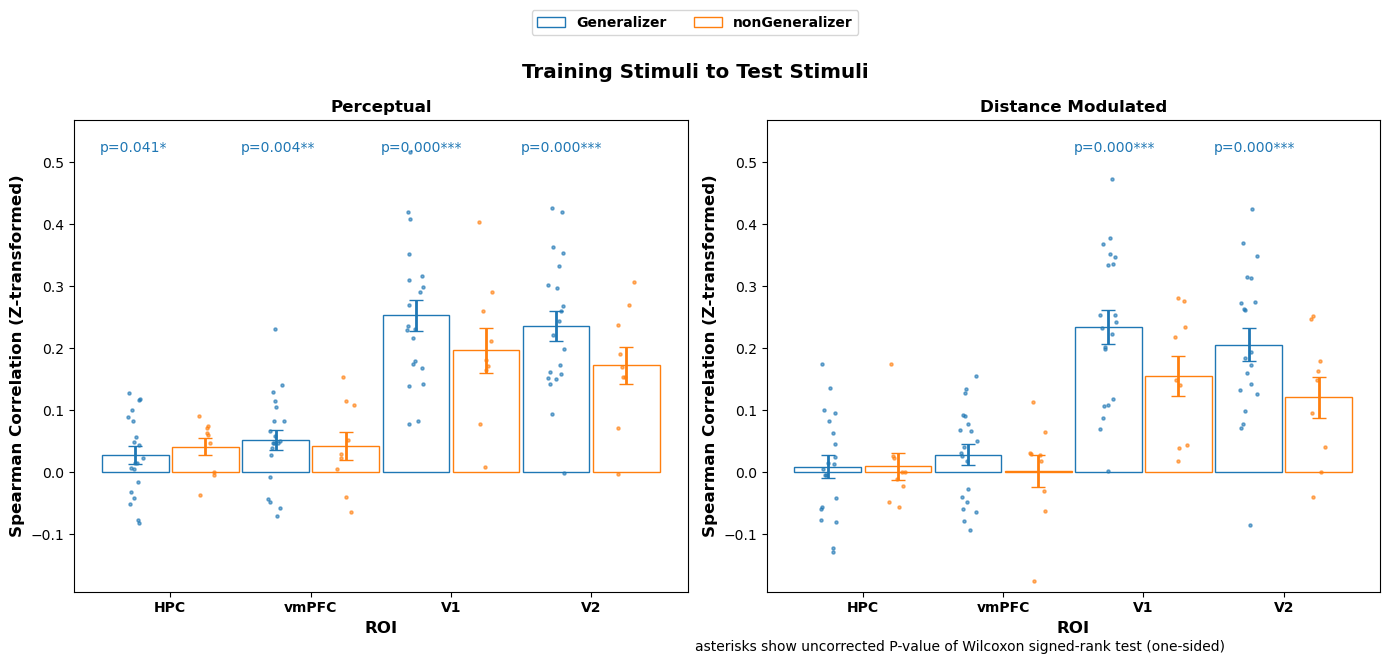

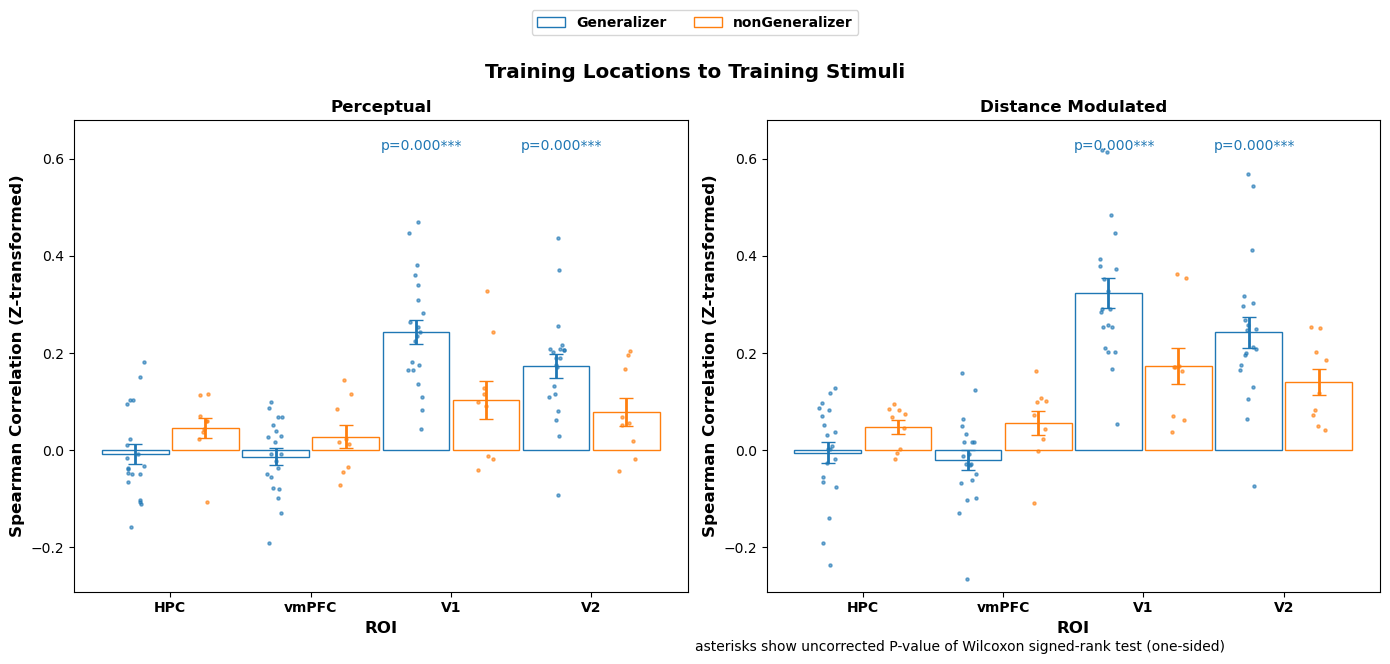

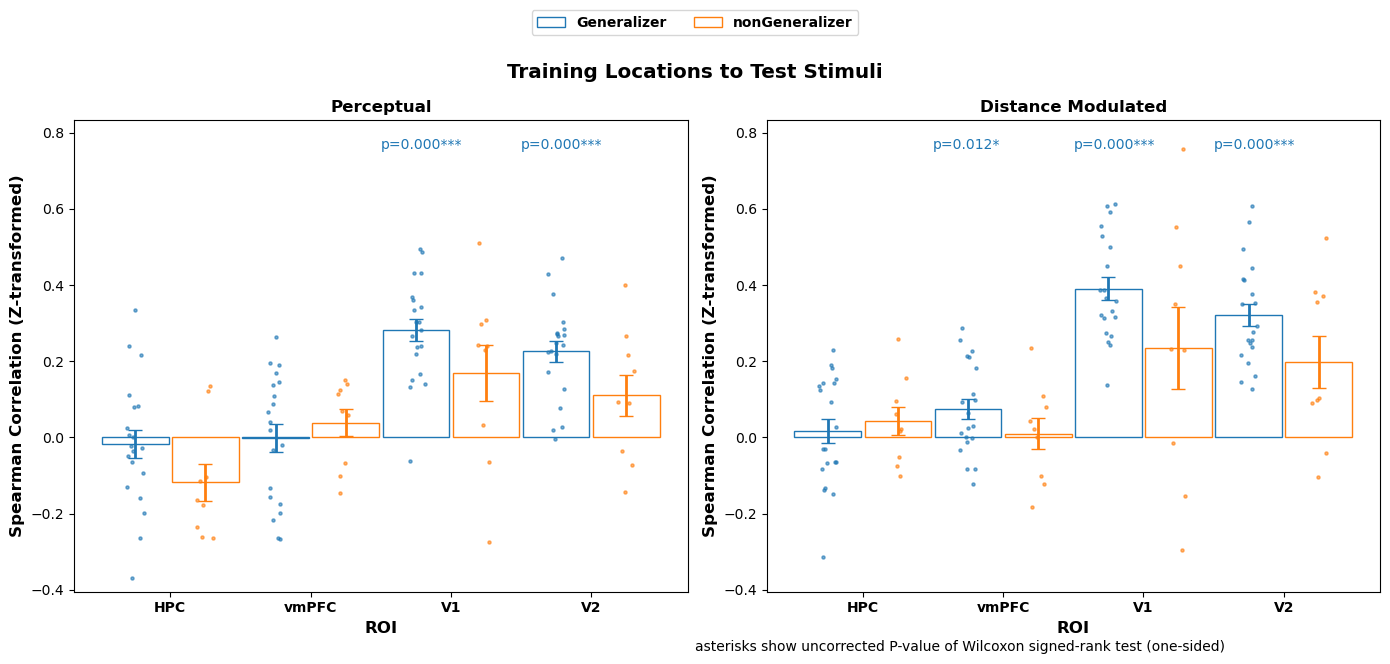

In [143]:
xvar, gvar, yvar, yvartest = "region",  "subgroup", "value", "value"
plt_mts = ["zcorr_percept","zcorr_distmod"]
facet_names = dict(zip(plt_mts,["Perceptual", "Distance Modulated"]))
plt_ana = dict(zip(["train2test","loc2train","loc2test"],
                   ["Training Stimuli to Test Stimuli", "Training Locations to Training Stimuli", "Training Locations to Test Stimuli"]))
for a, atitle in plt_ana.items():
    curr_pdf = compositionretrieval_resdf[(compositionretrieval_resdf.metricname.isin(plt_mts))&(compositionretrieval_resdf.anagroup==a)]
    curr_pdf.metricname = pd.Categorical(curr_pdf.metricname,categories=plt_mts,ordered=True)
    fig,axes = grouped_barscatter_withstats(curr_pdf,
                                facet_vars = "metricname", xvar=xvar, gvar=gvar, yvar=yvar, yvartest=yvartest,#
                                prows=1,pcols=2,
                                statfunc=lambda yt: 1. if np.size(yt)<10 else scipy.stats.wilcoxon(yt,alternative='greater').pvalue)
    for ifacet, _ in enumerate(axes.flatten()):
        axes.flatten()[ifacet].set_ylabel("Spearman Correlation (Z-transformed)",fontweight="bold",fontsize="large")
        axes.flatten()[ifacet].set_xlabel("ROI",fontweight="bold",fontsize="large")
        oldtitle = axes.flatten()[ifacet].title.get_text()
        axes.flatten()[ifacet].set_title(facet_names[oldtitle],fontweight="bold",fontsize="large")
        
    hs,ls = axes.flatten()[ifacet].get_legend_handles_labels()
    fig.legend([hs[0],hs[-1]],[ls[0],ls[-1]],loc="upper center",bbox_to_anchor=(0.5,1.08),ncol = 4,
            prop = dict(weight="bold"))
    fig.suptitle(atitle,fontweight="bold",fontsize="x-large")
    fig.text(x=0.5, y=0, s='asterisks show uncorrected P-value of Wilcoxon signed-rank test (one-sided)')
    fig.tight_layout()


### test from training

In [508]:
reg_coefs,true_reg_coefs,dmod_reg_coefs = {}, {}, {}
compositionretrieval_results = []
retrievalweigtsmean_results = []
for roi in rois:
    reg_coefs[roi],true_reg_coefs[roi], dmod_reg_coefs[roi] = [], [], []
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        preprocedX = deepcopy(subdata["preprocX"])
        stimdf = subdata["stimdf"]
        
        navi_filter = np.vstack(
            [stimdf.taskname.to_numpy() == "navigation",
             [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]
        ).all(axis=0)
        
        #average across sessions
        navi_X = np.mean(split_data(X      = preprocedX[navi_filter,:],
                                    groups = stimdf[navi_filter].copy().stim_session.to_numpy()),
                        axis=0)
        #navi_X = scale_feature(navi_X,0) # 

        assert navi_X.shape[0] == 24
        navi_df = stimdf[navi_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True)

        training_filter = navi_df.stim_group==1
        test_filter = navi_df.stim_group==0

        trdf = navi_df[training_filter].copy().reset_index(drop=True)
        trX  = navi_X[training_filter]
        trdfneworder = trdf.sort_values(by=['training_axset','training_axloc'])
        new_order = trdfneworder.index
        training_df = trdfneworder.reset_index(drop=True)
        training_X = trX[new_order,:]
        
        
        test_X = navi_X[test_filter]
        test_df = navi_df[test_filter].copy().reset_index(drop=True)

        sub_reg_coefs,sub_true_reg_coefs,sub_dmod_reg_coefs = get_retrieval_weights(test_X,training_X,test_df,training_df)
        reg_coefs[roi].append(sub_reg_coefs)
        true_reg_coefs[roi].append(sub_true_reg_coefs)
        dmod_reg_coefs[roi].append(sub_dmod_reg_coefs)

        compo_stims = sub_reg_coefs[sub_true_reg_coefs==1]
        noncompo_stims = sub_reg_coefs[sub_true_reg_coefs==0]
        #corr_percept = scipy.stats.spearmanr(sub_reg_coefs.flatten(),sub_true_reg_coefs.flatten())
        #corr_dmod = scipy.stats.spearmanr(sub_reg_coefs.flatten(),sub_dmod_reg_coefs.flatten())
        pdcoef = LinearRegression().fit(
            X=scale_feature(np.array([sub_dmod_reg_coefs.flatten(),sub_true_reg_coefs.flatten()]).T,1),
            y=scale_feature(sub_reg_coefs.flatten(),2)
        ).coef_

        subrwdf = pd.DataFrame({"mean retrieval weights":[compo_stims.mean(),noncompo_stims.mean()],
                                "training stimuli": ["related","unrelated"]}).assign(roi=roi,subid=subid,subgroup=subgroup)
        retrievalweigtsmean_results.append(subrwdf)

        subresdf = pd.DataFrame({"value":[pdcoef[0],pdcoef[1],compo_stims.mean()-noncompo_stims.mean()],
                                 "metric":["Distance-Modulated","Perceptual","weightdiff",]}
                                 ).assign(roi=roi,subid=subid,subgroup=subgroup)
        compositionretrieval_results.append(subresdf)
        


In [512]:
scipy.stats.spearmanr(np.mean(true_reg_coefs[broi],axis=0).flatten(),
                     np.mean(dmod_reg_coefs[broi],axis=0).flatten()).statistic

0.7698003589195009

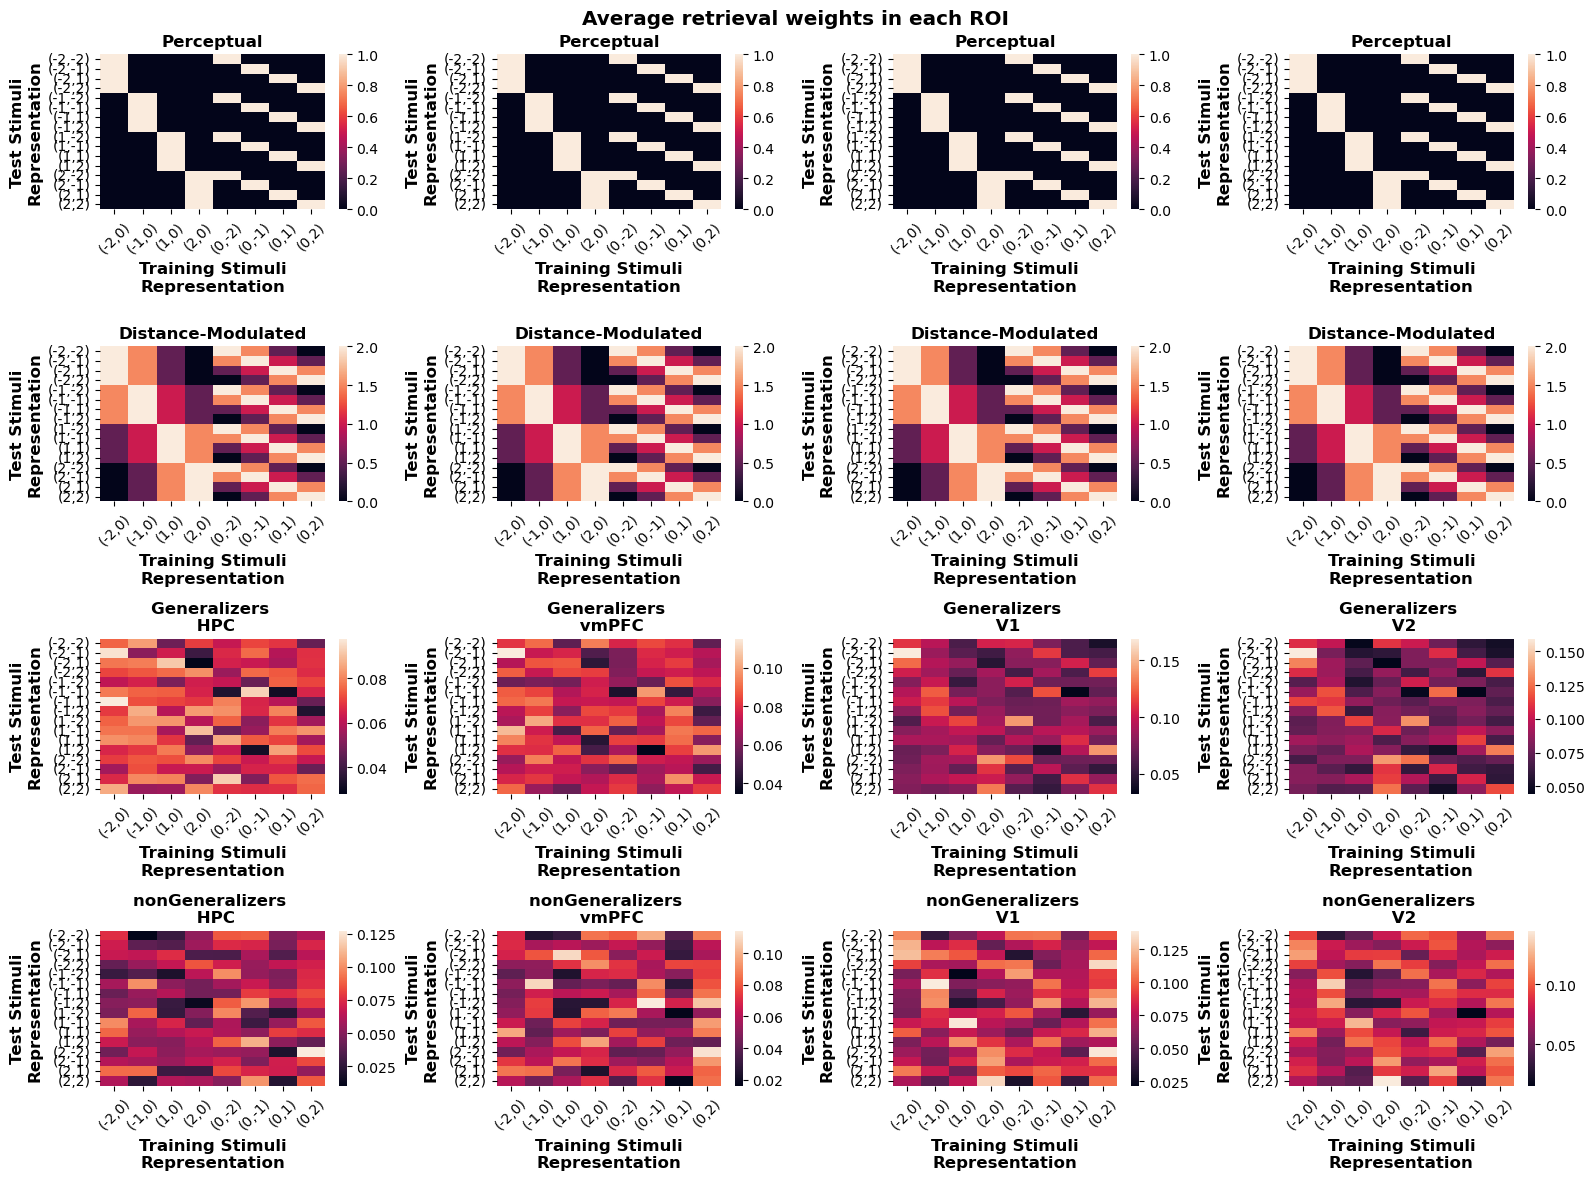

In [511]:
fig_rw, axes_rw = plt.subplots(4,4, figsize=(4*4,4*3))

for j, roi in enumerate(base_rois): # rois #base_rois
    broi = f"{roi}_bilateral" # roi
    sns.heatmap(np.mean(true_reg_coefs[broi],axis=0),square=False,ax = axes_rw[0,j])
    sns.heatmap(np.mean(dmod_reg_coefs[broi],axis=0),square=False,ax = axes_rw[1,j])

    G_coefs = [x for x,subid in zip(reg_coefs[broi],subid_list) if subid in generalizers]
    NG_coefs = [x for x,subid in zip(reg_coefs[broi],subid_list) if subid in nongeneralizers]
    sns.heatmap(np.mean(G_coefs,axis=0),square=False,ax = axes_rw[2,j])
    sns.heatmap(np.mean(NG_coefs,axis=0),square=False,ax = axes_rw[3,j])
    axes_rw[0,j].set_title("Perceptual",fontweight="bold",fontsize="large")
    axes_rw[1,j].set_title("Distance-Modulated",fontweight="bold",fontsize="large")
    axes_rw[2,j].set_title(f"Generalizers \n {roi}",fontweight="bold",fontsize="large")
    axes_rw[3,j].set_title(f"nonGeneralizers \n {roi}",fontweight="bold",fontsize="large")

#axes_rw[0,0].remove()
#axes_rw[0,2].remove()
#axes_rw[0,3].remove()

for ax in axes_rw.flatten():
    ax.set_yticks(ticks = np.arange(test_df.shape[0])+0.5,
        labels=['(%d,%d)' % (x*2,y*2) for x,y in test_df[["stim_x","stim_y"]].to_numpy()],
                            rotation=0)
    ax.set_xticks(ticks = np.arange(training_df.shape[0])+0.5,
        labels=['(%d,%d)' % (x*2,y*2) for x,y in training_df[["stim_x","stim_y"]].to_numpy()],
                            rotation=45)
    ax.set_xlabel("Training Stimuli\nRepresentation",fontweight="bold",fontsize="large")
    ax.set_ylabel("Test Stimuli\nRepresentation",fontweight="bold",fontsize="large")
fig_rw.suptitle("Average retrieval weights in each ROI",fontweight="bold",fontsize="x-large")
fig_rw.tight_layout()

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_40036\530290387.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



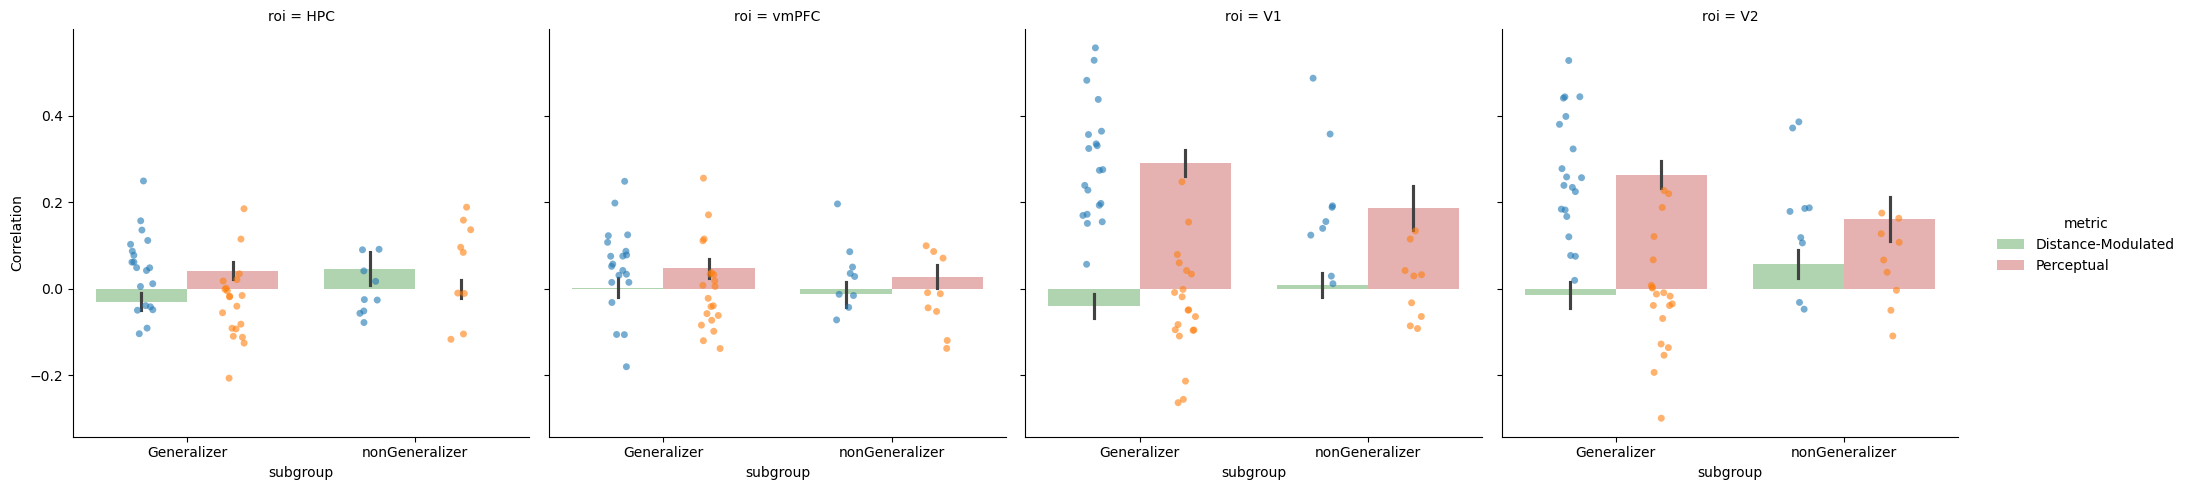

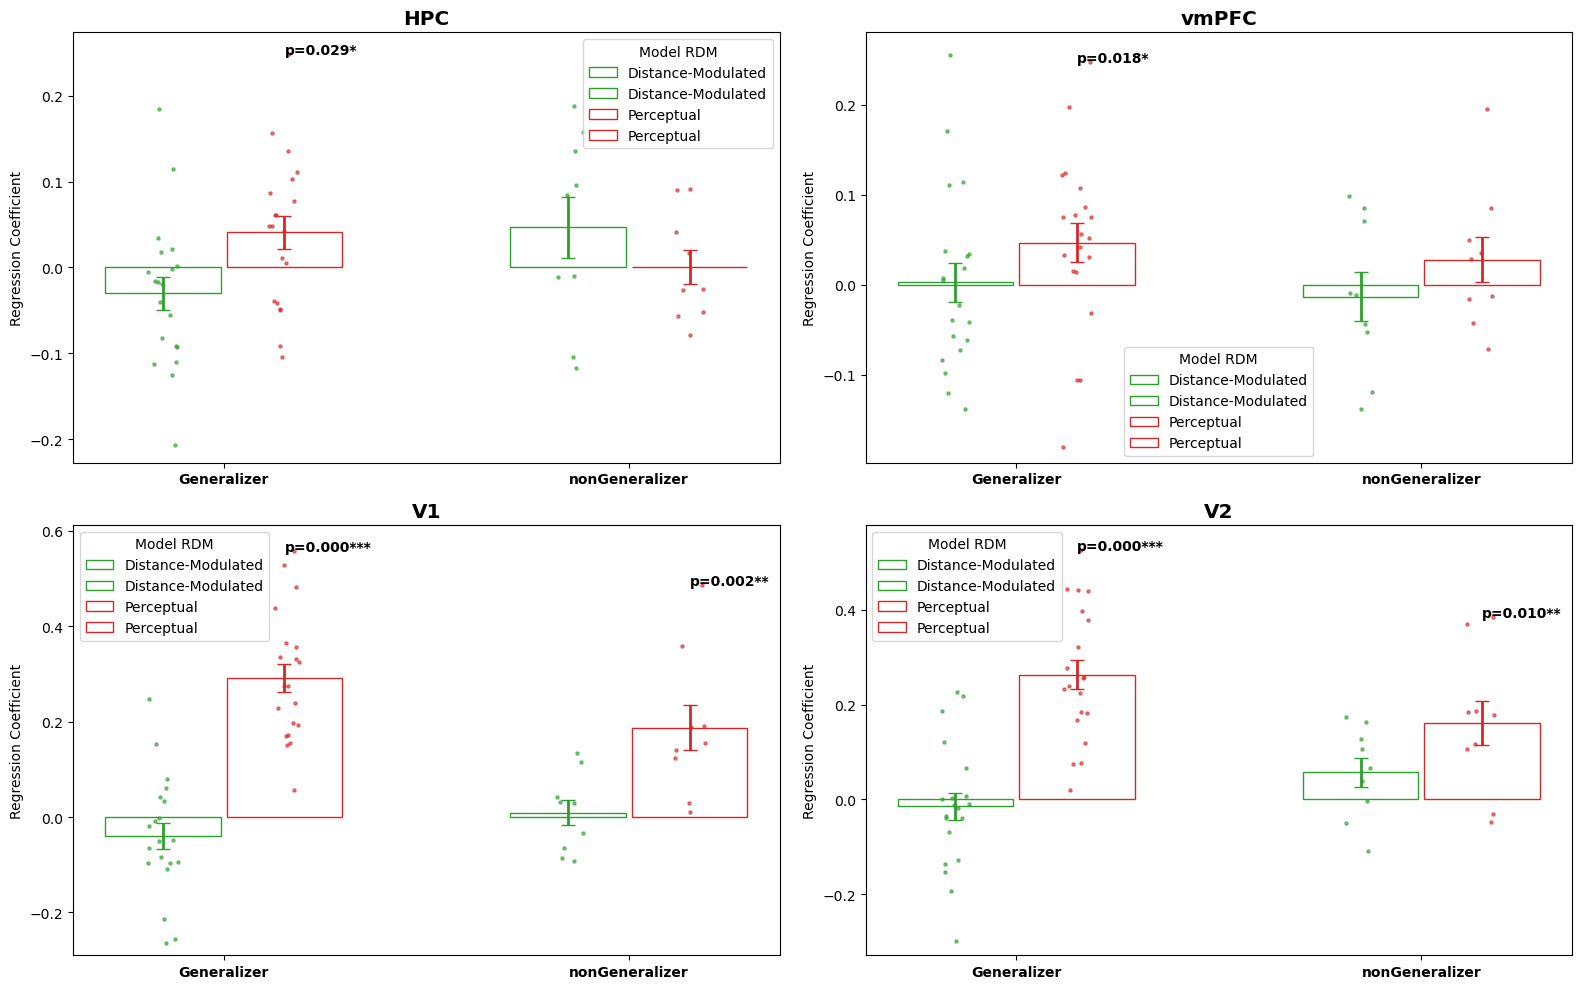

In [501]:
compositionretrieval_res_df = pd.concat(compositionretrieval_results,axis=0).reset_index(drop=True)
compositionretrieval_res_df = compositionretrieval_res_df[compositionretrieval_res_df.roi.str.contains("bilateral")].copy()
compositionretrieval_res_df["roi"] = compositionretrieval_res_df.roi.str.replace("_bilateral","")

compositionretrieval_res_df = compositionretrieval_res_df[compositionretrieval_res_df.metric.isin(["Perceptual","Distance-Modulated"])].copy()

coefcorr_gs = sns.catplot(compositionretrieval_res_df,
            x="subgroup",y="value",
            hue="metric",palette=sns.color_palette()[2:4],dodge=True,
            col="roi",
            kind="bar",
            errorbar="se",alpha=0.4)#
coefcorr_gs.map(sns.stripplot, 'subgroup', "value", "metric", dodge=True, 
                jitter=0.1,size=5,alpha=0.6,
                hue_order=["Perceptual","Distance-Modulated"],palette=sns.color_palette()[:2],
                order = ['Generalizer', 'nonGeneralizer'])
coefcorr_gs.set_ylabels("Correlation")

pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
plt_df = compositionretrieval_res_df.copy()
plt_df["roi"] = pd.Categorical(plt_df.roi,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
hue_dict = dict(zip(np.unique(plt_df["metric"]),sns.color_palette()[2:4]))

fig,axes = plt.subplots(prows,pcols,figsize=(8*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(plt_df.groupby("roi")):
    y_lim = np.array([np.min(roi_df.value),np.max(roi_df.value)])*1.1
    dodge_group = 0.15
    xdev = [-dodge_group,dodge_group]
    x_names = np.unique(roi_df["subgroup"])
    x_centers=np.arange(x_names.size)
    for kg,(gname,g_df) in enumerate(roi_df.groupby("metric")):
        x_locs = dict(zip(x_names,x_centers+xdev[kg]))
        for mname,xloc in x_locs.items():   
            y = g_df[g_df.subgroup==mname]["value"].to_numpy()
            jitt_x = np.random.random(y.shape)*.5*dodge_group - .5*dodge_group/2
            pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
            axes.flatten()[iroi].text(x=xloc, y=np.max(y),s=gen_pval_annot(pval),fontweight="bold")
            axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
            axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*1.9,label=gname,
                                color='None',edgecolor=hue_dict[gname])
            axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                barsabove=True,
                                ecolor=hue_dict[gname],alpha=1,linewidth=2)
    axes.flatten()[iroi].set_xticks(ticks=np.arange(x_names.size),
                                    labels=x_names,
                                    fontweight="bold")
    axes.flatten()[iroi].set_ylim(y_lim)
    axes.flatten()[iroi].set_ylabel("Regression Coefficient")
    axes.flatten()[iroi].set_title(f"{roi}",fontweight="bold",fontsize="x-large")
    axes.flatten()[iroi].legend(title="Model RDM")#.remove()
fig.tight_layout()

In [493]:
pd.concat(retrievalweigtsmean_results,axis=0)

mean retrieval weights training stimuli            roi   subid  \
0                 0.074027          related  HPC_bilateral  sub001   
1                 0.085084        unrelated  HPC_bilateral  sub001   
0                 0.079423          related  HPC_bilateral  sub002   
1                 0.082214        unrelated  HPC_bilateral  sub002   
0                 0.079259          related  HPC_bilateral  sub003   
..                     ...              ...            ...     ...   
1                 0.095215        unrelated   V2_bilateral  sub028   
0                 0.123907          related   V2_bilateral  sub029   
1                 0.064809        unrelated   V2_bilateral  sub029   
0                 0.100526          related   V2_bilateral  sub030   
1                 0.073914        unrelated   V2_bilateral  sub030   

          subgroup  
0      Generalizer  
1      Generalizer  
0   nonGeneralizer  
1   nonGeneralizer  
0      Generalizer  
..             ...  
1      Generalizer  
0      Generalizer  
1      Generalizer  
0      Generalizer  
1      Generalizer  

[232 rows x 5 columns]

Text(0.5, 0, 'ROI')

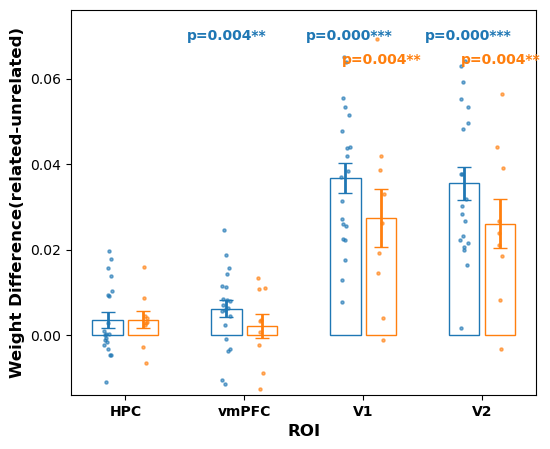

In [502]:
compositionretrieval_res_df = pd.concat(compositionretrieval_results,axis=0).reset_index(drop=True)
compositionretrieval_res_df = compositionretrieval_res_df[compositionretrieval_res_df.roi.str.contains("bilateral")].copy()
compositionretrieval_res_df["roi"] = pd.Categorical(compositionretrieval_res_df.roi.str.replace("_bilateral",""),
                                                    categories=base_rois,ordered=True)

compositionretrieval_res_df = compositionretrieval_res_df[compositionretrieval_res_df.metric.isin(["weightdiff"])].copy().reset_index(drop=True)
pcols = 1#int(len(rois)/2)
prows = 1#np.size(np.unique(res_df["analysis"]))
plt_df = compositionretrieval_res_df.copy()
plt_df["roi"] = pd.Categorical(plt_df.roi,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
hue_dict = dict(zip(np.unique(plt_df["metric"]),sns.color_palette()[2:4]))

pcols = 1#int(len(rois)/2)
prows = 1#np.size(np.unique(res_df["analysis"]))
xvar, gvar, yvar = "roi",  "subgroup", "value"
hue_dict = dict(zip(np.unique(compositionretrieval_res_df[gvar]),sns.color_palette(None,2)))
fig,axes = plt.subplots(prows,pcols,figsize=(6*pcols,5*prows))

y_lim = np.array([np.min(compositionretrieval_res_df[yvar]),np.max(compositionretrieval_res_df[yvar])])*1.1
dodge_group = 0.3
xdev = [ -dodge_group/2,dodge_group/2]
x_names = compositionretrieval_res_df[xvar].cat.categories
x_centers=np.arange(np.unique(compositionretrieval_res_df[xvar]).size)
for kg,(gname,g_df) in enumerate(compositionretrieval_res_df.groupby(gvar)):
    x_locs = dict(zip(x_names,x_centers+xdev[kg]))
    for xname,xloc in x_locs.items():   
        y = g_df[g_df[xvar]==xname][yvar].to_numpy()
        jitt_x = np.random.random(y.shape)*.25*dodge_group - .25*dodge_group/2
        pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
        axes.text(x=xloc-dodge_group*1.1, y=y_lim[1]/(1.1+0.1*kg),s=gen_pval_annot(pval),fontweight="bold",
                  color=hue_dict[gname])
        axes.scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
        axes.bar(xloc,y.mean(),width=dodge_group*0.85,label=gname,
                            color='None',edgecolor=hue_dict[gname])
        axes.errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                            barsabove=True,
                            ecolor=hue_dict[gname],alpha=1,linewidth=2)
axes.set_xticks(ticks=np.arange(x_names.size),
                                labels=x_names,
                                fontweight="bold")
axes.set_ylim(y_lim)
axes.set_ylabel("Weight Difference(related-unrelated)",fontweight="bold",fontsize="large")
axes.set_xlabel("ROI",fontweight="bold",fontsize="large")
#axes.legend()

### test from loc

In [514]:
crosstask_reg_coefs,crosstask_true_reg_coefs,crosstask_dmod_reg_coefs = {}, {}, {}
compositionretrieval_crosstask_results = []
retrievalweigtsmean_crosstask_results = []
for roi in rois:
    crosstask_reg_coefs[roi],crosstask_true_reg_coefs[roi], crosstask_dmod_reg_coefs[roi] = [], [], []
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        preprocedX = deepcopy(subdata["preprocX"])
        stimdf = subdata["stimdf"]
        
        
        # get navigation test stimuli average across sessions
        navi_filter = np.vstack(
            [stimdf.taskname.to_numpy() == "navigation",
             [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]
        ).all(axis=0)
        navi_X = np.mean(split_data(X      = preprocedX[navi_filter,:],
                                    groups = stimdf[navi_filter].copy().stim_session.to_numpy()),
                        axis=0)
        navi_X = scale_feature(navi_X,0) # 

        assert navi_X.shape[0] == 24
        navi_df = stimdf[navi_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True)

        test_filter = navi_df.stim_group==1
        test_X = navi_X[test_filter]
        test_df = navi_df[test_filter].copy().reset_index(drop=True)

        lzer_filter = np.vstack(
            [stimdf.taskname.to_numpy() == "localizer",
             [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]
        ).all(axis=0)
        lzer_df = stimdf[lzer_filter].copy().reset_index(drop=True)
        lzerX  = preprocedX[lzer_filter,:]
        trdfneworder = lzer_df.sort_values(by=['training_axset','training_axloc'])
        new_order = trdfneworder.index
        training_df = trdfneworder.reset_index(drop=True)
        training_X = lzerX[new_order,:]
        
        

        sub_reg_coefs,sub_true_reg_coefs,sub_dmod_reg_coefs = get_retrieval_weights(test_X,training_X,test_df,training_df)
        #sub_reg_coefs,sub_true_reg_coefs,sub_dmod_reg_coefs = get_retrieval_correlation(test_X,training_X,test_df,training_df)

        crosstask_reg_coefs[roi].append(sub_reg_coefs)
        crosstask_true_reg_coefs[roi].append(sub_true_reg_coefs)
        crosstask_dmod_reg_coefs[roi].append(sub_dmod_reg_coefs)

        #for j in range(test_df.shape[0]):
        #   sub_reg_coefs[j][sub_true_reg_coefs[j]==1]
        compo_stims = sub_reg_coefs[sub_true_reg_coefs==1]
        noncompo_stims = sub_reg_coefs[sub_true_reg_coefs==0]
        corr_percept = scipy.stats.spearmanr(sub_reg_coefs.flatten(),sub_true_reg_coefs.flatten())
        corr_dmod = scipy.stats.spearmanr(sub_reg_coefs.flatten(),sub_dmod_reg_coefs.flatten())
        pdcoef = LinearRegression().fit(
            X=scale_feature(np.array([sub_dmod_reg_coefs.flatten(),sub_true_reg_coefs.flatten()]).T,1),
            y=scale_feature(sub_reg_coefs.flatten(),2)
        ).coef_

        subrwdf = pd.DataFrame({"mean retrieval weights":[compo_stims.mean(),noncompo_stims.mean()],
                                "training stimuli": ["related","unrelated"]}).assign(roi=roi,subid=subid,subgroup=subgroup)
        retrievalweigtsmean_crosstask_results.append(subrwdf)

        subresdf = pd.DataFrame({"value":[pdcoef[0],pdcoef[1],compo_stims.mean()-noncompo_stims.mean()],#corr_dmod.correlation,corr_percept.correlation
                                 "metric":["Distance-Modulated","Perceptual","weightdiff",]}
                                 ).assign(roi=roi,subid=subid,subgroup=subgroup)
        compositionretrieval_crosstask_results.append(subresdf)


In [515]:
fig_rw, axes_rw = plt.subplots(4,4, figsize=(4*4,4*3))

for j, roi in enumerate(base_rois): # rois #base_rois
    broi = f"{roi}_bilateral" # roi
    sns.heatmap(np.mean(crosstask_true_reg_coefs[broi],axis=0),square=False,ax = axes_rw[0,j])
    sns.heatmap(np.mean(crosstask_dmod_reg_coefs[broi],axis=0),square=False,ax = axes_rw[1,j])

    G_coefs = [x for x,subid in zip(crosstask_reg_coefs[broi],subid_list) if subid in generalizers]
    NG_coefs = [x for x,subid in zip(crosstask_reg_coefs[broi],subid_list) if subid in nongeneralizers]
    sns.heatmap(np.mean(G_coefs,axis=0),square=False,ax = axes_rw[2,j])
    sns.heatmap(np.mean(NG_coefs,axis=0),square=False,ax = axes_rw[3,j])
    axes_rw[0,j].set_title("Perceptual",fontweight="bold",fontsize="large")
    axes_rw[1,j].set_title("Distance-Modulated",fontweight="bold",fontsize="large")
    axes_rw[2,j].set_title(f"Generalizers \n {roi}",fontweight="bold",fontsize="large")
    axes_rw[3,j].set_title(f"nonGeneralizers \n {roi}",fontweight="bold",fontsize="large")

#axes_rw[0,0].remove()
#axes_rw[0,2].remove()
#axes_rw[0,3].remove()

for ax in axes_rw.flatten():
    ax.set_yticks(ticks = np.arange(test_df.shape[0])+0.5,
        labels=['(%d,%d)' % (x*2,y*2) for x,y in test_df[["stim_x","stim_y"]].to_numpy()],
                            rotation=0)
    ax.set_xticks(ticks = np.arange(training_df.shape[0])+0.5,
        labels=['(%d,%d)' % (x*2,y*2) for x,y in training_df[["stim_x","stim_y"]].to_numpy()],
                            rotation=45)
    ax.set_xlabel("Location Representation",fontweight="bold",fontsize="large")
    ax.set_ylabel("Test Stimuli \n Representation",fontweight="bold",fontsize="large")

fig_rw.suptitle("Average retrieval weights in each ROI",fontweight="bold",fontsize="x-large")
fig_rw.tight_layout()

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_40036\3731310075.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



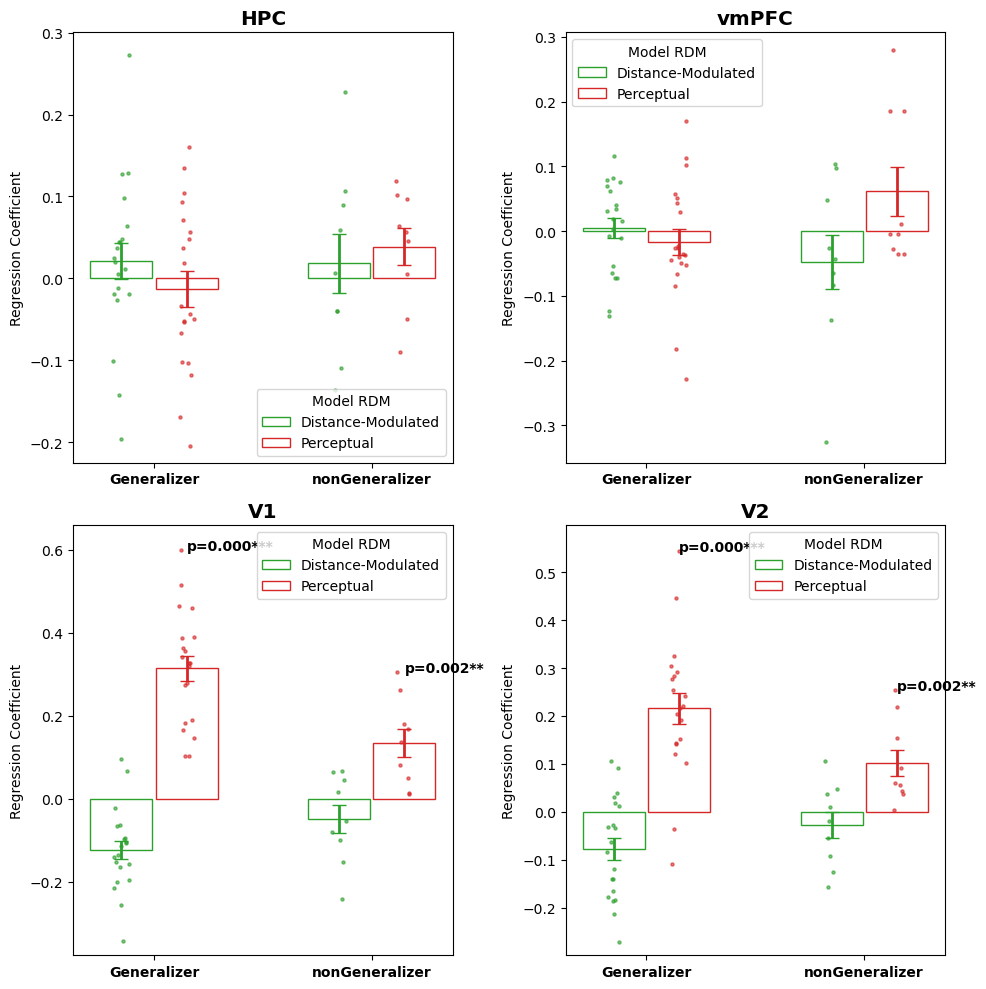

In [505]:
compositionretrieval_crosstask_res_df = pd.concat(compositionretrieval_crosstask_results,axis=0).reset_index(drop=True)
compositionretrieval_crosstask_res_df = compositionretrieval_crosstask_res_df[compositionretrieval_crosstask_res_df.roi.str.contains("bilateral")].copy()
compositionretrieval_crosstask_res_df["roi"] = compositionretrieval_crosstask_res_df.roi.str.replace("_bilateral","")

compositionretrieval_crosstask_res_df = compositionretrieval_crosstask_res_df[compositionretrieval_crosstask_res_df.metric.isin(["Distance-Modulated","Perceptual"])].copy()

coefcorr_gs = sns.catplot(compositionretrieval_crosstask_res_df,
            x="subgroup",y="value",
            hue="metric",palette=sns.color_palette()[2:4],dodge=True,
            col="roi",
            kind="bar",
            errorbar="se",alpha=0.4)#
coefcorr_gs.map(sns.stripplot, 'subgroup', "value", "metric", dodge=True, 
                jitter=0.1,size=5,alpha=0.6,
                hue_order=["Distance-Modulated","Perceptual"],palette=sns.color_palette()[2:4],
                order = ['Generalizer', 'nonGeneralizer'])
coefcorr_gs.set_ylabels("Correlation")

pcols = 2#int(len(rois)/2)
prows = 2#np.size(np.unique(res_df["analysis"]))
plt_df = compositionretrieval_crosstask_res_df.copy()
plt_df["roi"] = pd.Categorical(plt_df.roi,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
hue_dict = dict(zip(np.unique(plt_df["metric"]),sns.color_palette()[2:4]))

fig,axes = plt.subplots(prows,pcols,figsize=(5*pcols,5*prows))
for iroi,(roi,roi_df) in enumerate(plt_df.groupby("roi")):
    y_lim = np.array([np.min(roi_df.value),np.max(roi_df.value)])*1.1
    dodge_group = 0.15
    xdev = [-dodge_group,dodge_group]
    x_names = np.unique(roi_df["subgroup"])
    x_centers=np.arange(x_names.size)
    for kg,(gname,g_df) in enumerate(roi_df.groupby("metric")):
        x_locs = dict(zip(x_names,x_centers+xdev[kg]))
        for mname,xloc in x_locs.items():   
            y = g_df[g_df.subgroup==mname]["value"].to_numpy()
            jitt_x = np.random.random(y.shape)*.5*dodge_group - .5*dodge_group/2
            pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
            axes.flatten()[iroi].text(x=xloc, y=np.max(y),s=gen_pval_annot(pval),fontweight="bold")
            axes.flatten()[iroi].scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
            axes.flatten()[iroi].bar(xloc,y.mean(),width=dodge_group*1.9,label=gname,
                                color='None',edgecolor=hue_dict[gname])
            axes.flatten()[iroi].errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                                barsabove=True,
                                ecolor=hue_dict[gname],alpha=1,linewidth=2)
    axes.flatten()[iroi].set_xticks(ticks=np.arange(x_names.size),
                                    labels=x_names,
                                    fontweight="bold")
    axes.flatten()[iroi].set_ylim(y_lim)
    axes.flatten()[iroi].set_ylabel("Regression Coefficient")
    axes.flatten()[iroi].set_title(f"{roi}",fontweight="bold",fontsize="x-large")
    axes.flatten()[iroi].legend(title="Model RDM")#.remove()
    axes.flatten()[iroi].legend()
    hs, ls = axes.flatten()[iroi].get_legend_handles_labels()
    axes.flatten()[iroi].legend([hs[0], hs[2]],[ls[0], ls[2]],title="Model RDM")
fig.tight_layout()

Text(0.5, 0, 'ROI')

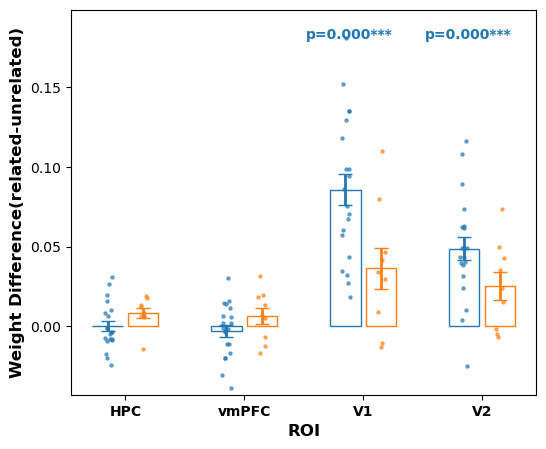

In [422]:
compositionretrieval_crosstask_res_df = pd.concat(compositionretrieval_crosstask_results,axis=0).reset_index(drop=True)
compositionretrieval_crosstask_res_df = compositionretrieval_crosstask_res_df[compositionretrieval_crosstask_res_df.roi.str.contains("bilateral")].copy()
compositionretrieval_crosstask_res_df["roi"] = pd.Categorical(compositionretrieval_crosstask_res_df.roi.str.replace("_bilateral",""),
                                                    categories=base_rois,ordered=True)

compositionretrieval_crosstask_res_df = compositionretrieval_crosstask_res_df[compositionretrieval_crosstask_res_df.metric.isin(["weightdiff"])].copy().reset_index(drop=True)
pcols = 1#int(len(rois)/2)
prows = 1#np.size(np.unique(res_df["analysis"]))
plt_df = compositionretrieval_crosstask_res_df.copy()
plt_df["roi"] = pd.Categorical(plt_df.roi,
                                categories = base_rois,#['EC', 'hippocampus', 'mPFC', 'SPC', 'V1', 'V2'],
                                ordered=True)
hue_dict = dict(zip(np.unique(plt_df["metric"]),sns.color_palette()[2:4]))

pcols = 1#int(len(rois)/2)
prows = 1#np.size(np.unique(res_df["analysis"]))
xvar, gvar, yvar = "roi",  "subgroup", "value"
hue_dict = dict(zip(np.unique(compositionretrieval_crosstask_res_df[gvar]),sns.color_palette(None,2)))
fig,axes = plt.subplots(prows,pcols,figsize=(6*pcols,5*prows))

y_lim = np.array([np.min(compositionretrieval_crosstask_res_df[yvar]),np.max(compositionretrieval_crosstask_res_df[yvar])])*1.1
dodge_group = 0.3
xdev = [ -dodge_group/2,dodge_group/2]
x_names = compositionretrieval_crosstask_res_df[xvar].cat.categories
x_centers=np.arange(np.unique(compositionretrieval_crosstask_res_df[xvar]).size)
for kg,(gname,g_df) in enumerate(compositionretrieval_crosstask_res_df.groupby(gvar)):
    x_locs = dict(zip(x_names,x_centers+xdev[kg]))
    for xname,xloc in x_locs.items():   
        y = g_df[g_df[xvar]==xname][yvar].to_numpy()
        jitt_x = np.random.random(y.shape)*.25*dodge_group - .25*dodge_group/2
        pval = scipy.stats.wilcoxon(y,alternative="greater").pvalue                
        axes.text(x=xloc-dodge_group*1.1, y=y_lim[1]/(1.1+0.1*kg),s=gen_pval_annot(pval*8),fontweight="bold",
                  color=hue_dict[gname])
        axes.scatter(x=xloc*np.ones_like(y)+jitt_x,y=y,color=hue_dict[gname],s=5,alpha=0.6)
        axes.bar(xloc,y.mean(),width=dodge_group*0.85,label=gname,
                            color='None',edgecolor=hue_dict[gname])
        axes.errorbar(xloc,y.mean(),yerr=y.std()/np.sqrt(y.size),capsize=5,
                            barsabove=True,
                            ecolor=hue_dict[gname],alpha=1,linewidth=2)
axes.set_xticks(ticks=np.arange(x_names.size),
                                labels=x_names,
                                fontweight="bold")
axes.set_ylim(y_lim)
axes.set_ylabel("Weight Difference(related-unrelated)",fontweight="bold",fontsize="large")
axes.set_xlabel("ROI",fontweight="bold",fontsize="large")
#axes.legend()

### test from other region

In [221]:
subdata_lzer, subdata_train, subdata_test = {}, {} ,{}
for roi in rois:
    subdata = roi_data[roi][0]
    preprocedX = deepcopy(subdata["preprocX"])
    stimdf = subdata["stimdf"]

    navi_filter = np.vstack(
        [stimdf.taskname.to_numpy() == "navigation",
            [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]
    ).all(axis=0)

    #average across sessions
    navi_X = np.mean(split_data(X      = preprocedX[navi_filter,:],
                                groups = stimdf[navi_filter].copy().stim_session.to_numpy()),
                    axis=0)
    #navi_X = scale_feature(navi_X,0) # 

    assert navi_X.shape[0] == 24
    navi_df = stimdf[navi_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True)

    training_filter = navi_df.stim_group==1
    test_filter = navi_df.stim_group==0

    trdf = navi_df[training_filter].copy().reset_index(drop=True)
    trX  = navi_X[training_filter]
    trdfneworder = trdf.sort_values(by=['training_axset','training_axloc'])
    new_order = trdfneworder.index
    training_df = trdfneworder.reset_index(drop=True)
    training_X = trX[new_order,:]

    test_X = navi_X[test_filter]
    test_df = navi_df[test_filter].copy().reset_index(drop=True)

    lzer_filter = np.vstack(
        [stimdf.taskname.to_numpy() == "localizer",
        [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]
    ).all(axis=0)

    #average across sessions
    lzX = preprocedX[lzer_filter,:]
    lzdf = stimdf[lzer_filter].copy().reset_index(drop=True)
    lzdfneworder = lzdf.sort_values(by=['training_axset','training_axloc'])
    new_order = lzdfneworder.index
    lzer_df = lzdfneworder.reset_index(drop=True)
    lzer_X = lzX[new_order,:]

    subdata_train[roi] = training_X
    subdata_test[roi] = test_X
    subdata_lzer[roi] = lzX




In [ ]:
reg_coefs,true_reg_coefs,dmod_reg_coefs = {}, {}, {}
compositionretrieval_results = []
retrievalweigtsmean_results = []
for roi in rois:
    reg_coefs[roi],true_reg_coefs[roi], dmod_reg_coefs[roi] = [], [], []
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        preprocedX = deepcopy(subdata["preprocX"])
        stimdf = subdata["stimdf"]
        
        navi_filter = np.vstack(
            [stimdf.taskname.to_numpy() == "navigation",
             [not np.logical_and(x==0,y==0) for x,y in stimdf[["stim_x","stim_y"]].to_numpy()]]
        ).all(axis=0)
        
        #average across sessions
        navi_X = np.mean(split_data(X      = preprocedX[navi_filter,:],
                                    groups = stimdf[navi_filter].copy().stim_session.to_numpy()),
                        axis=0)
        #navi_X = scale_feature(navi_X,0) # 

        assert navi_X.shape[0] == 24
        navi_df = stimdf[navi_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True)

        training_filter = navi_df.stim_group==1
        test_filter = navi_df.stim_group==0

        trdf = navi_df[training_filter].copy().reset_index(drop=True)
        trX  = navi_X[training_filter]
        trdfneworder = trdf.sort_values(by=['training_axset','training_axloc'])
        new_order = trdfneworder.index
        training_df = trdfneworder.reset_index(drop=True)
        training_X = trX[new_order,:]
        
        
        test_X = navi_X[test_filter]
        test_df = navi_df[test_filter].copy().reset_index(drop=True)

        sub_reg_coefs,sub_true_reg_coefs,sub_dmod_reg_coefs = get_retrieval_weights(test_X,training_X,test_df,training_df)
        #sub_reg_coefs,sub_true_reg_coefs,sub_dmod_reg_coefs = get_retrieval_correlation(test_X,training_X,test_df,training_df)
        reg_coefs[roi].append(sub_reg_coefs)
        true_reg_coefs[roi].append(sub_true_reg_coefs)
        dmod_reg_coefs[roi].append(sub_dmod_reg_coefs)

        #for j in range(test_df.shape[0]):
        #   sub_reg_coefs[j][sub_true_reg_coefs[j]==1]
        compo_stims = sub_reg_coefs[sub_true_reg_coefs==1]
        noncompo_stims = sub_reg_coefs[sub_true_reg_coefs==0]
        corr_percept = scipy.stats.spearmanr(sub_reg_coefs.flatten(),sub_true_reg_coefs.flatten())
        corr_dmod = scipy.stats.spearmanr(sub_reg_coefs.flatten(),sub_dmod_reg_coefs.flatten())
        pdcoef = LinearRegression().fit(
            X=scale_feature(np.array([sub_dmod_reg_coefs.flatten(),sub_true_reg_coefs.flatten()]).T,1),
            y=scale_feature(sub_reg_coefs.flatten(),2)
        ).coef_

        subrwdf = pd.DataFrame({"mean retrieval weights":[compo_stims.mean(),noncompo_stims.mean()],
                                "training stimuli": ["related","unrelated"]}).assign(roi=roi,subid=subid,subgroup=subgroup)
        retrievalweigtsmean_results.append(subrwdf)

        subresdf = pd.DataFrame({"value":[pdcoef[0],pdcoef[1],compo_stims.mean()-noncompo_stims.mean()],#np.arctanh(corr_dmod.correlation),np.arctanh(corr_percept.correlation)
                                 "metric":["corr_dmod","corr_percept","weightdiff",]}
                                 ).assign(roi=roi,subid=subid,subgroup=subgroup)
        compositionretrieval_results.append(subresdf)
        
